In [2]:
#Import Statements
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#functions
def gaborFilter(v, Fs, tres, plot_count, w, ftype='gaussian'):
    '''The Gabor method, or short-time Fourier transform, trades away some measure of 
    accuracy in both the time and frequency domains in order to give both time and frequency 
    resolution simultaneously.

    This function takes in a two dimensional signal, performs multi-resolution analysis of 
    the signal with Gabor filtering for showing signal frequency content over time.
    
    INPUTS:
    v: numpy.ndarray of signal to analyze.
    Fs: scalar value indicating signal sampling rate. Used to determine time scale for analysis
    ftype: string indicating type of filter to use for the Gabor method
    w: scalar value for scaling the filter width
    tres: scalar value indicating the time resolution to use for filtering.
    plot_count: scalar value indicating number of filtered signal plots to output
    
    OUTPUTS:
    Sgt_spec: numpy.ndarray of fourier transformed and shifted data in each time bin
    tslide: numpy.ndarray of the time bins used in analysis
    ks: numpy.ndarray of shifted wave numbers
    
    Plots:
    Plots showing the Gabor filtered signal at time points across the range of time bins
    '''
    isOdd = (len(v) % 2 == 1)# check if there is an odd number of entries
    t2 = (np.arange(0,len(v) + 1)) / Fs
    t = t2[0:len(v)]

    L = (len(v) - 1) / Fs # frequency domain
    n = len(v); # Fourier modes

    tslide = np.arange(0, L, tres)
    
    if isOdd: #if there is an odd number of entries, ignore the last data value
        #construct wave numbers
        k = np.concatenate([np.arange(0, (n / 2) - 1), np.arange(-n / 2, -1)])#fourier coeffs list accounting for the fft shift
        k = k * (2 * np.pi / L)#convert to a 2 pi periodic domain by rescaling
        ks = np.fft.fftshift(k)#k shifted to plot frequency domain as a funciton of wave number
        Sgt_spec = np.zeros((len(tslide), len(v) - 1))#creates empty matrix to store fft for each window of time
    else:
        k = np.concatenate([np.arange(0, (n / 2)), np.arange(-n / 2, 0)])#fourier coeffs list accounting for the fft shift
        k = k * (2 * np.pi / L)#convert to a 2 pi periodic domain by rescaling
        ks = np.fft.fftshift(k)#k shifted to plot frequency domain as a funciton of wave number
        Sgt_spec = np.zeros((len(tslide), len(v)))#creates empty matrix to store fft for each window of time

    vt = np.transpose(v)
    
    plot_num = len(tslide) // plot_count #number of plots to generate across the range of time bins
    

    for j in range(0, len(tslide)):
        if ftype == 'gaussian':
            g = np.exp(-w*(t - tslide[j])**2) #Gaussian Wavelet
        elif ftype == 'mexicanHat':
            g = (1 - w*(t - tslide[j])**2)*np.exp(-(t - tslide[j])**2) #Mexican hat
        elif ftype == 'shannon':
            g = w*abs(t - tslide[j]) <= 0.5 #Shannon function
        else:
            g = np.exp(-2 * (t - tslide[j])**2); #Gabor filter shifted to center at tslide[j]
            
        Sg = np.transpose(g * vt) #apply filter to signal
        if isOdd: #if there is an odd number of entries, ignore the last data value
            Sgt = np.fft.fft2(Sg[0:len(v) - 1]) #calculate fourier transform of filtered signal
        else:
            Sgt = np.fft.fft2(Sg[0:len(v)]) #calculate fourier transform of filtered signal
        Sgt_spec[j, :] = np.transpose(abs(np.fft.fftshift(Sgt))) #save shifted fourier transform for spectrogram plotting
        if (j % plot_num == 0):
            f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,20))
            ax1.plot(t, v, color='black')
            ax1.plot(t, np.transpose(g), color='red', label='Gabor Filter')
            ax1.set_title('Signal with Gabor '+ ftype +' Filter time step: ' + str(tslide[j]))
            ax1.set_ylabel('Amplitude')
            ax1.set_xlabel('Time [sec]')
            ax1.legend(loc='upper right')
            ax2.plot(t, Sg, color='black')
            ax2.set_title('Gabor Filtered Signal')
            ax2.set_ylabel('Amplitude')
            ax2.set_xlabel('Time [sec]')
            ax3.plot(ks, abs(np.fft.fftshift(Sgt))/max(abs(np.fft.fftshift(Sgt))))
            ax3.set_title('Filtered Signal Frequency Spectrum')
            ax3.set_ylabel('Frequency [Hz]')
            ax3.set_xlabel('Time [sec]')
            
    return Sgt_spec, tslide, ks
            
def spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title):
    '''spectroPlot generates a spectrogram plot of Gabor filtered two dimensional signal data
    
    INPUT:
    Sgt_spec: Sgt_spec: numpy.ndarray of fourier transformed and shifted data in each time bin
    tslide: numpy.ndarray of the time bins used in analysis
    ks: numpy.ndarray of shifted wave numbers
    xlim: tuple indicating x axis minimum and maximum (min, max)
    ylim: tuple indicating y axis minimum and maximum (min, max)'''
    
    f, ax = plt.subplots()
    ax.pcolormesh(tslide, ks, np.transpose(Sgt_spec), cmap = 'hot')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(title)
    ax.set(xlim = xlim, ylim = ylim)

def find_nearest(array, value):
    '''find_nearest takes in an array and a value and finds the index of the value in the array
    of which the passed value is closest to.
    
    INPUT:
    array: numpy.ndarray of values to search within for the entry closest to the value of interest
    value: scalar value to compare to each entry of the array
    
    OUTPUT:
    idx: scalar value indicating the index of the array that contains the value closest to the value of interest
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [20]:
#Data matrix contains 2 dimensional handel music sample
y_ = loadmat('y.mat')#load MATLAB .mat file into python as a dictionary
y = y_['y']#raw 'handel' music data matrix

Fs_ = loadmat('Fs.mat')#load MATLAB .mat file into python as a dictionary
Fs = Fs_['Fs']#raw data

r, c = y.shape

Text(0.5, 1.0, 'handel MATLAB music signal')

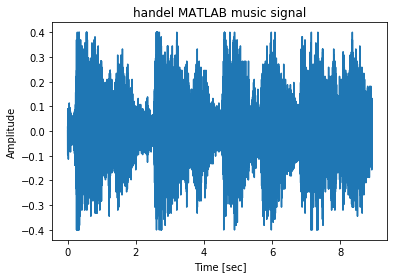

In [21]:
v = y / 2
t = (np.arange(0,len(v))) / Fs[0]#create time array for plotting

#plot of 'handel' music file from MATLAB
fig, ax = plt.subplots()
ax.plot(t, v)#plot signal in time
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Amplitude')
ax.set_title('handel MATLAB music signal')

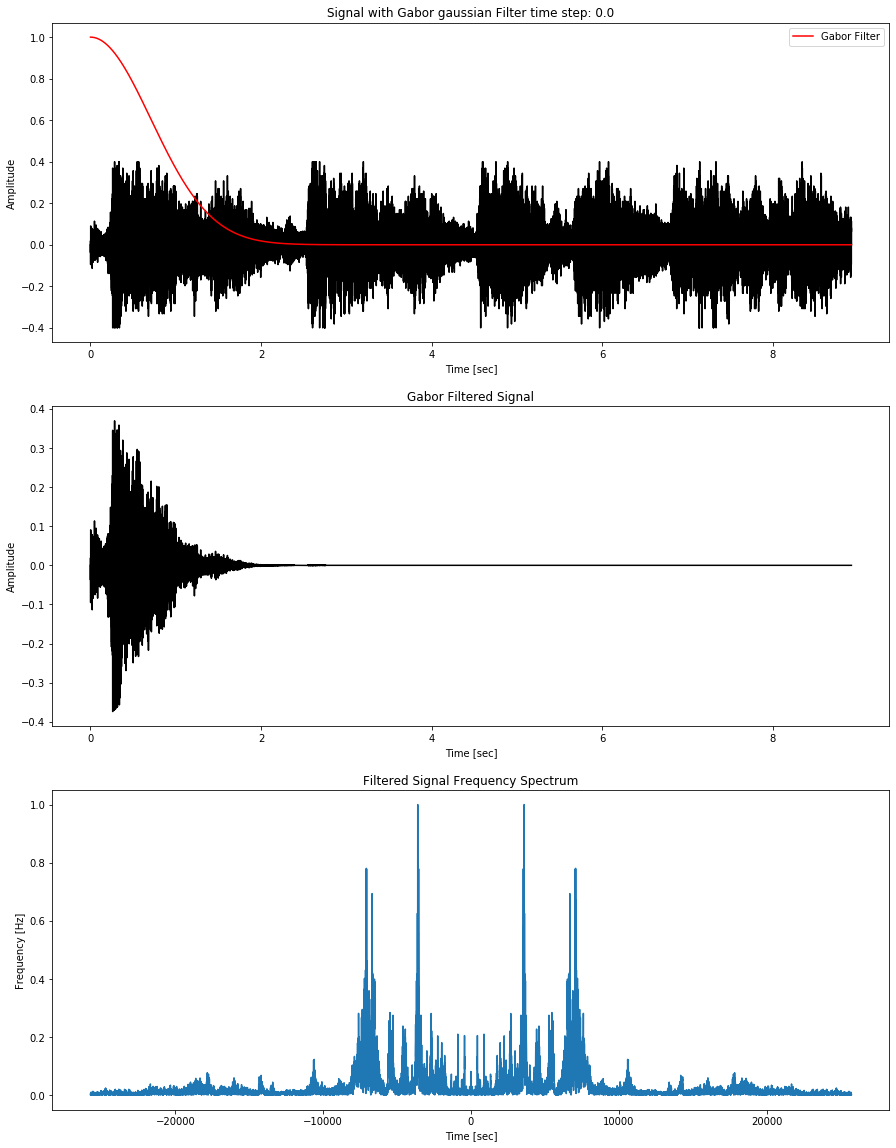

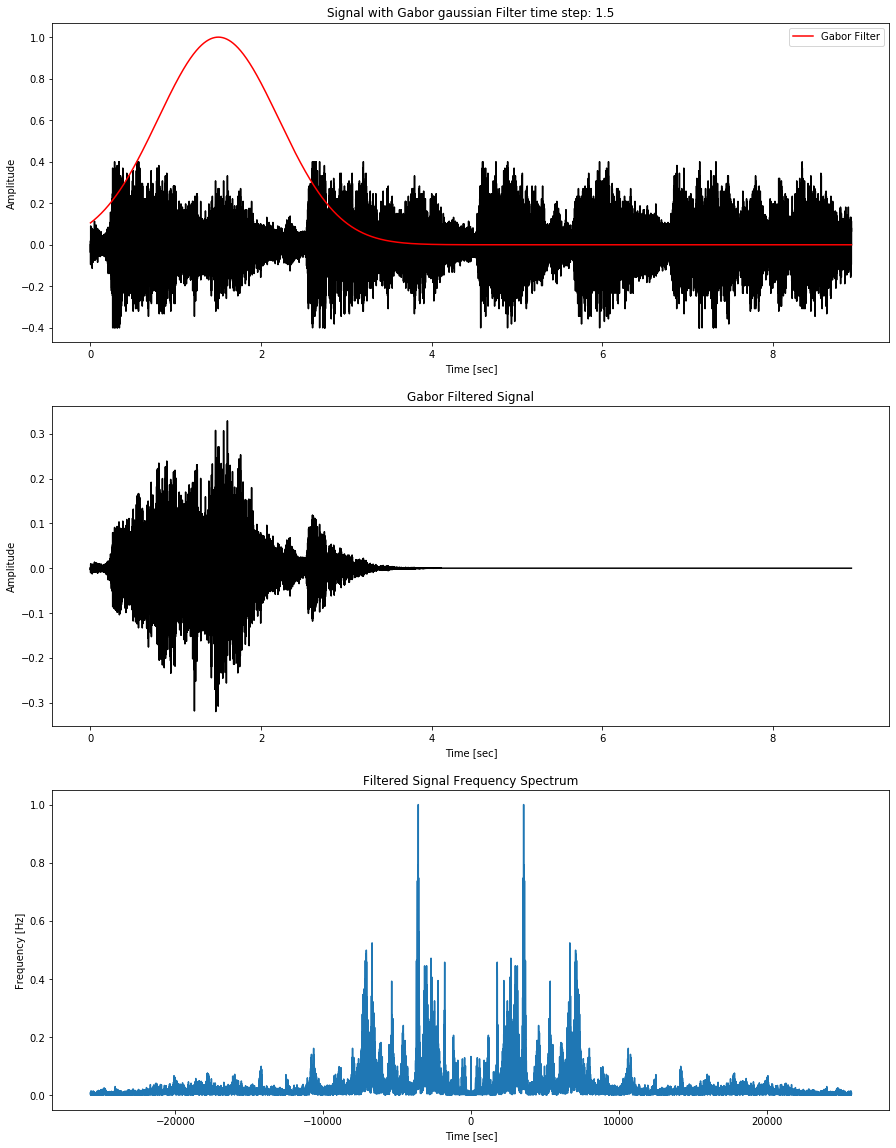

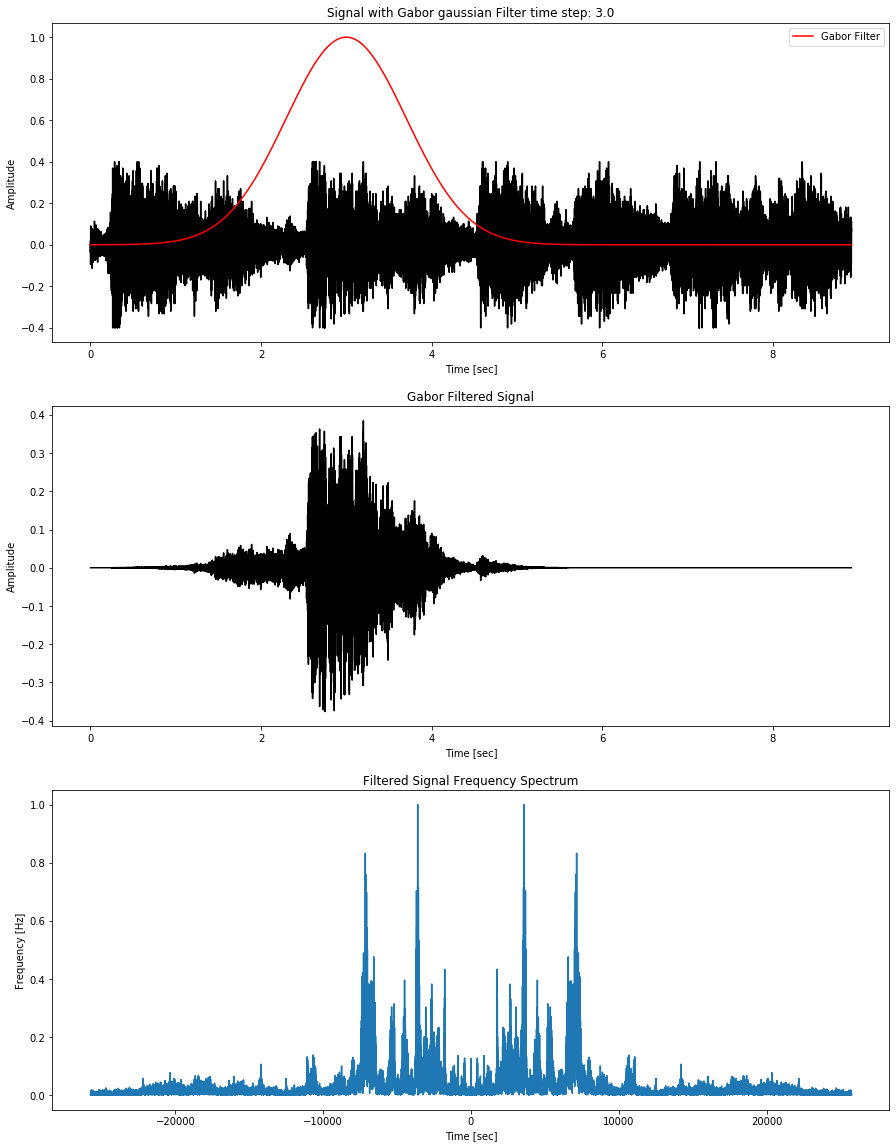

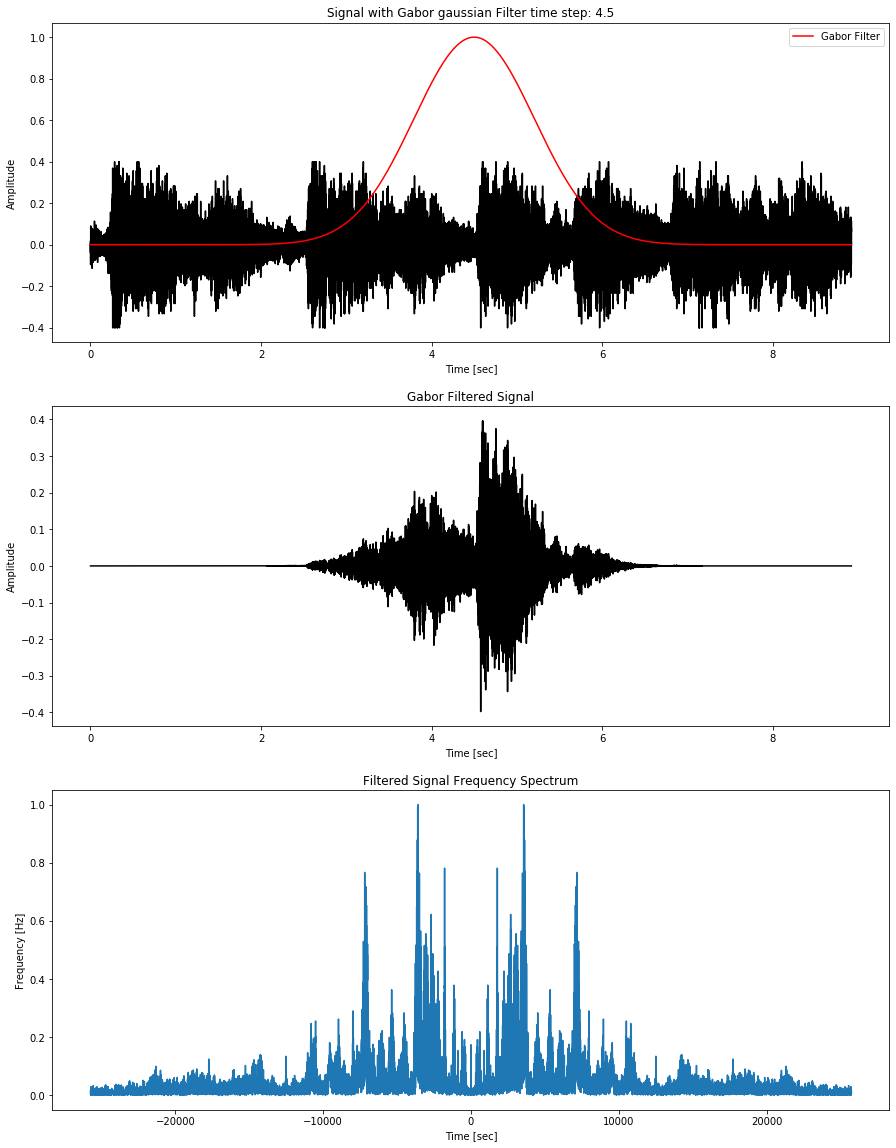

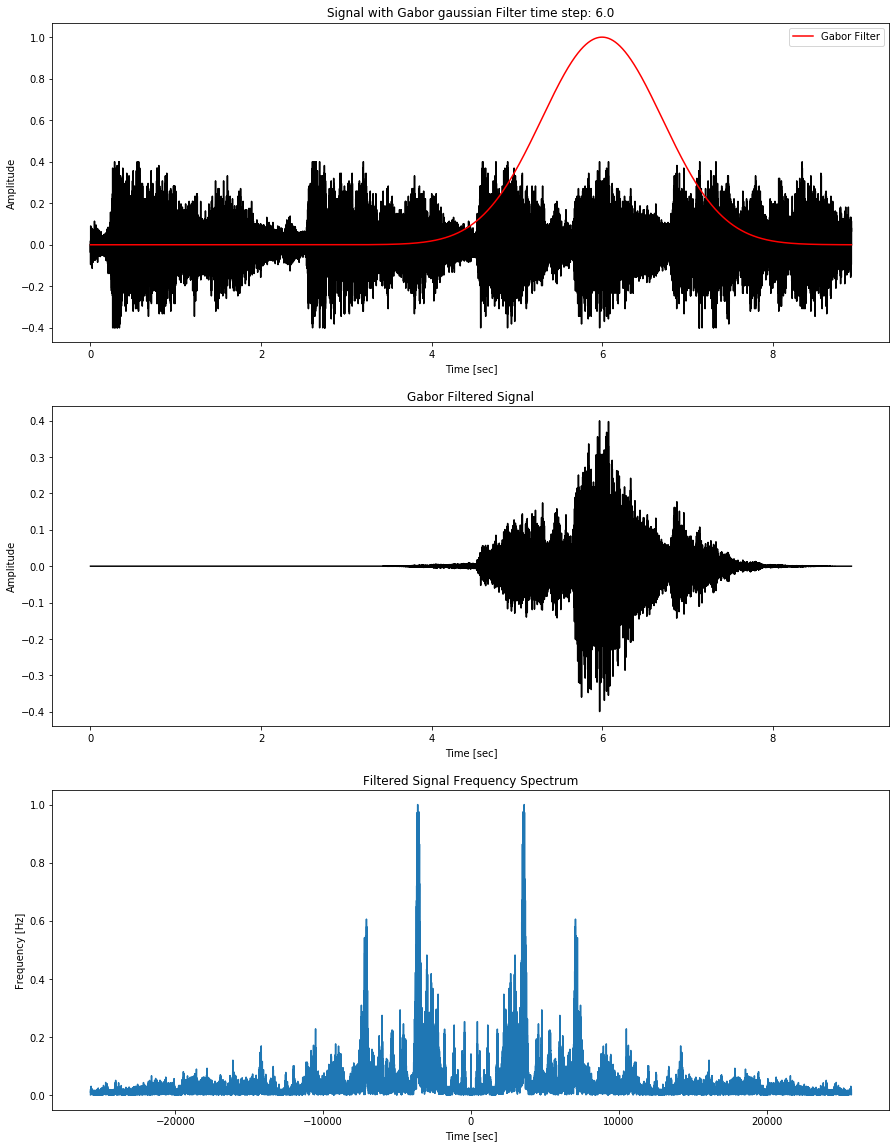

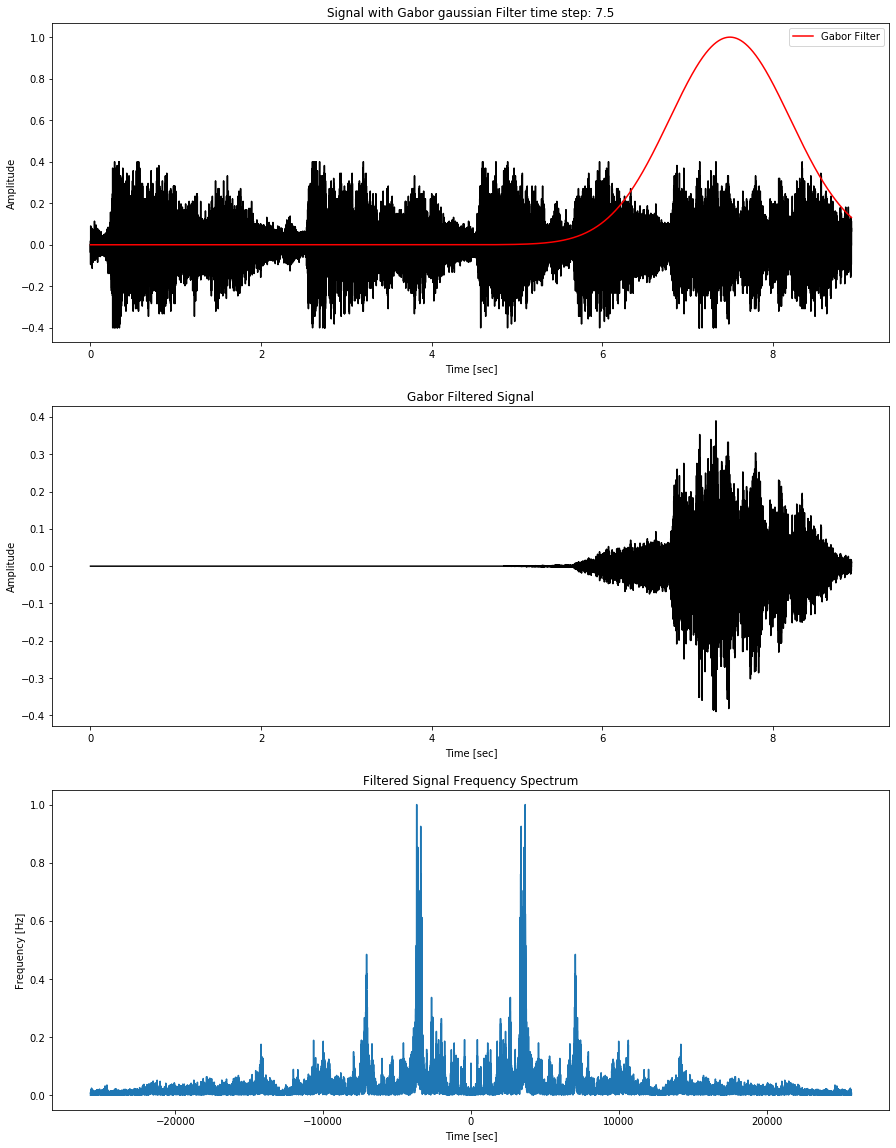

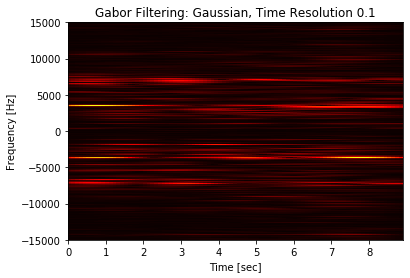

In [32]:
'''The Gabor method, or short-time Fourier transform, trades away some measure of 
accuracy in both the time and frequency domains in order to give both time and frequency 
resolution simultaneously.

In practice, the G´abor transform is computed by discretizing the time and
frequency domain. Thus a discrete version of the transform needs to
be considered.

Kutz, J. (2013). Data-Driven Modeling & Scientific Computation: Methods for Complex Systems & Big Data (First ed.). 
Oxford: Oxford University Press.'''

#Try Gaussian filter, time sampling 0.1
tres = 0.1
plot_count = 6
w = 1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='gaussian')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: Gaussian, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

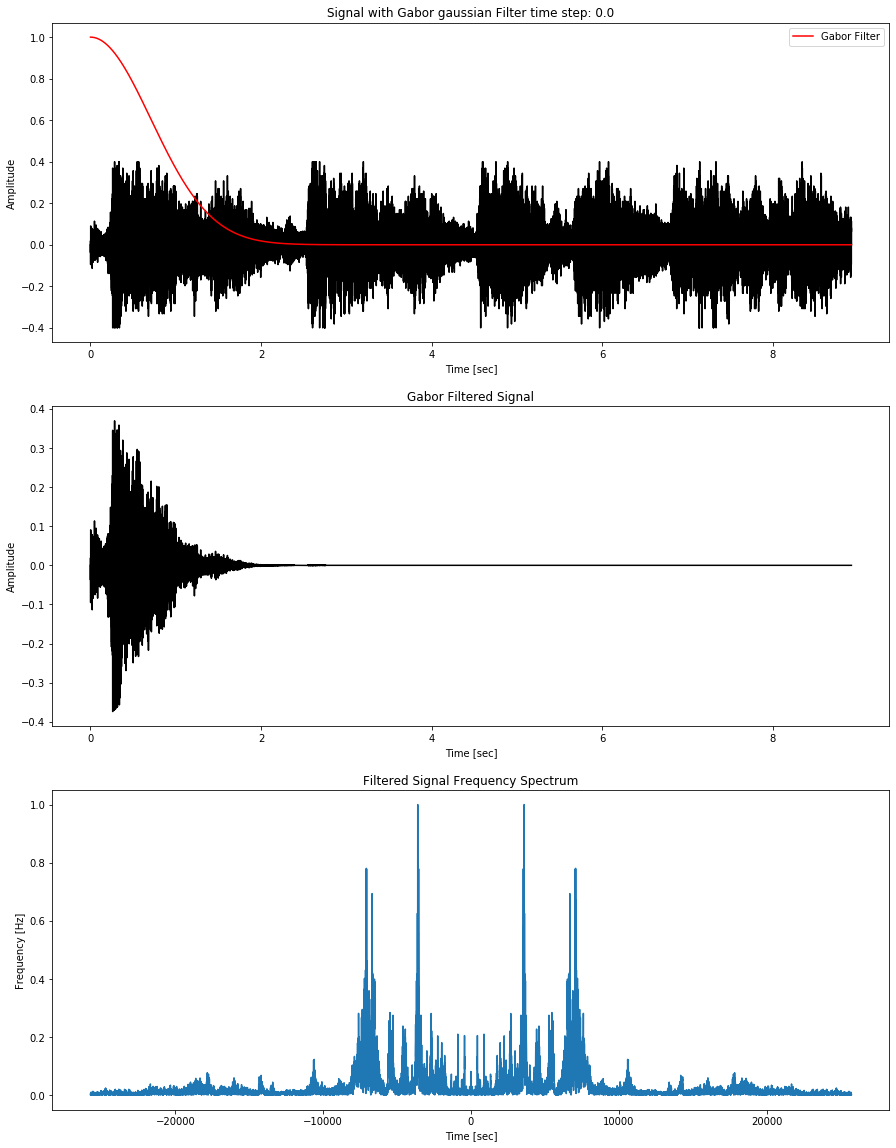

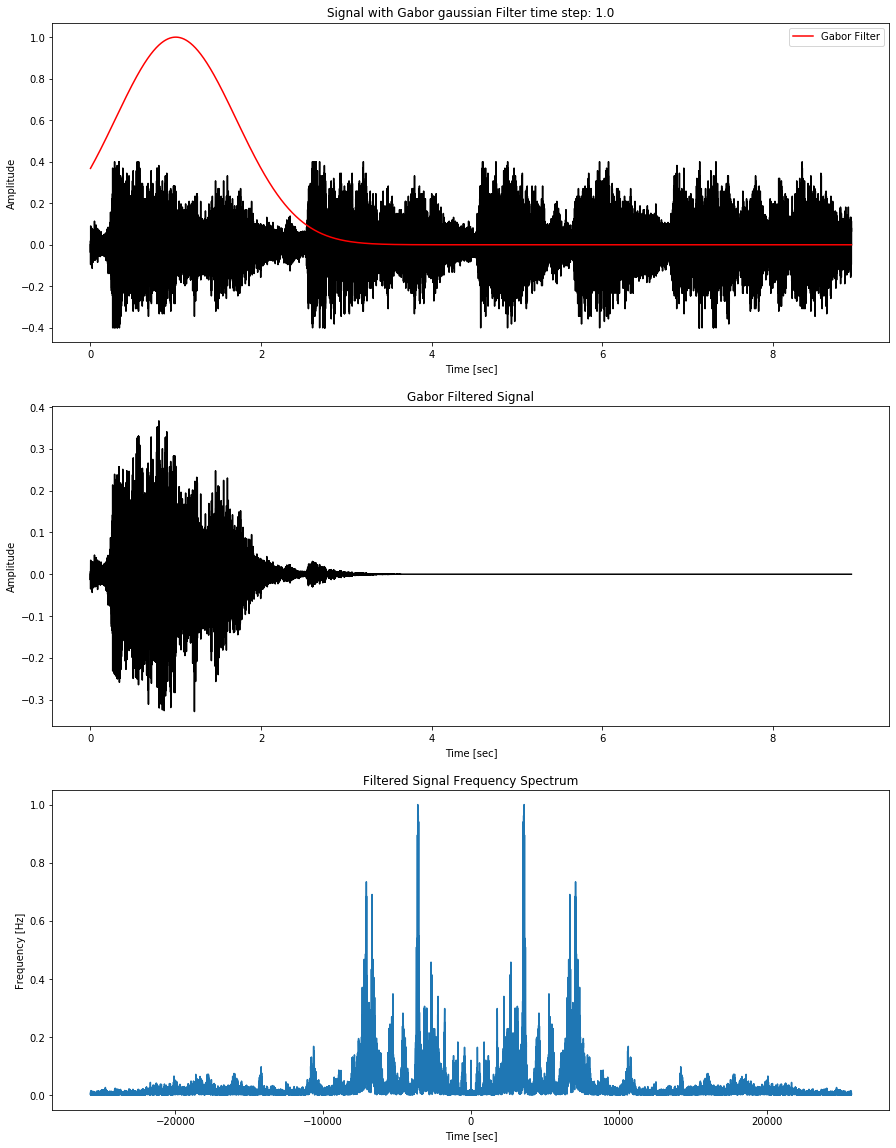

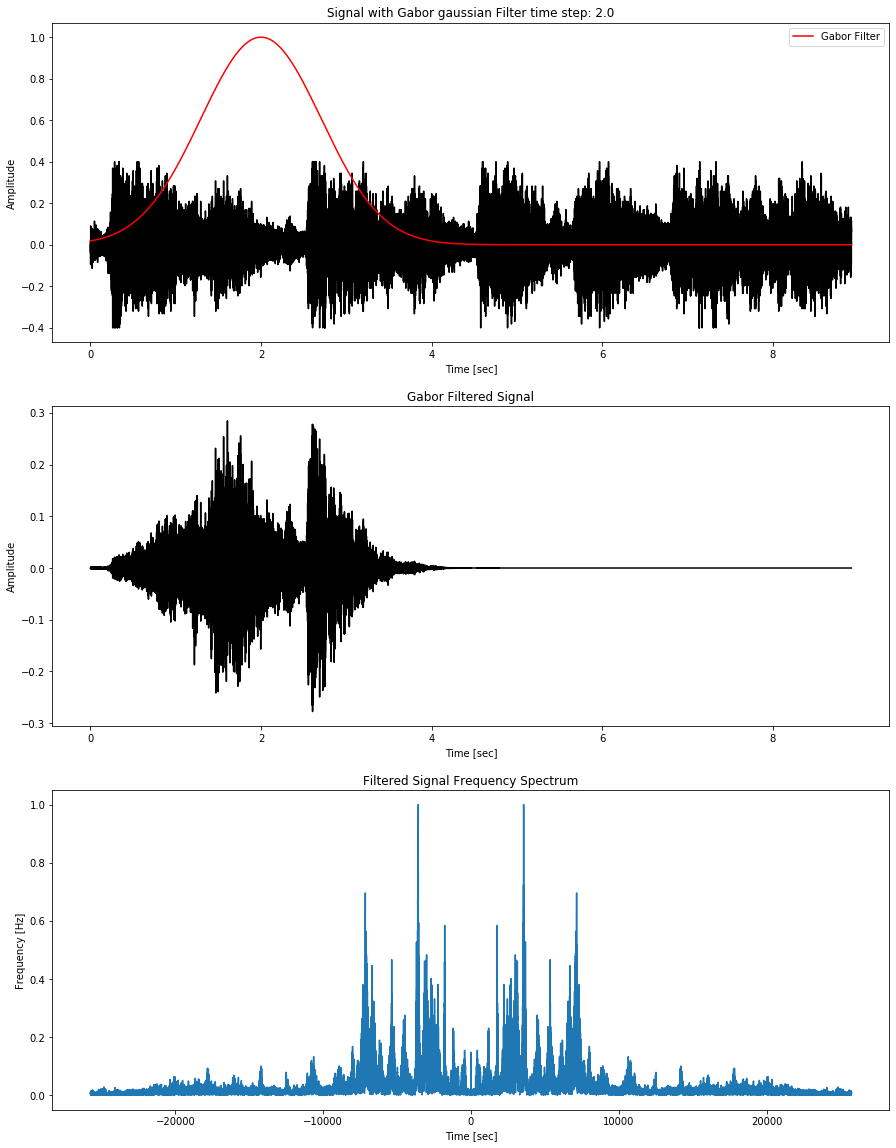

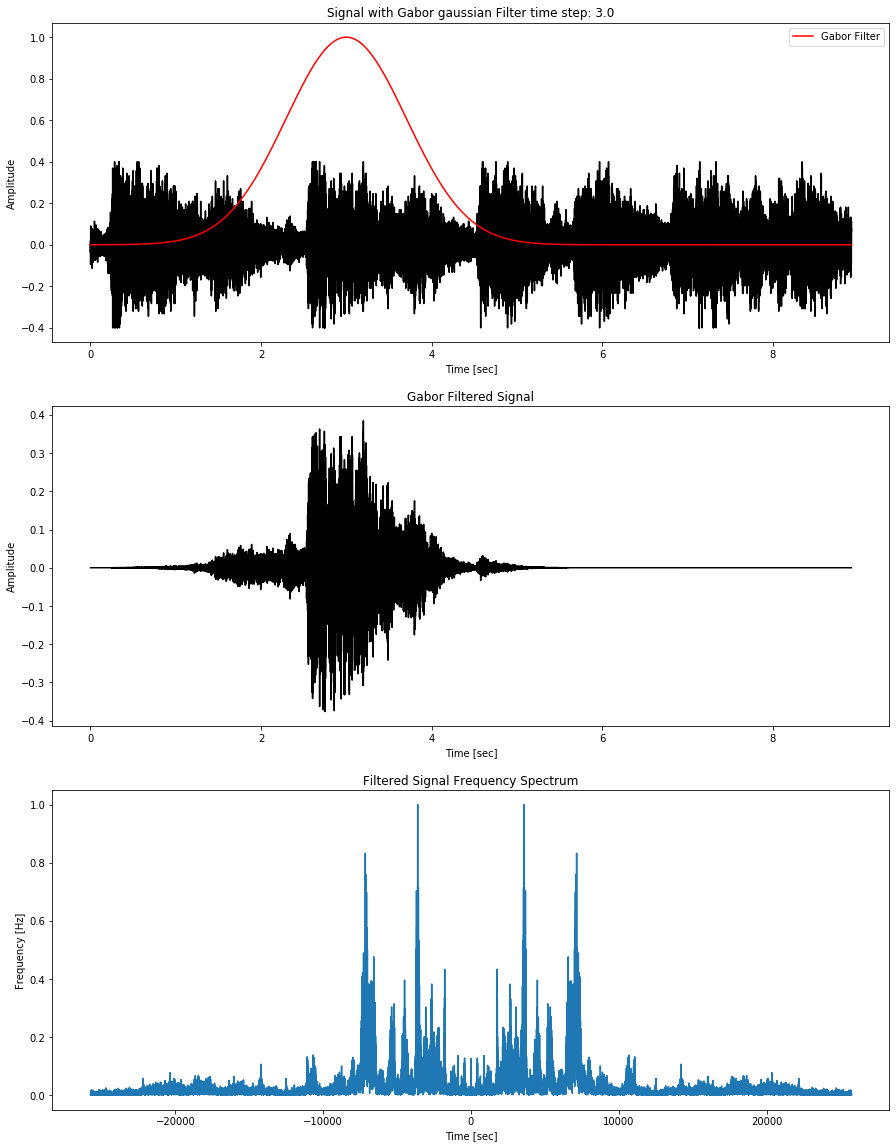

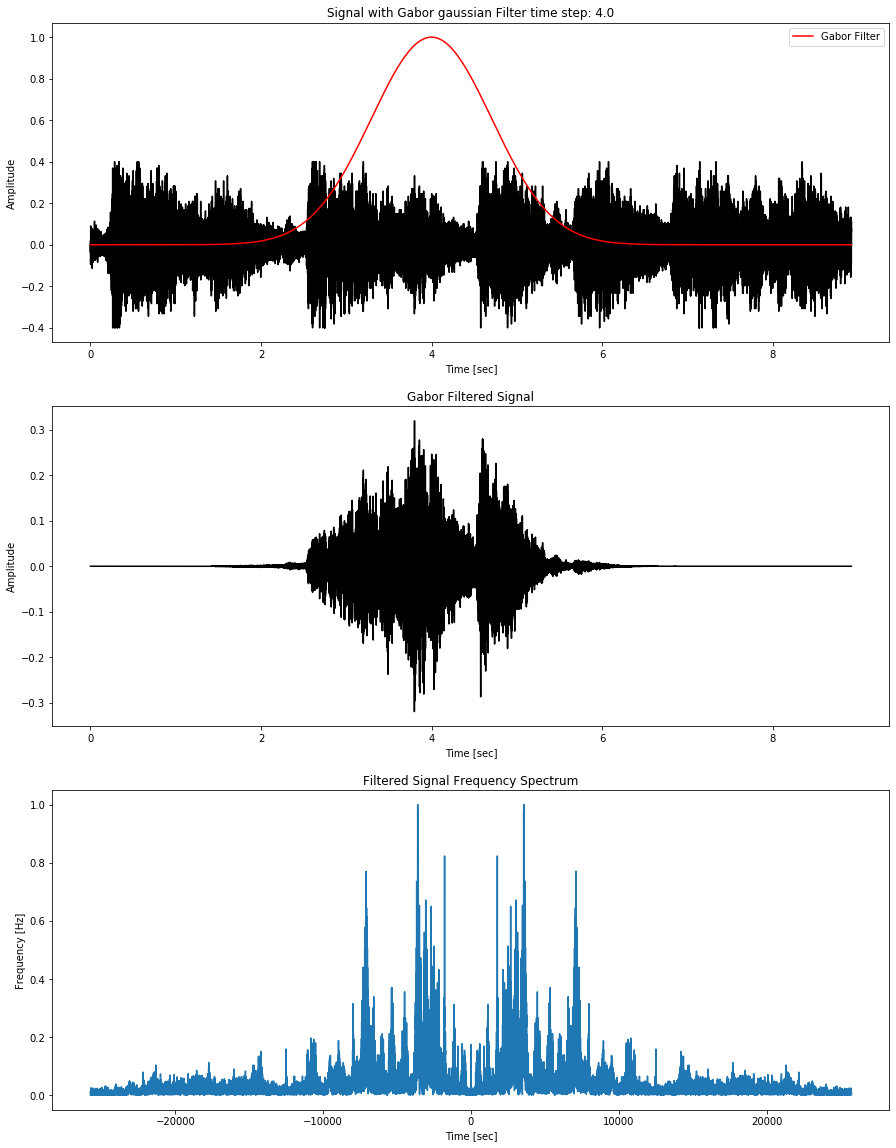

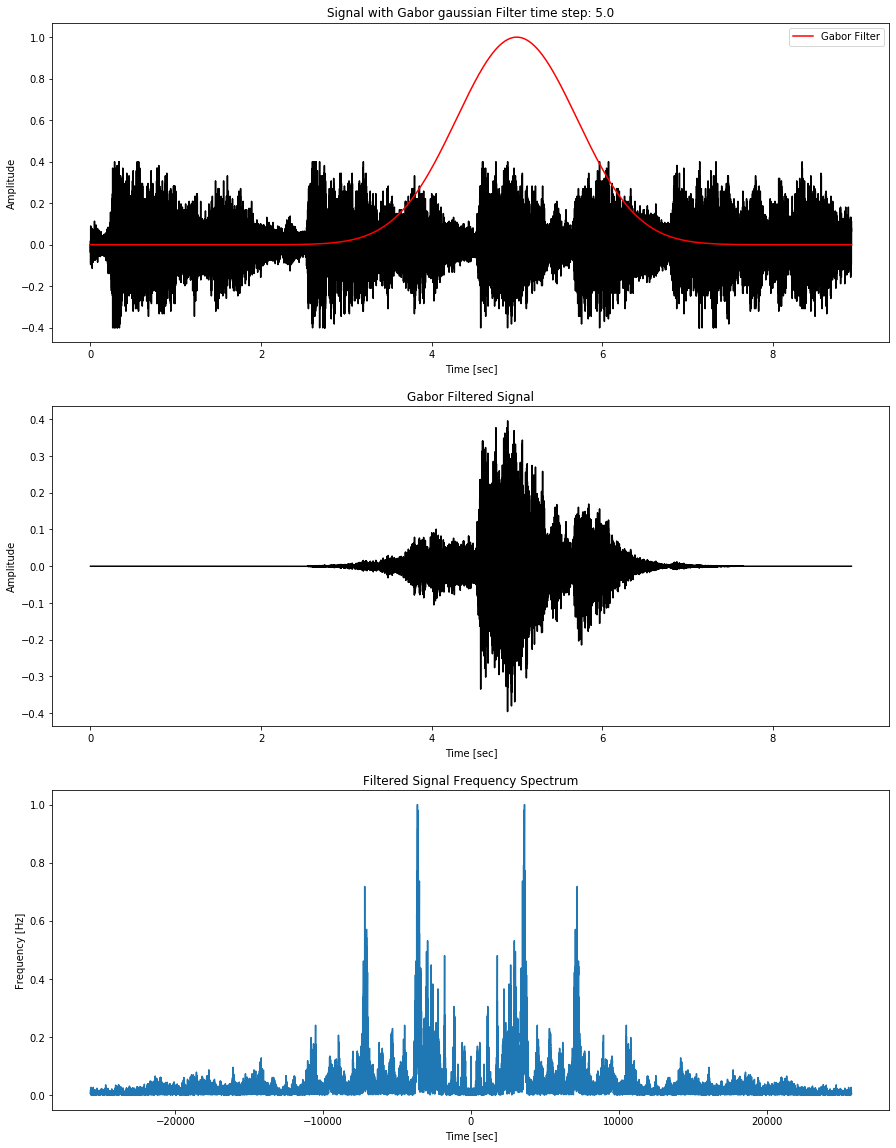

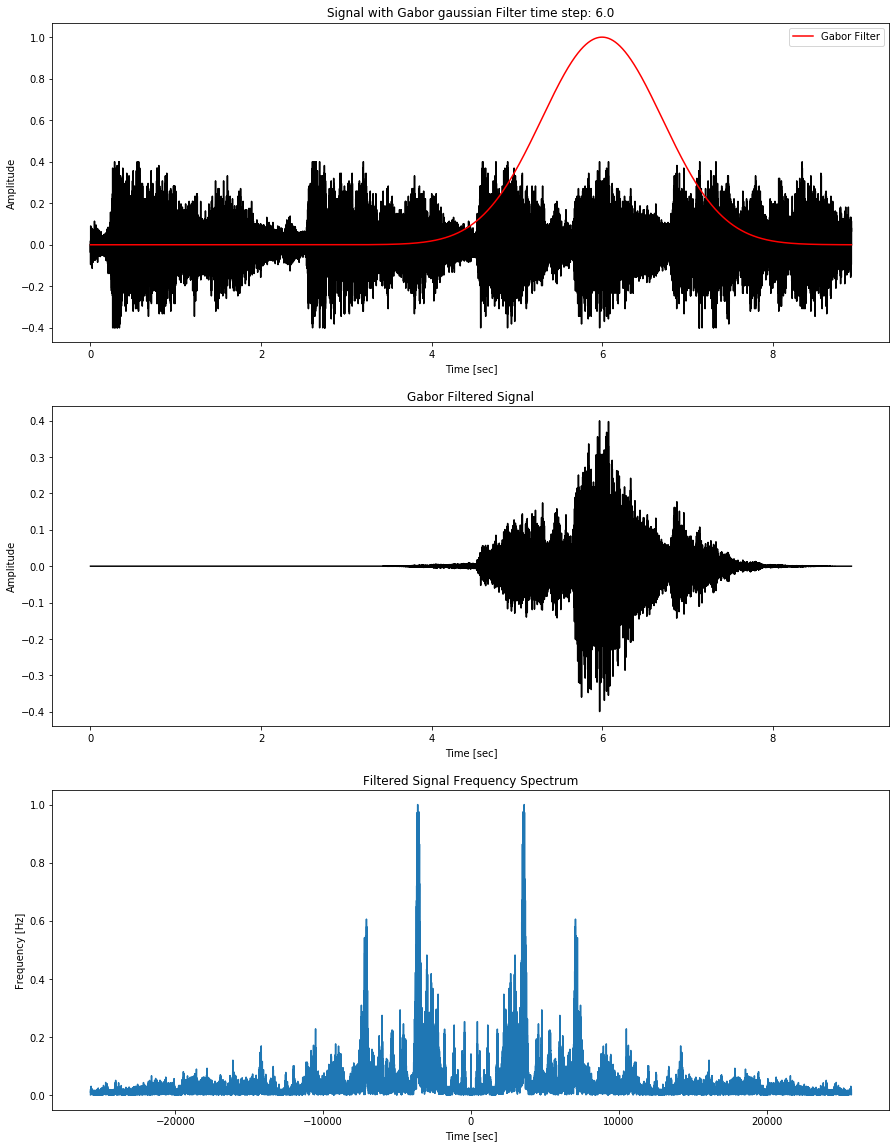

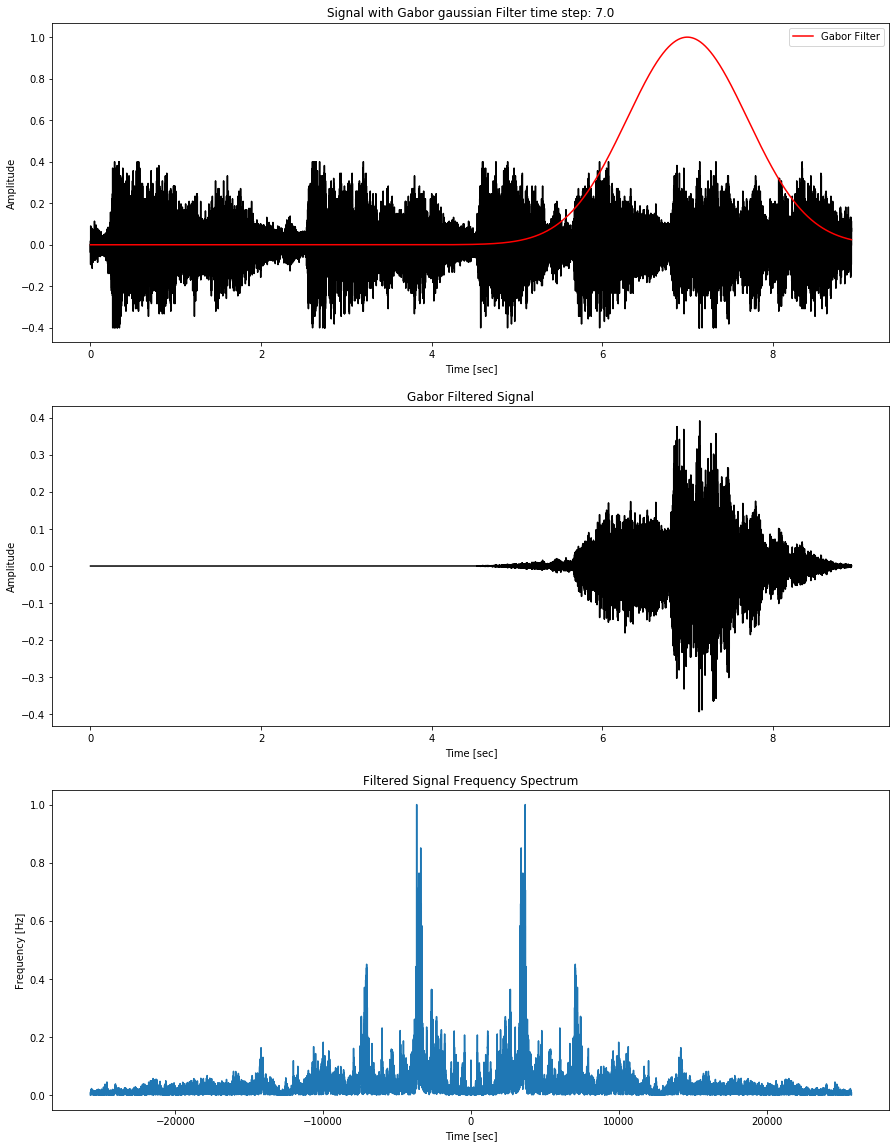

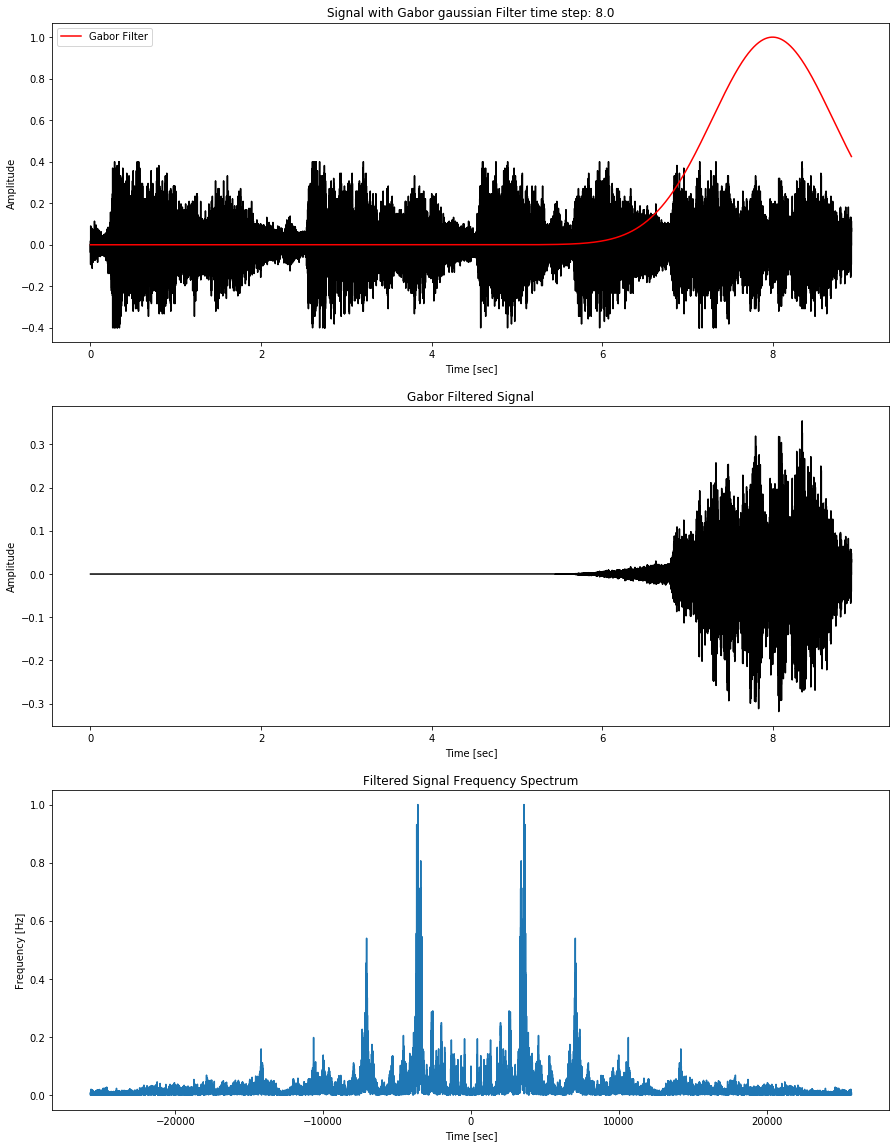

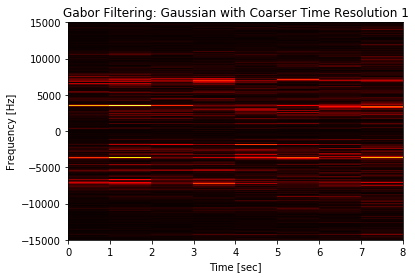

In [42]:
#Try Gaussian filter, with coarser time sampling 1
tres = 1
plot_count = 6
w = 1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='gaussian')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: Gaussian with Coarser Time Resolution 1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

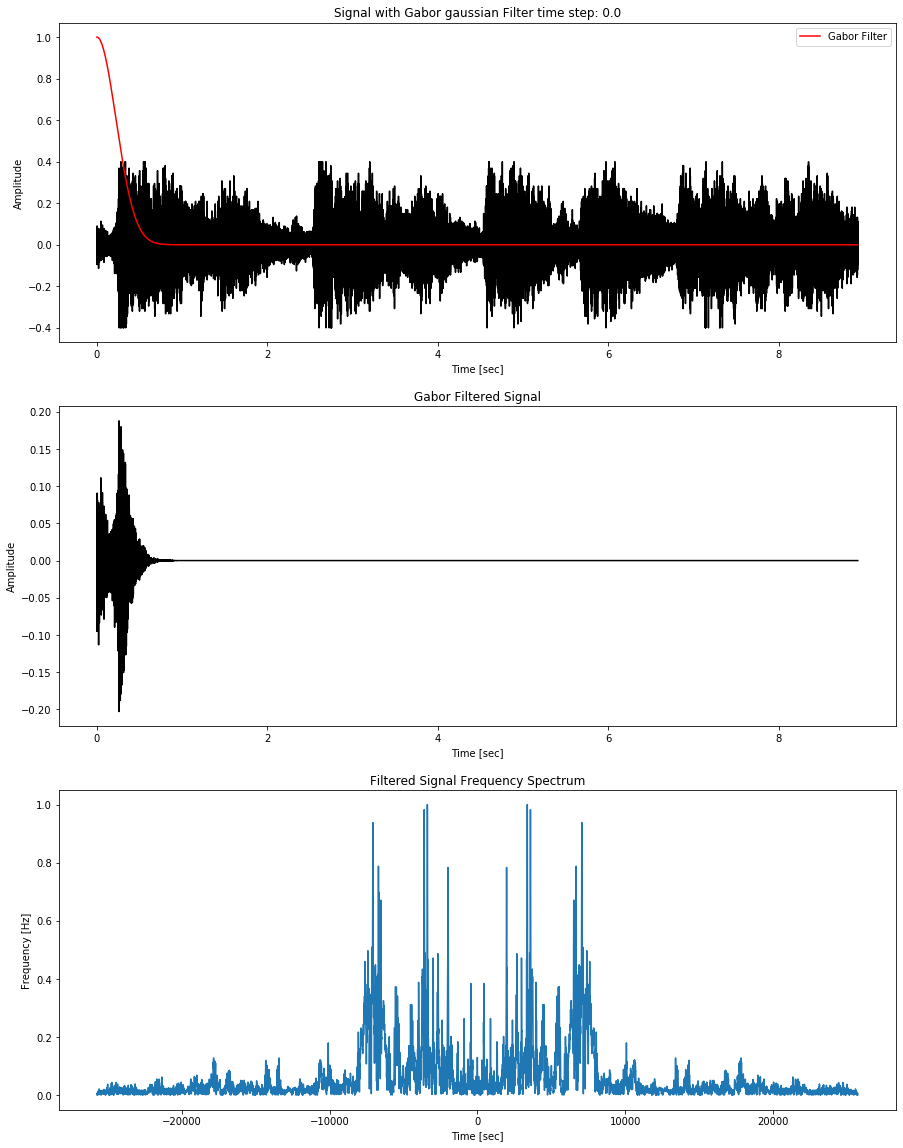

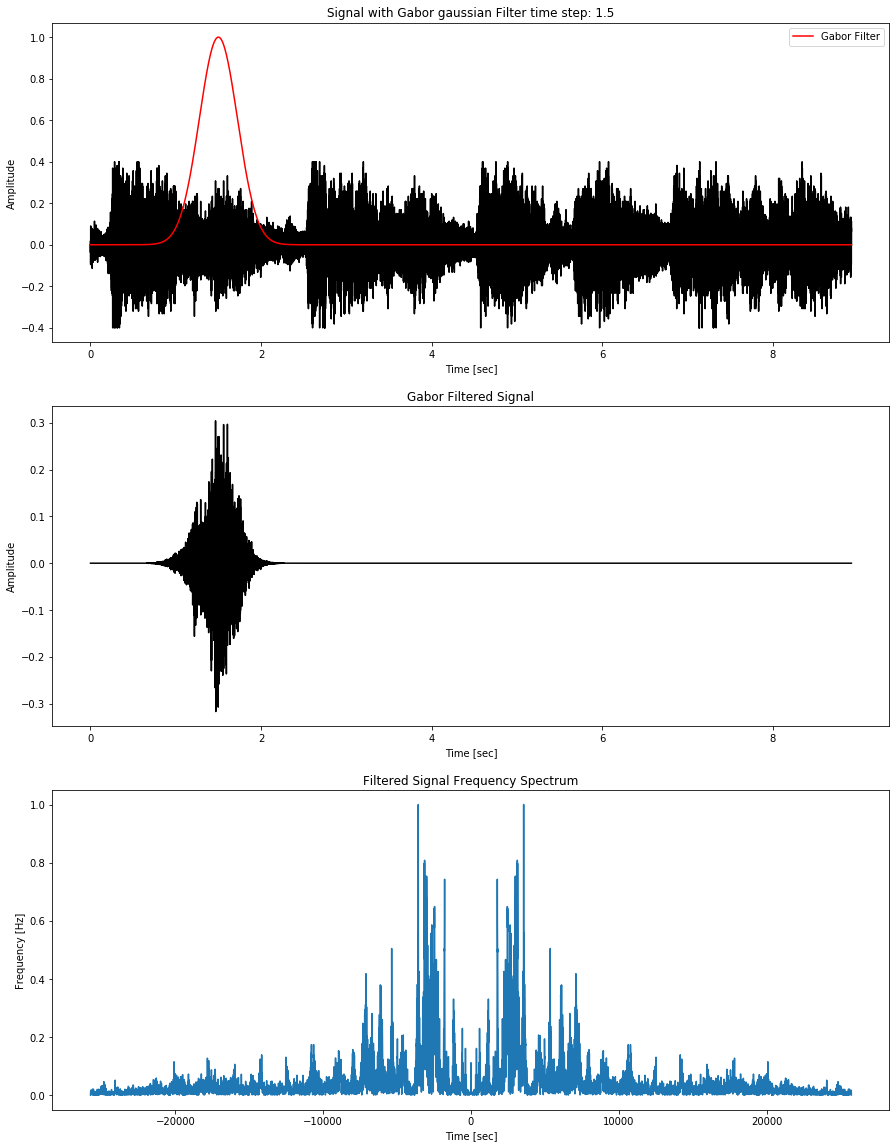

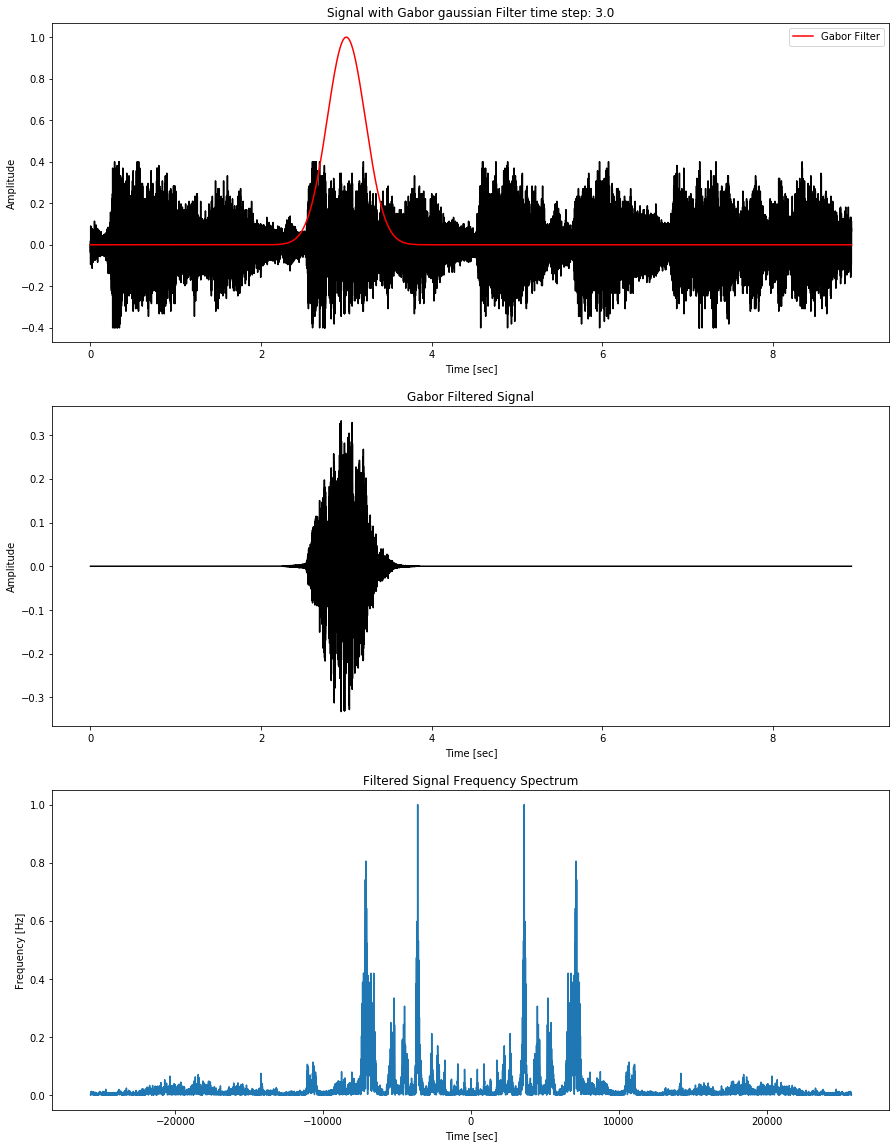

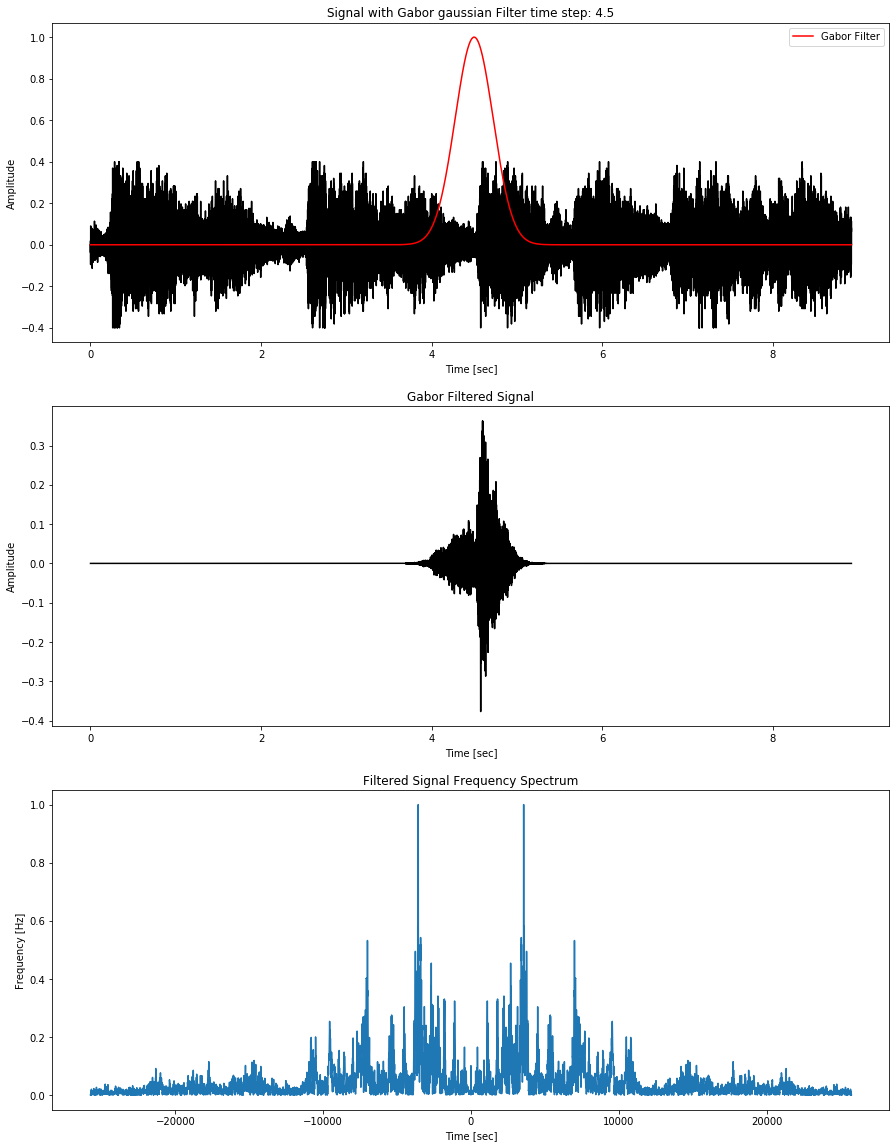

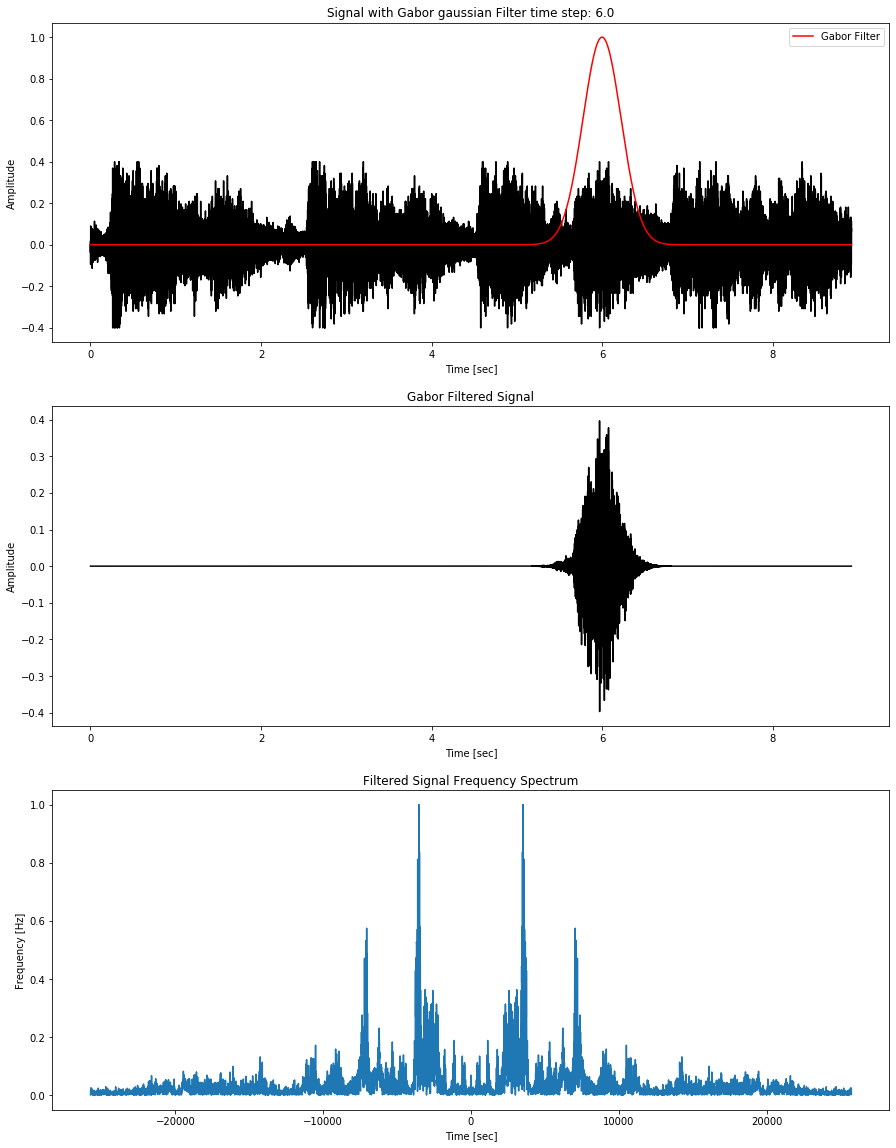

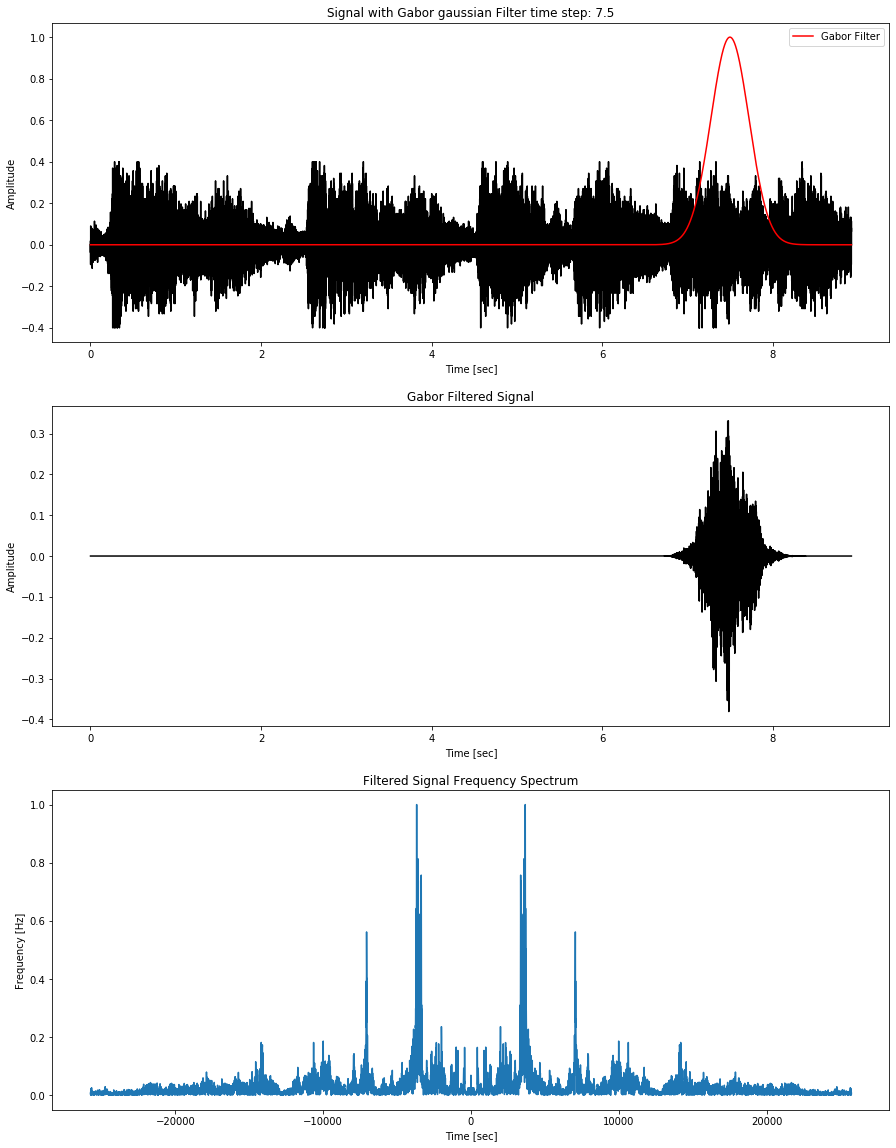

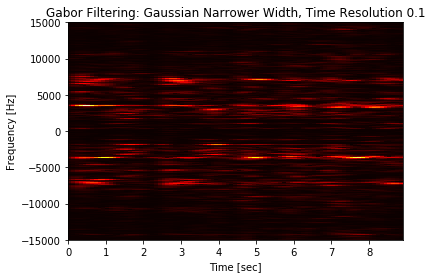

In [43]:
#Try Narrower Gaussian filter, time sampling 0.1
tres = 0.1
plot_count = 6
w = 10
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='gaussian')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: Gaussian Narrower Width, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

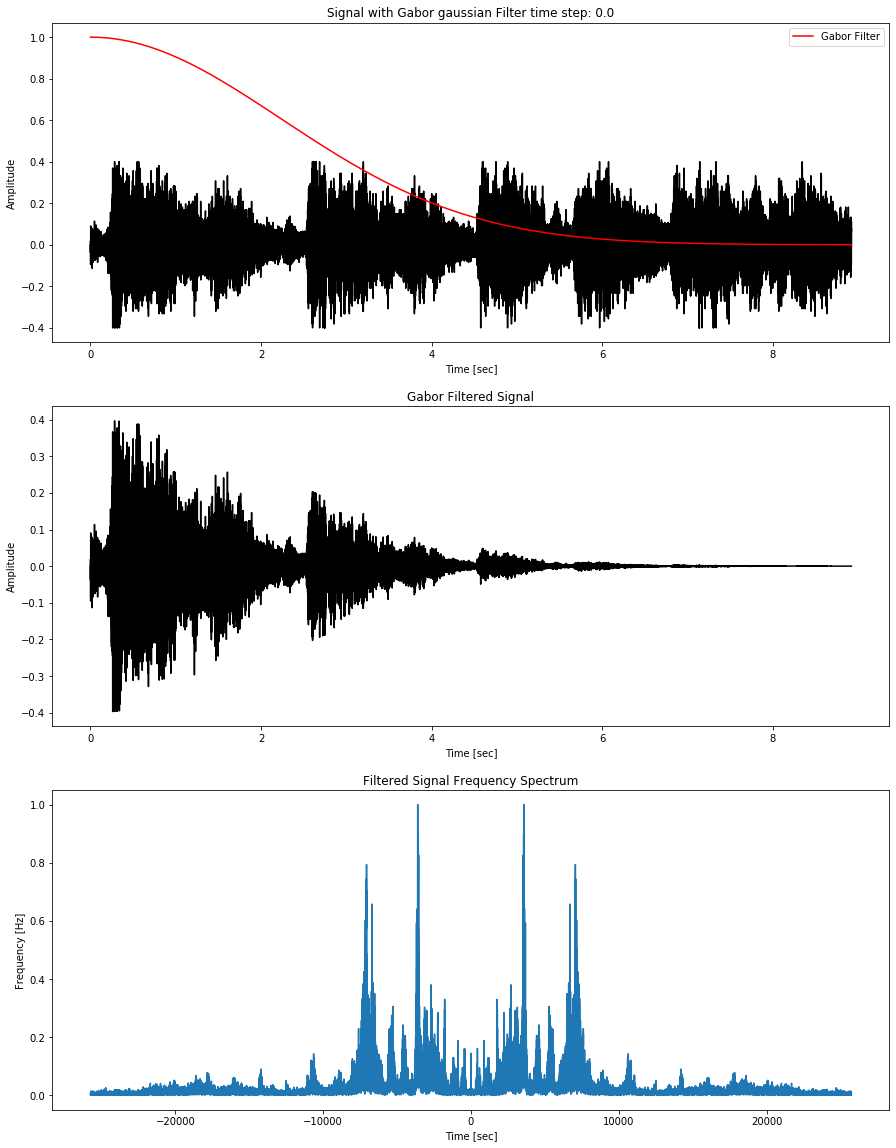

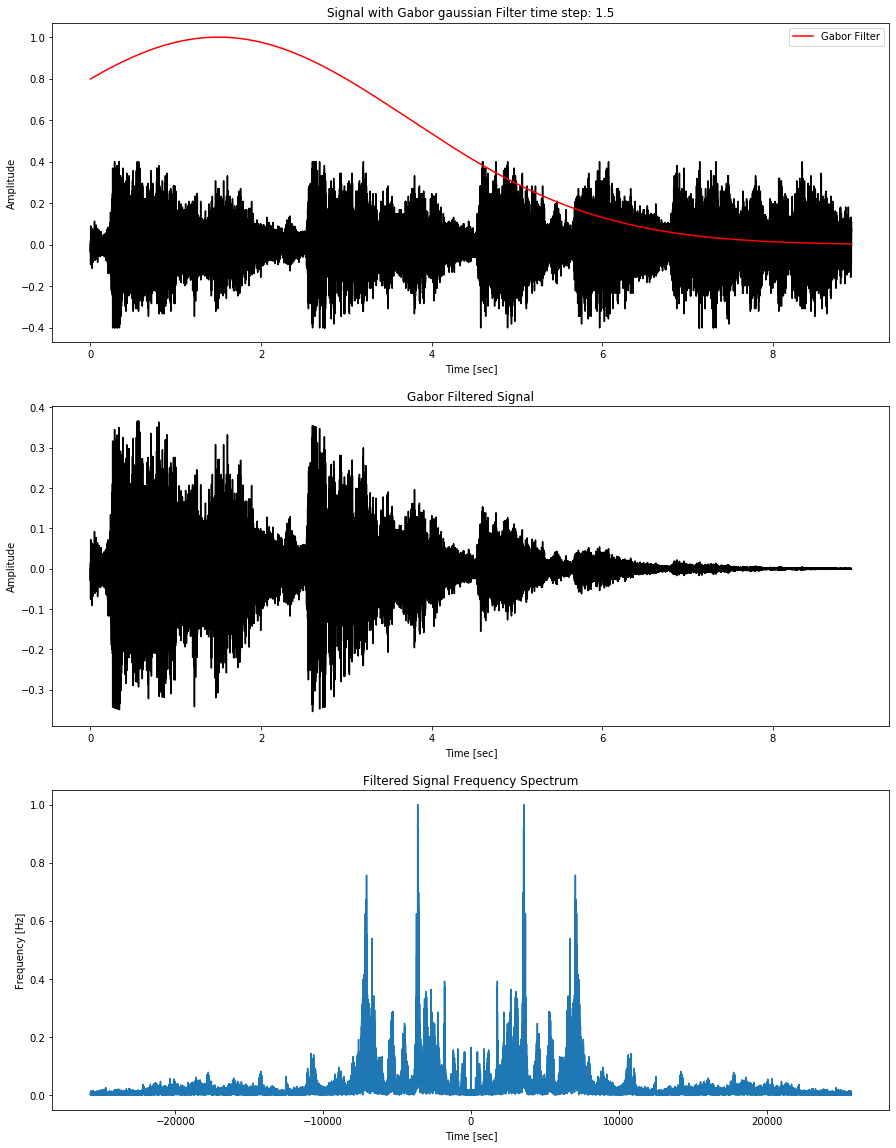

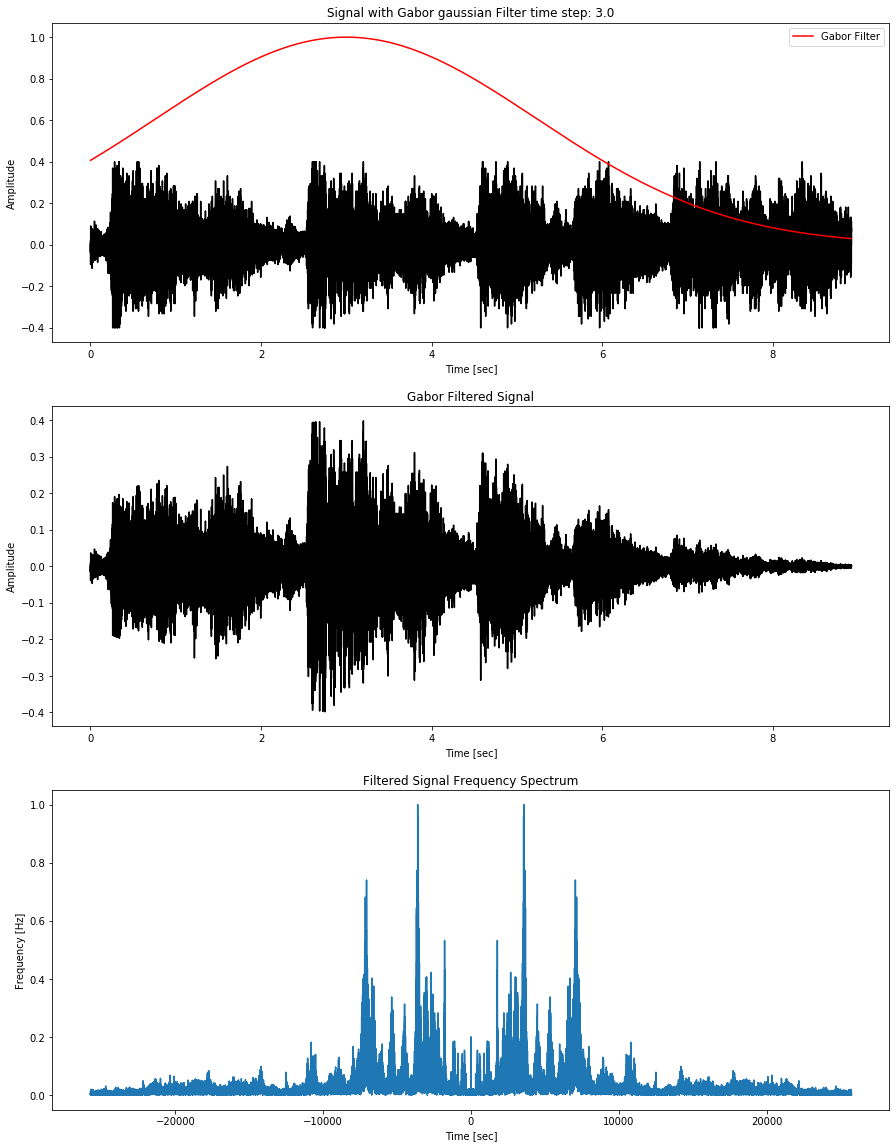

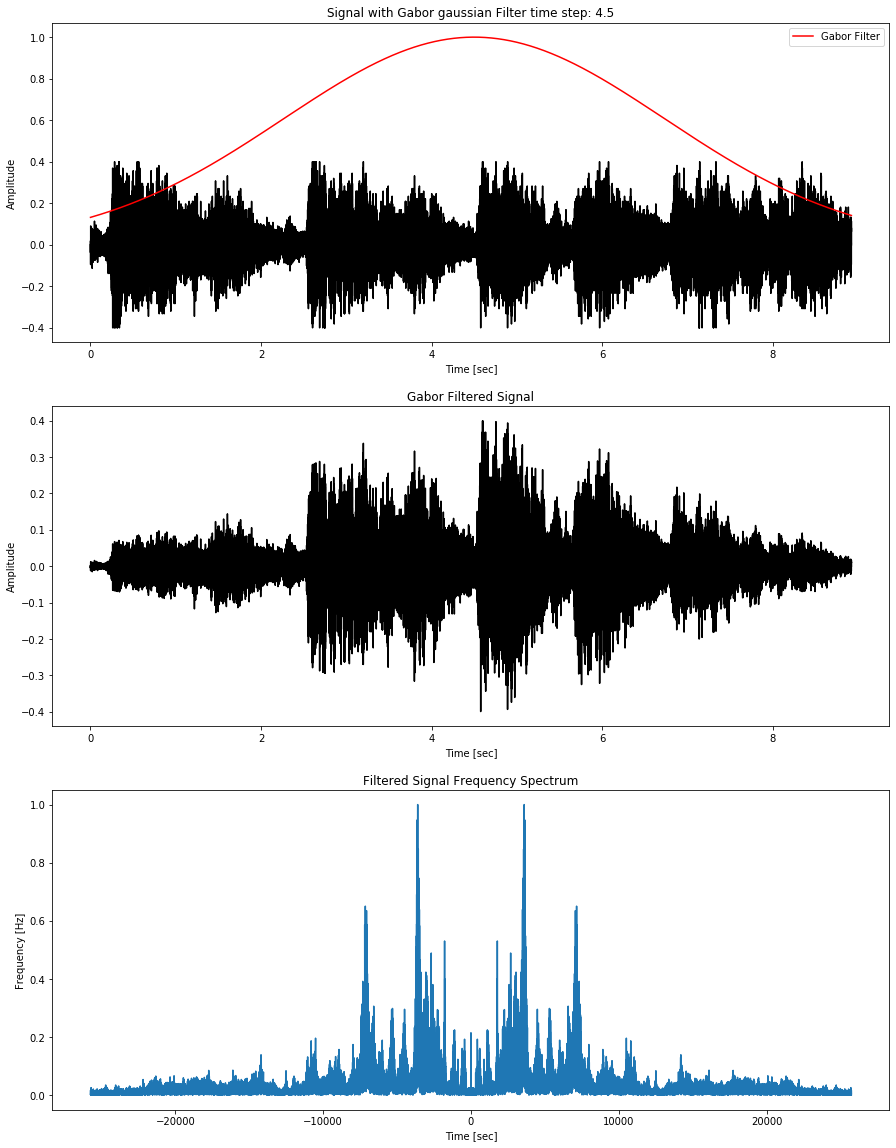

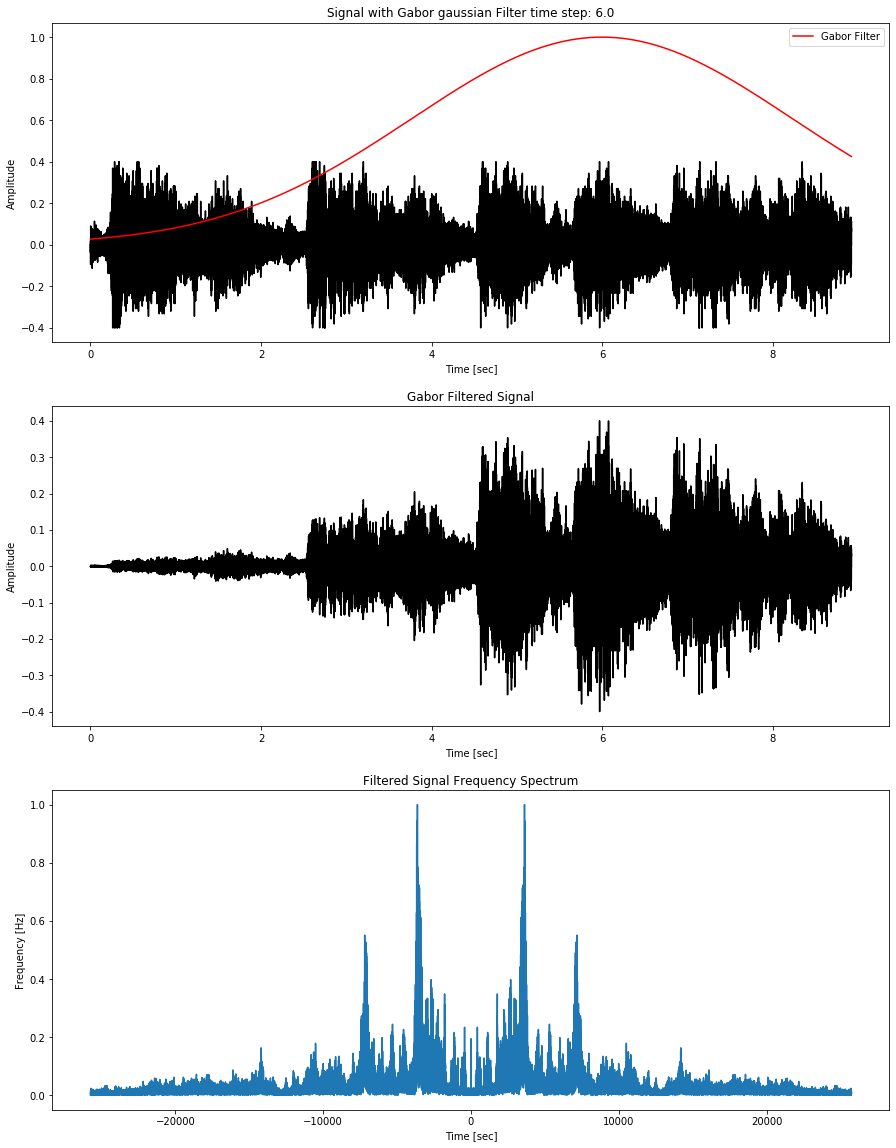

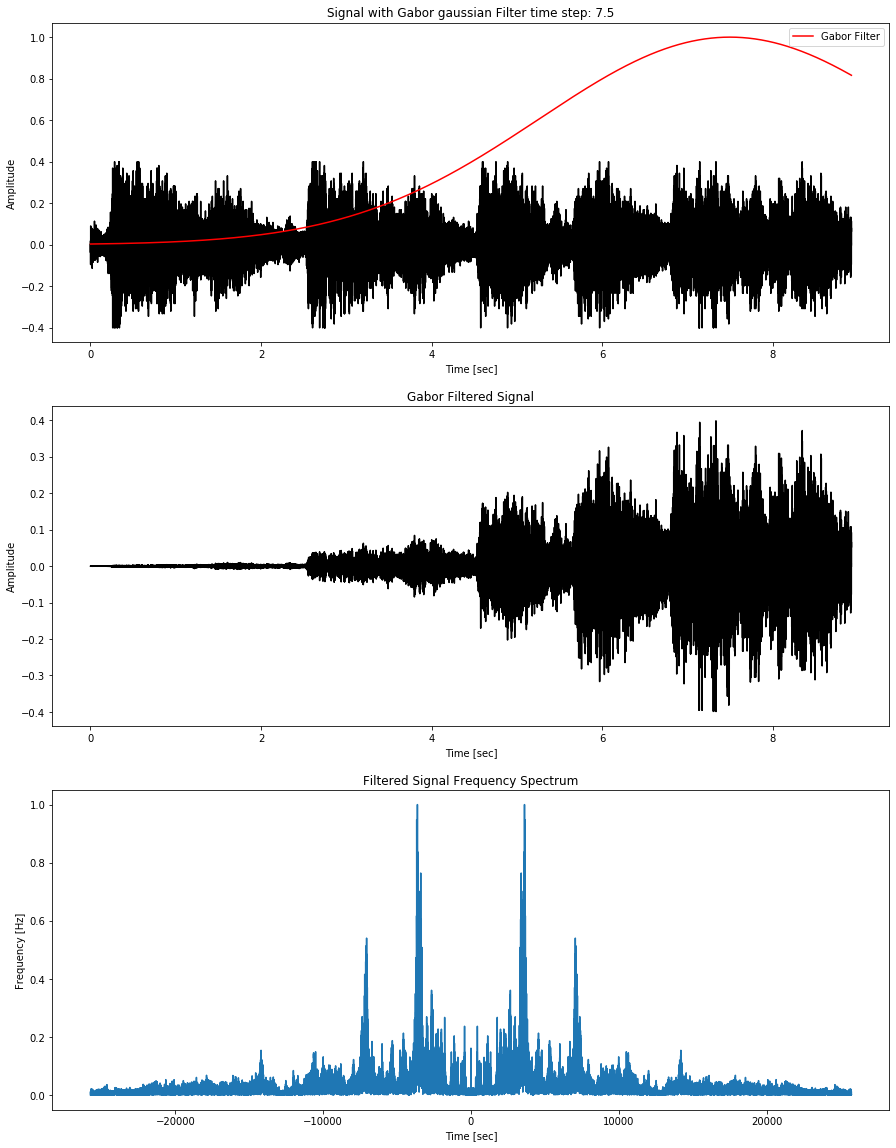

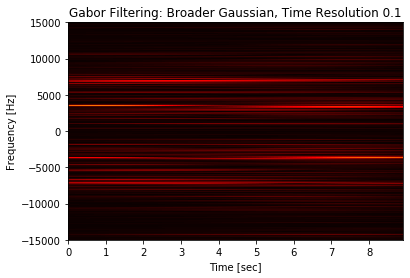

In [44]:
#Try wider Gaussian filter, time sampling 0.1
tres = 0.1
plot_count = 6
w = 0.1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='gaussian')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: Broader Gaussian, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

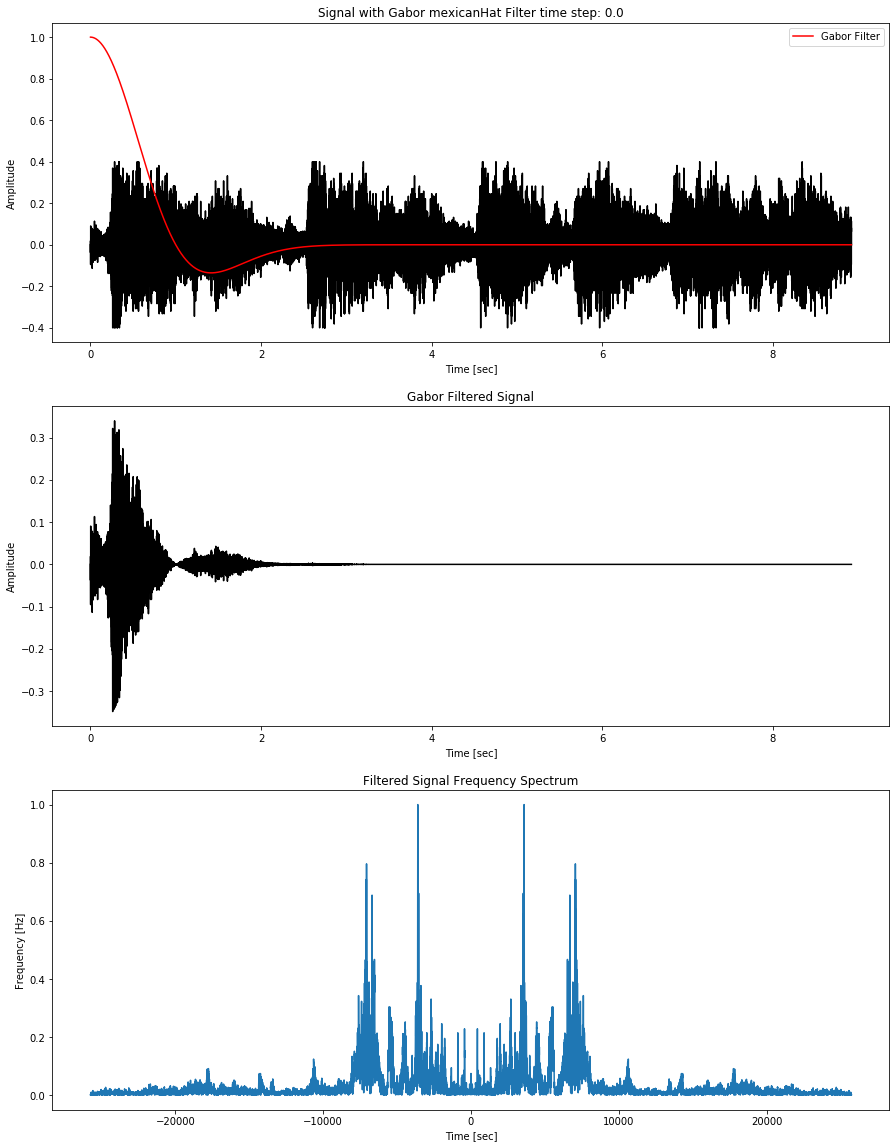

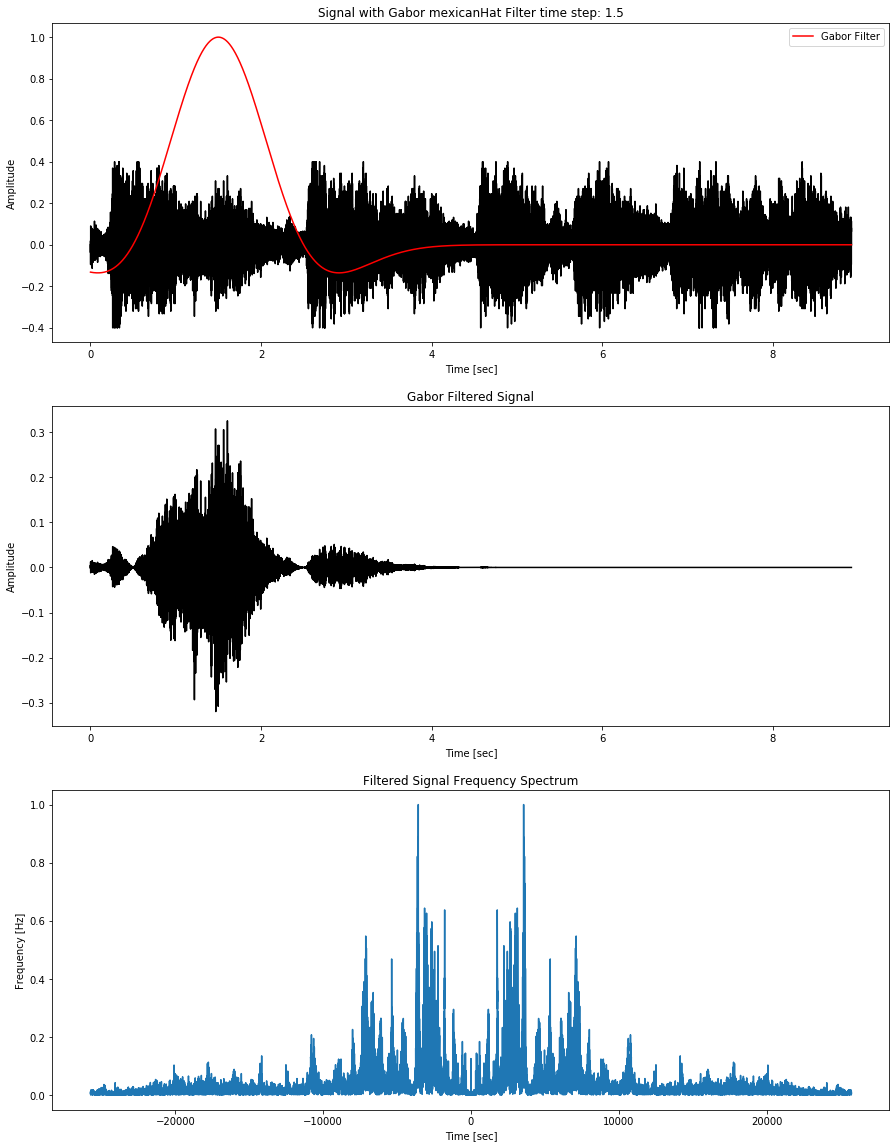

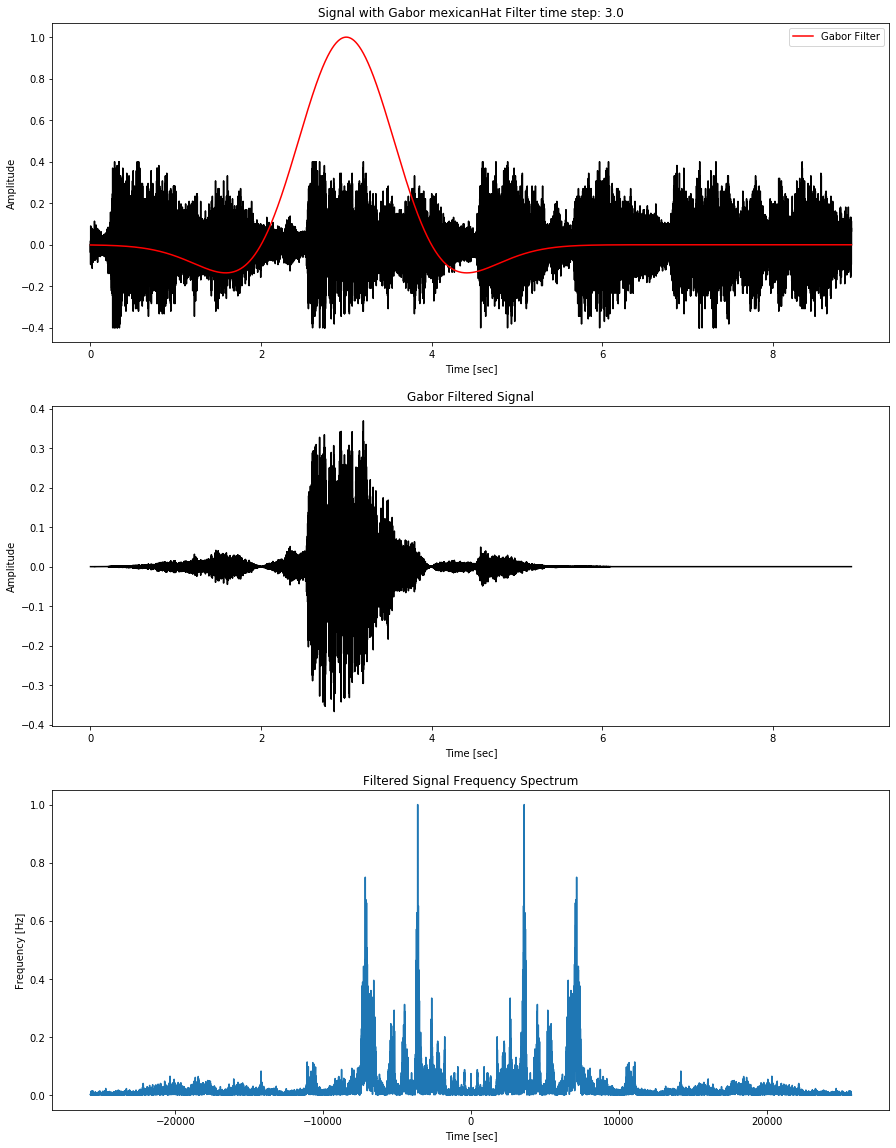

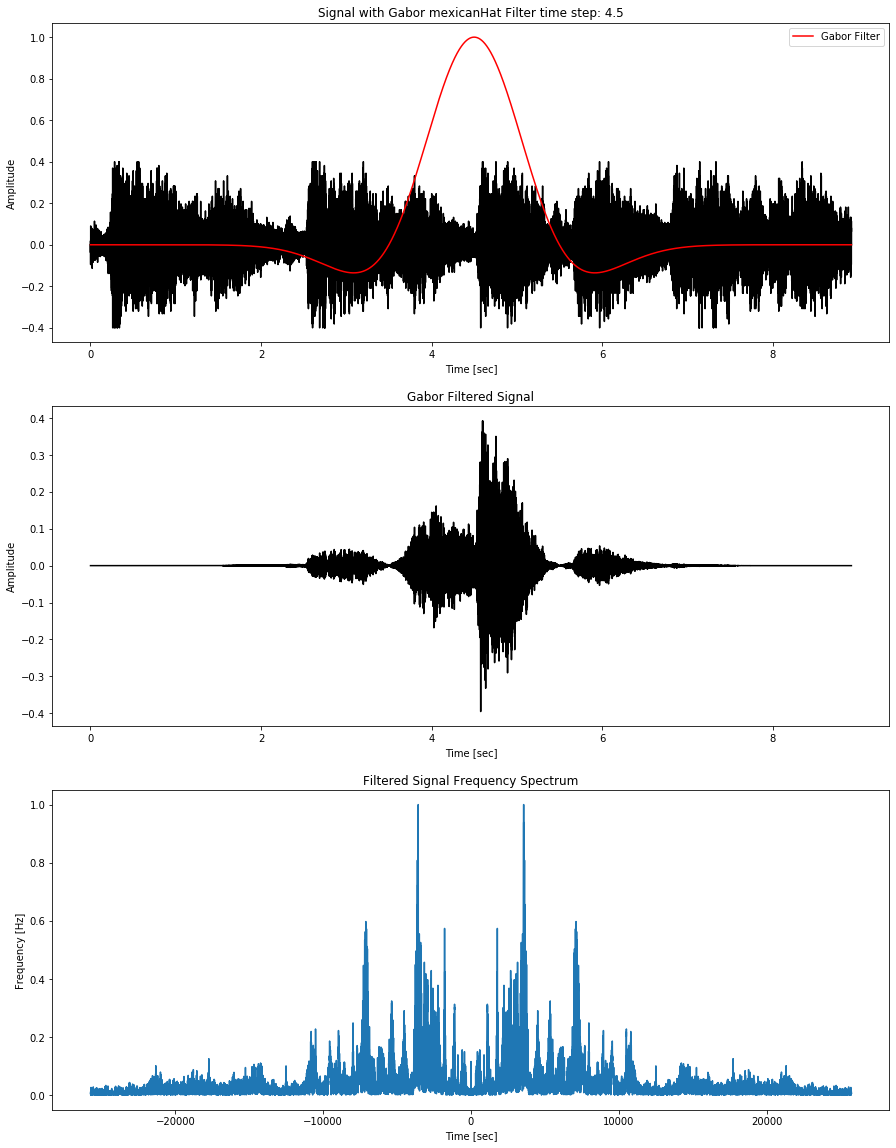

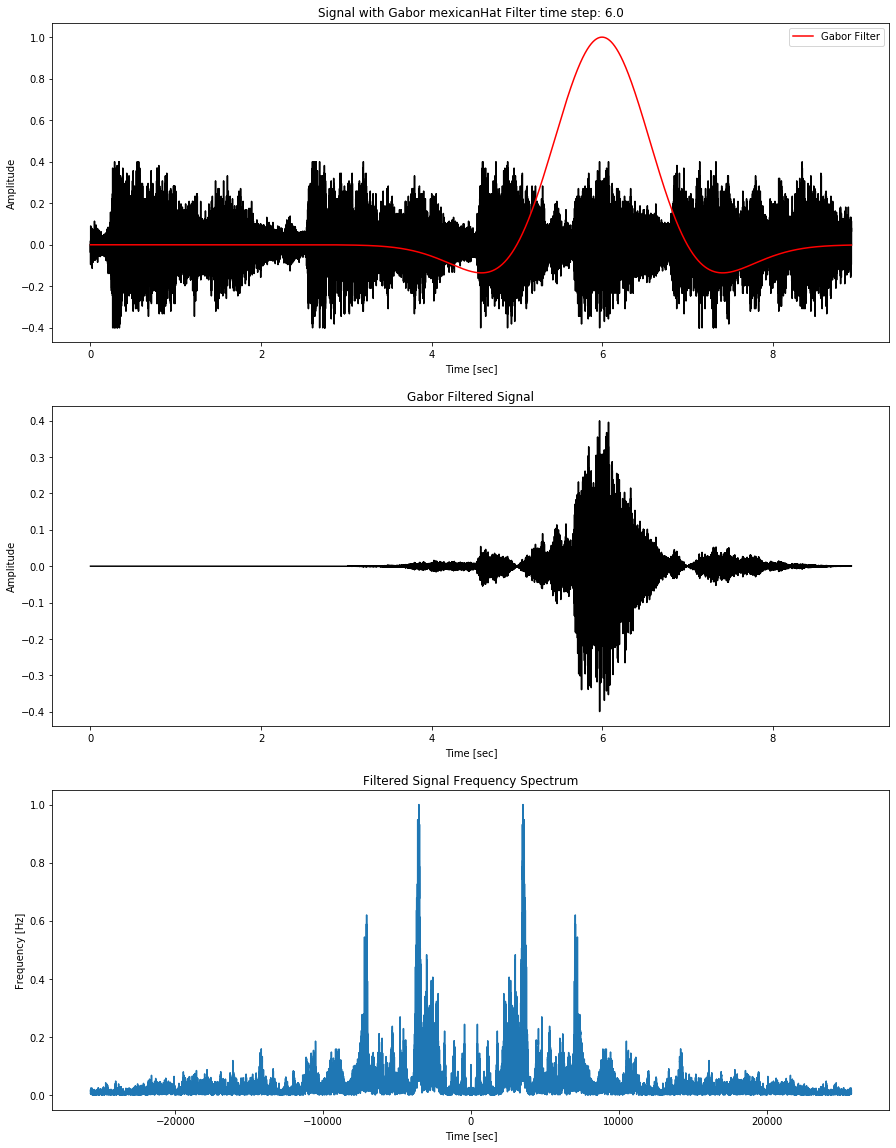

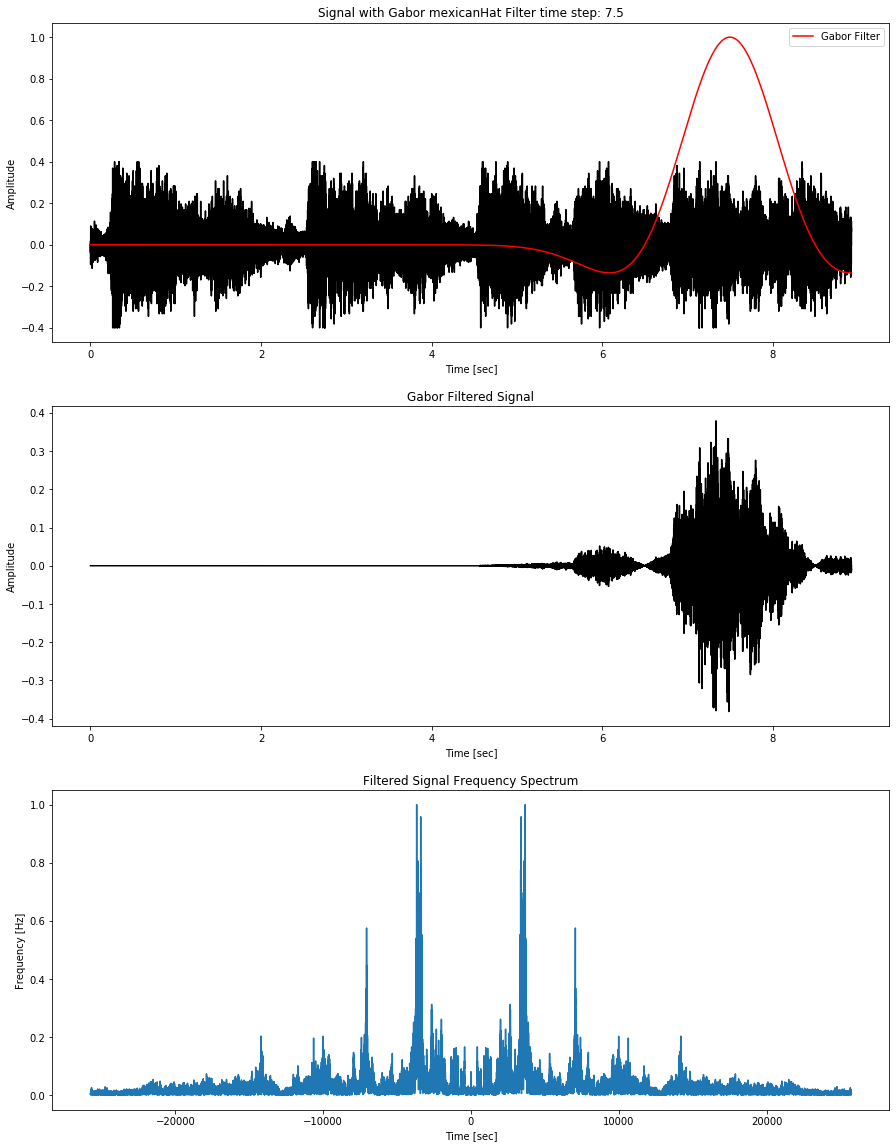

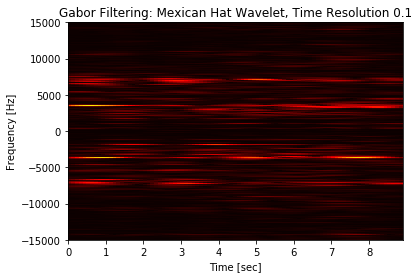

In [45]:
#Try Mexican Hat wavelet, time sampling 0.1
tres = 0.1
plot_count = 6
w = 1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='mexicanHat')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: Mexican Hat Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

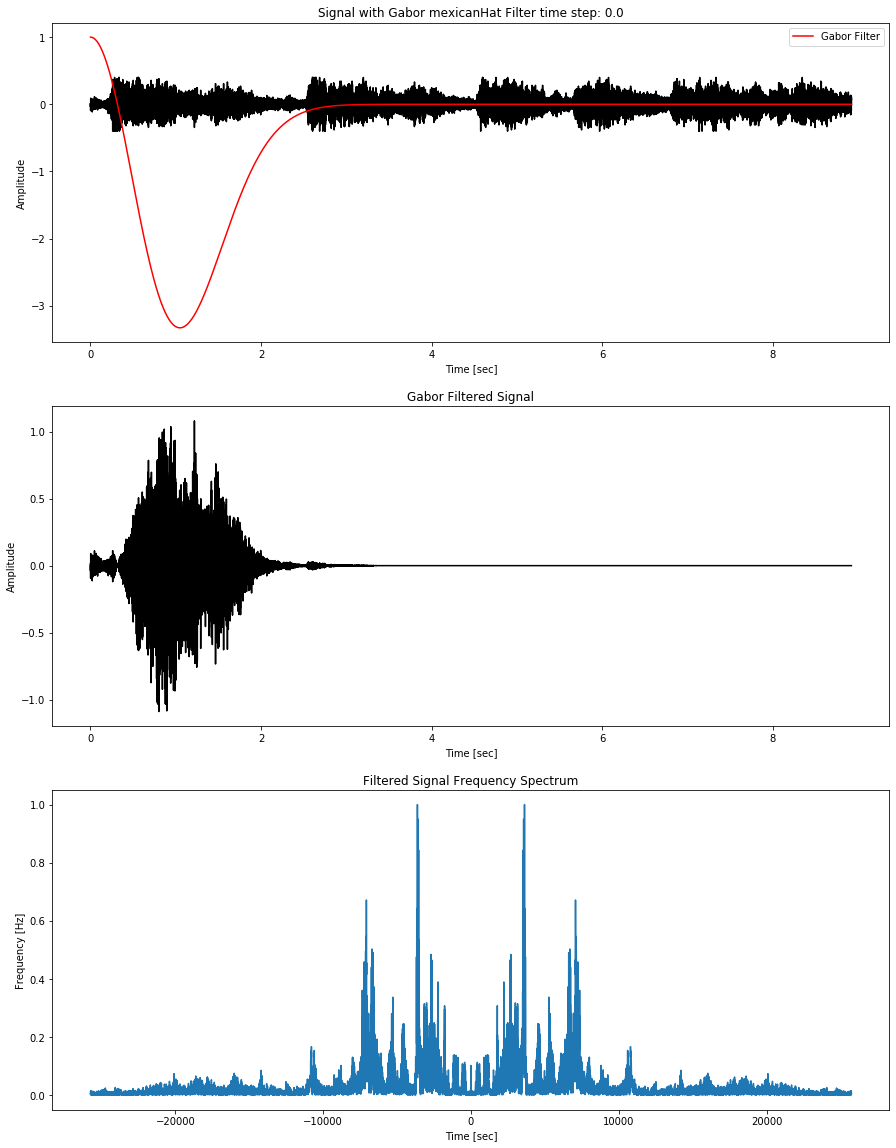

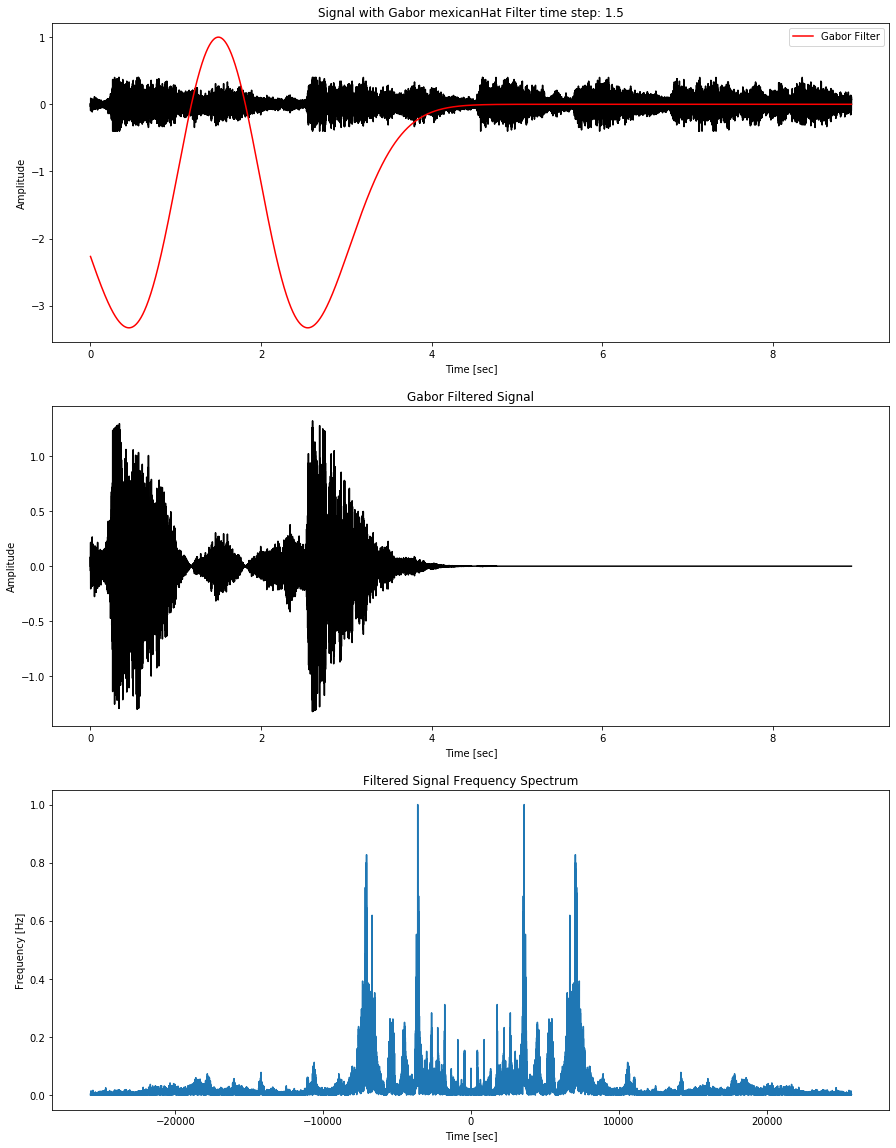

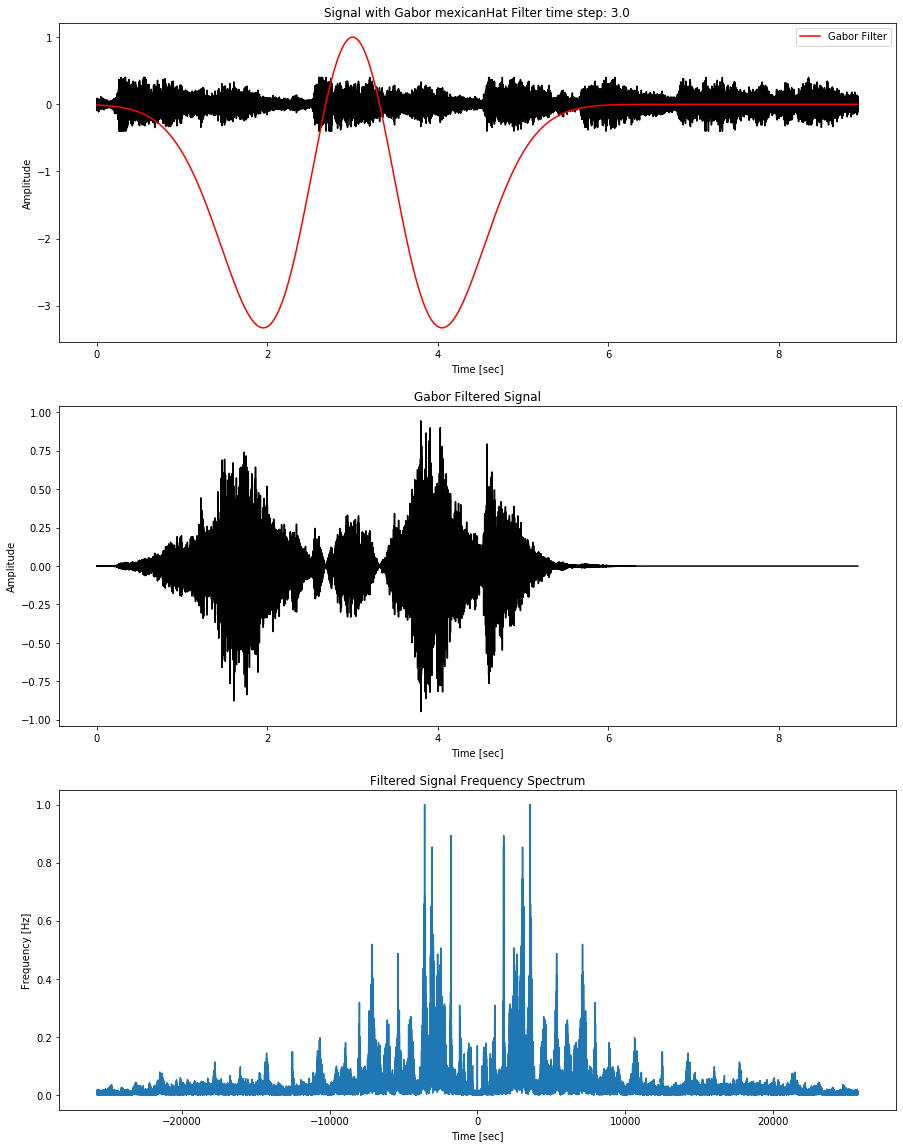

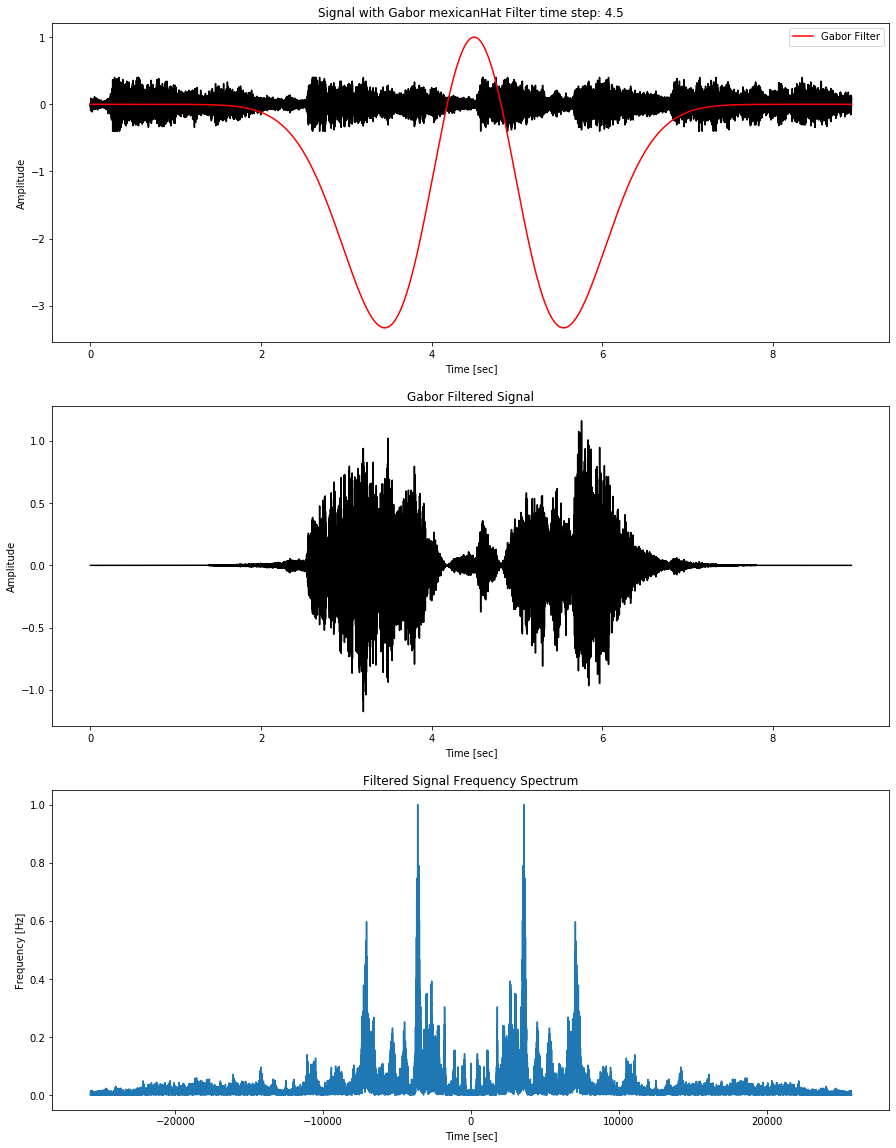

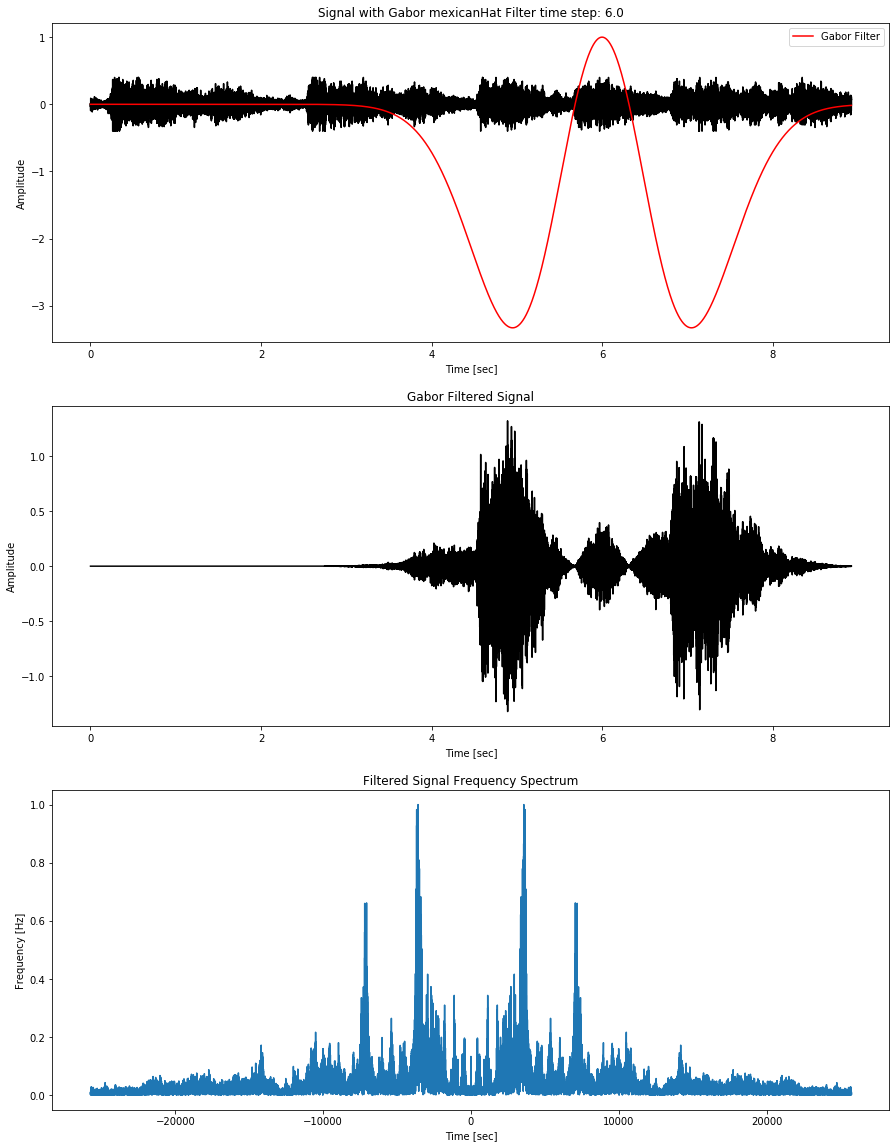

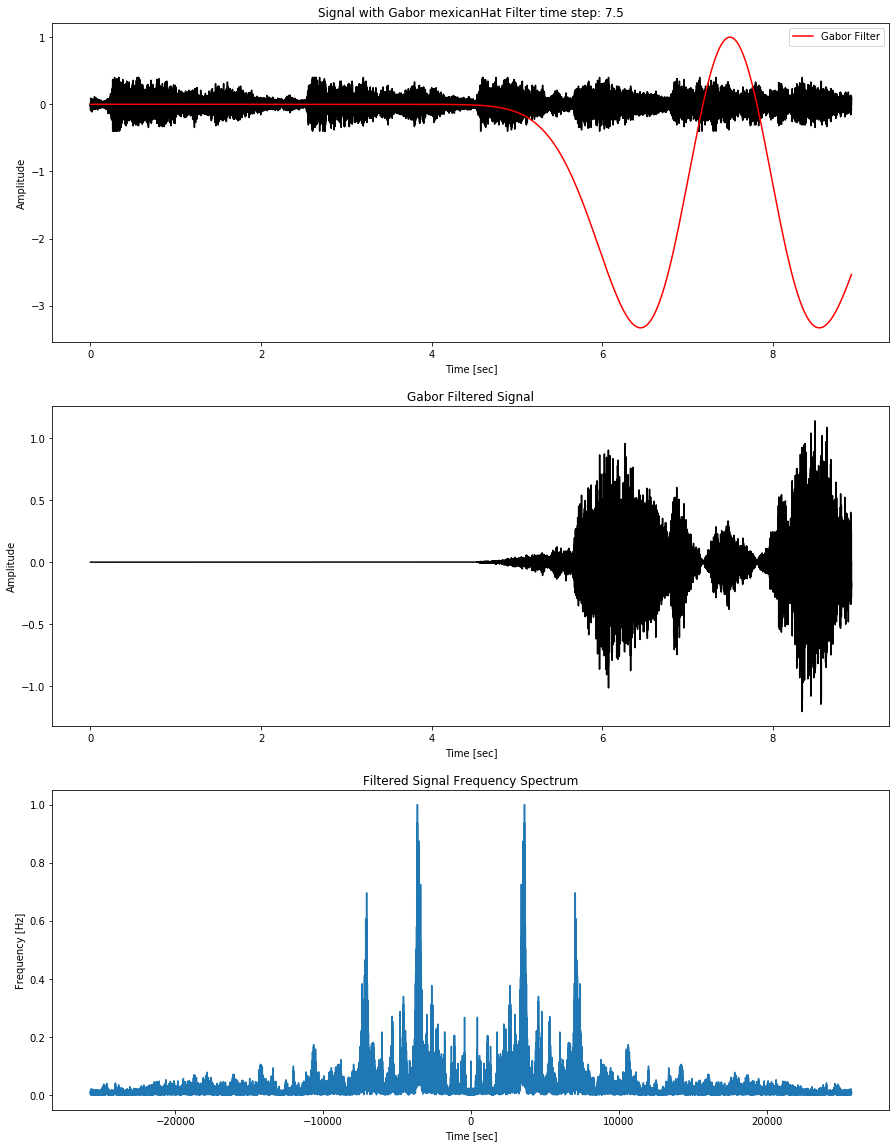

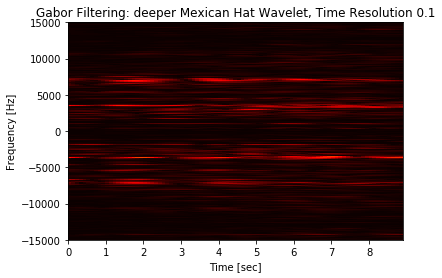

In [46]:
#Try bigger Mexican Hat wavelet, time sampling 0.1
tres = 0.1
plot_count = 6
w = 10
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='mexicanHat')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: deeper Mexican Hat Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

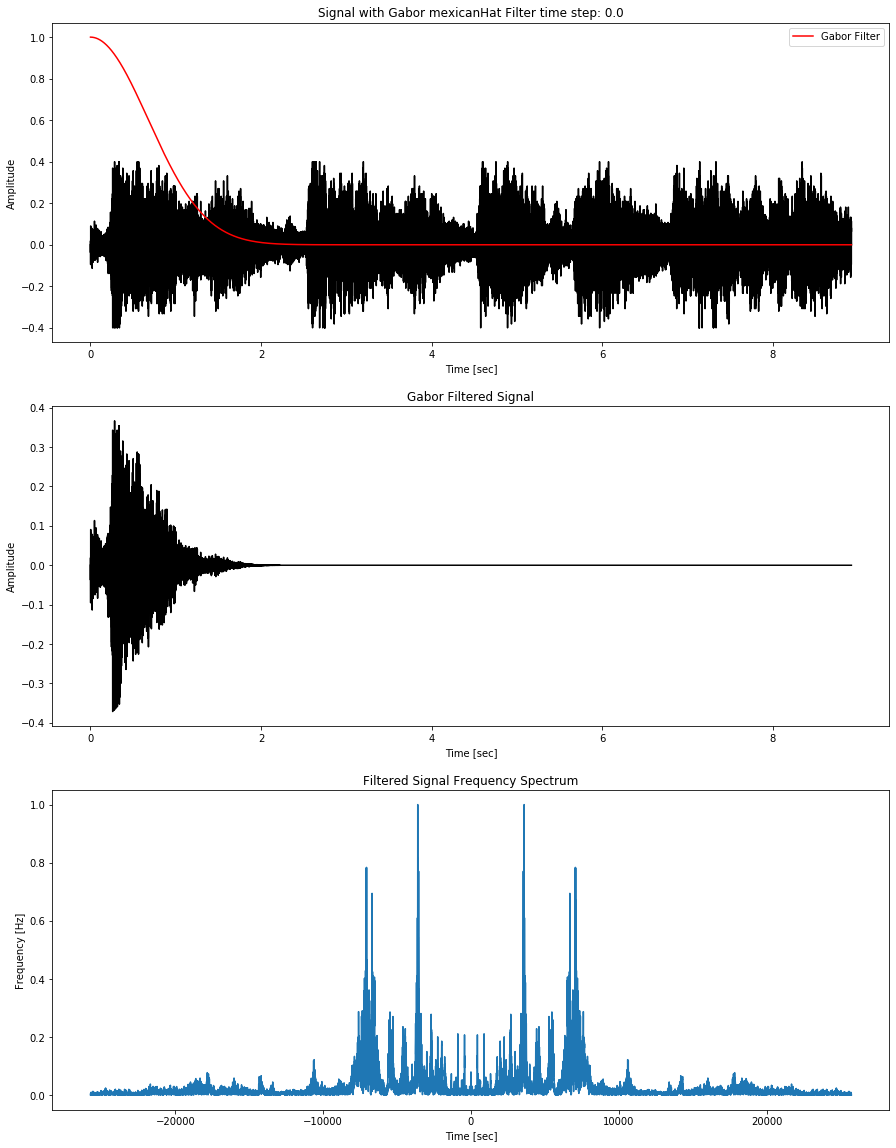

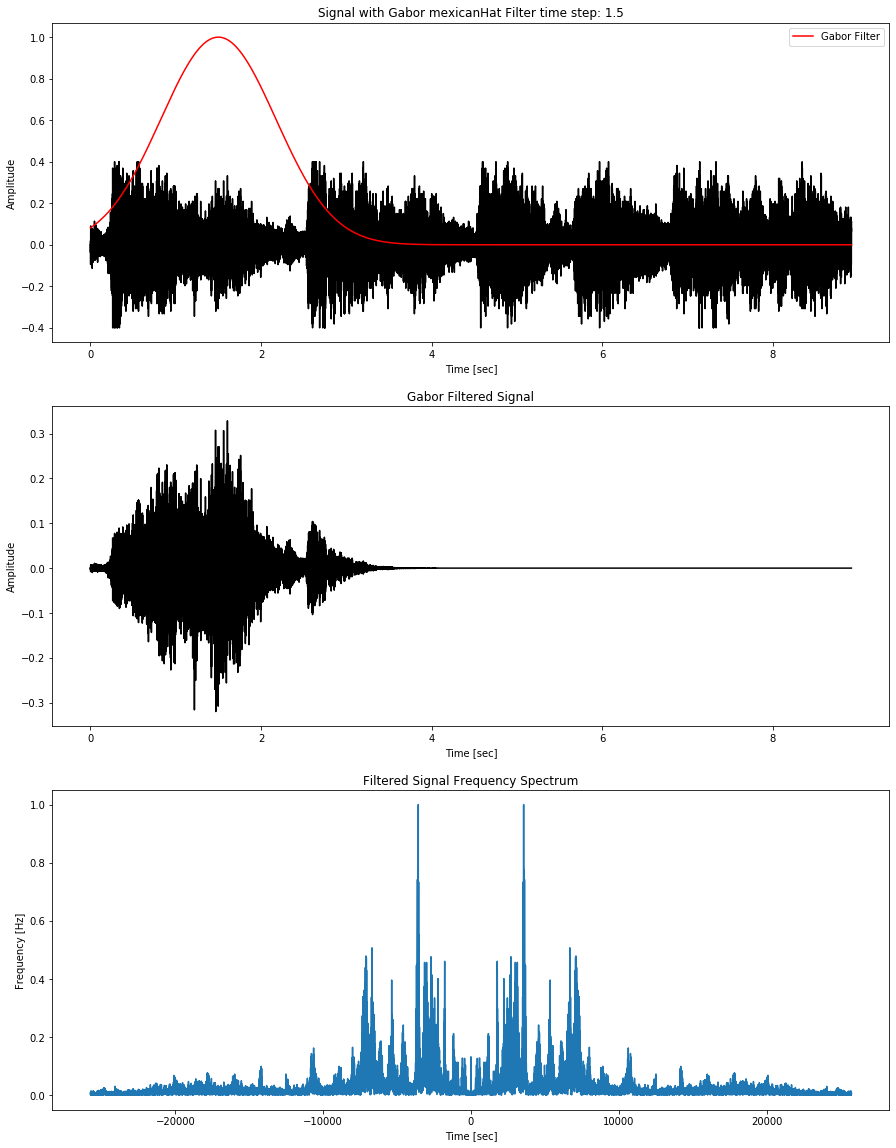

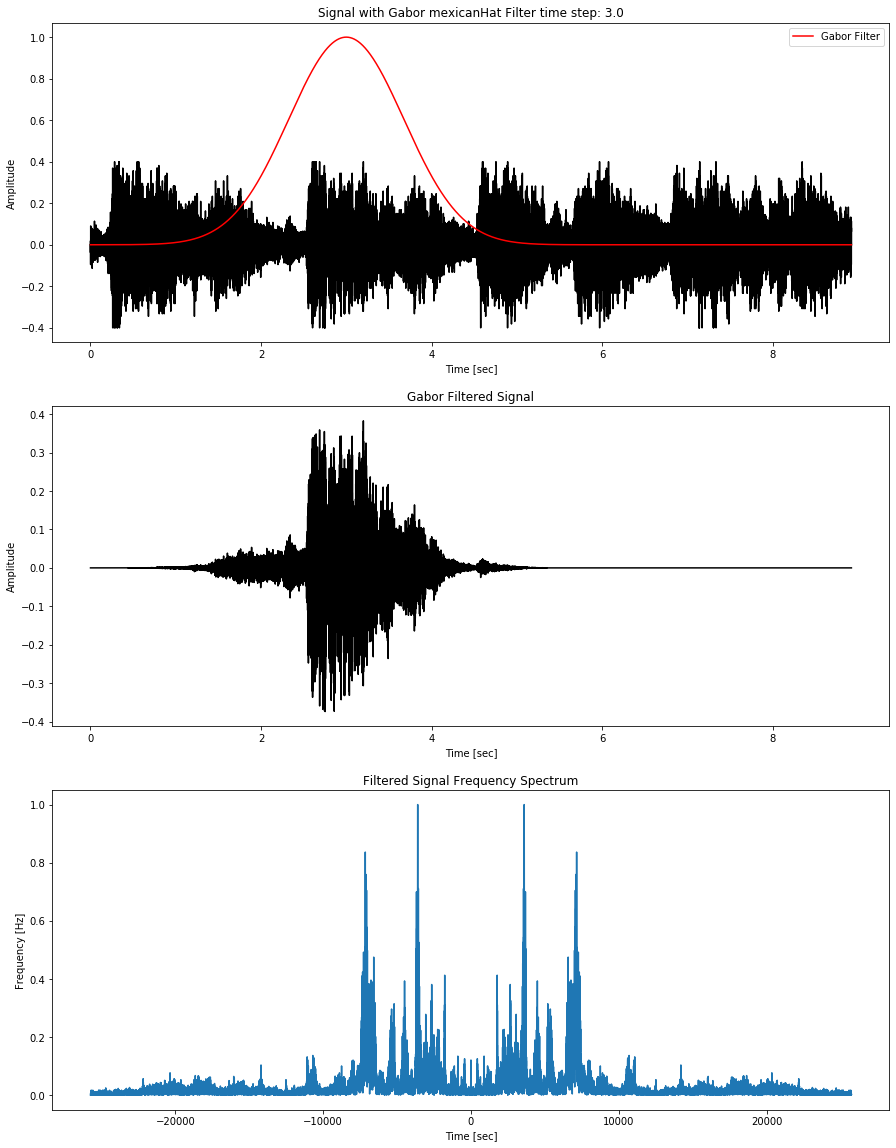

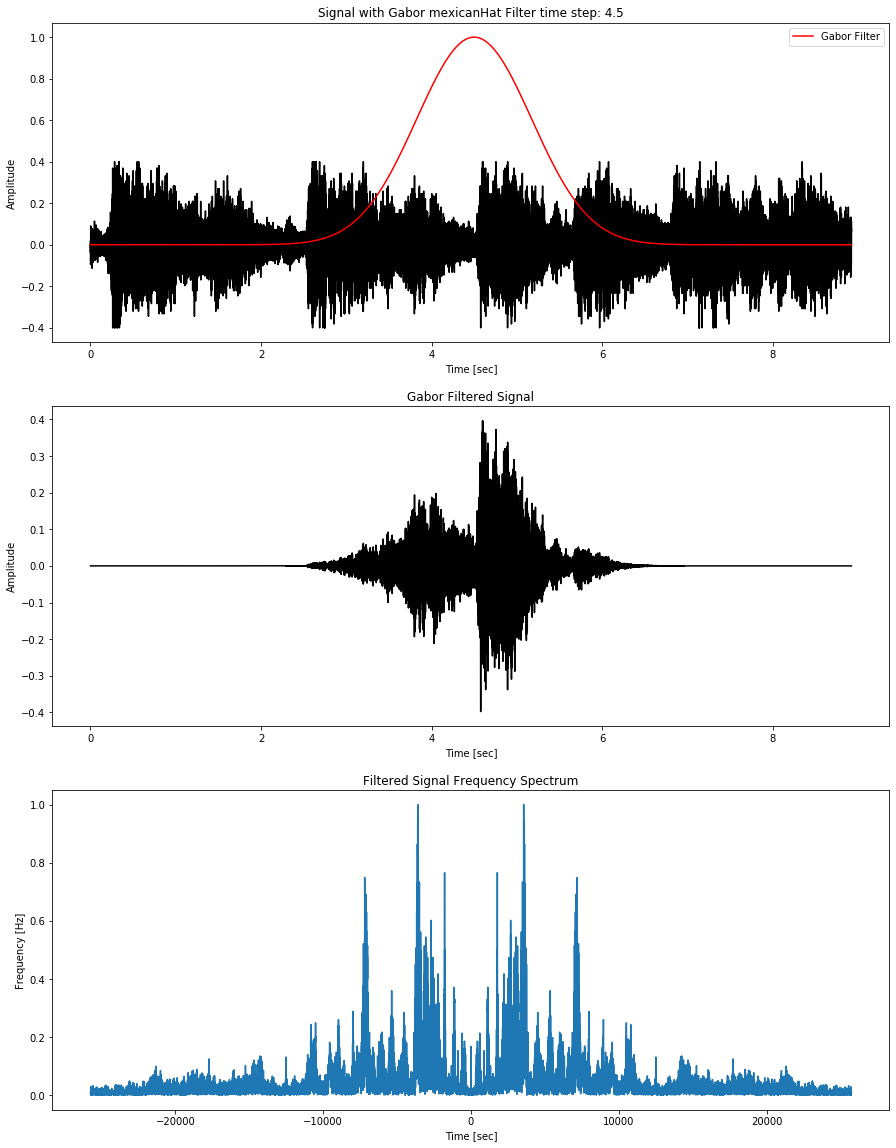

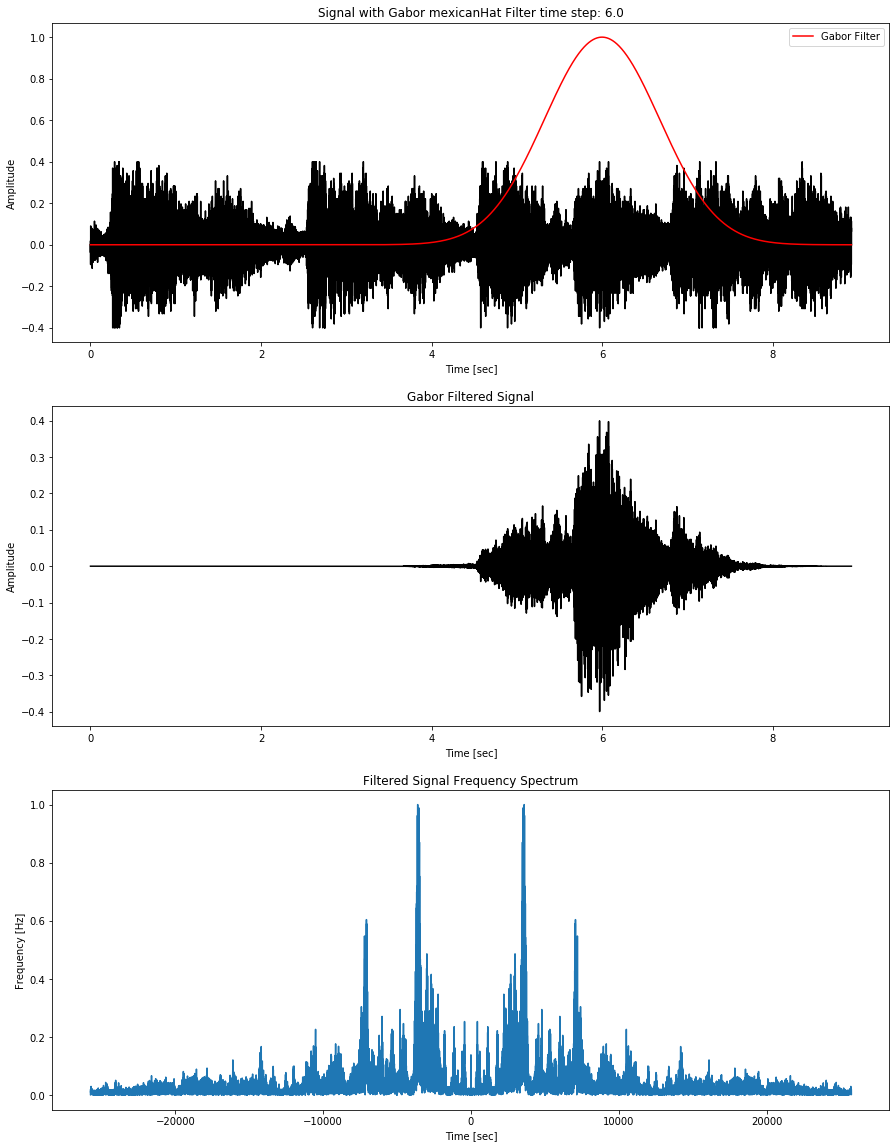

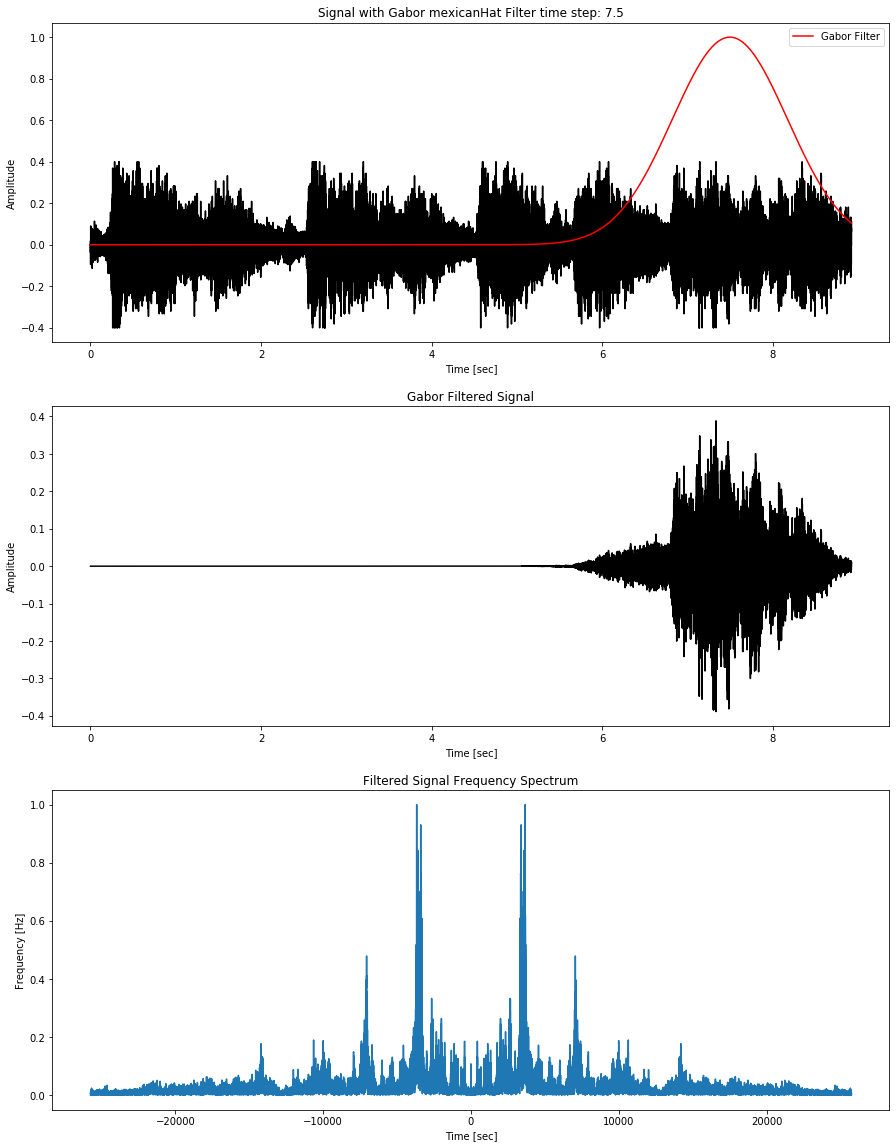

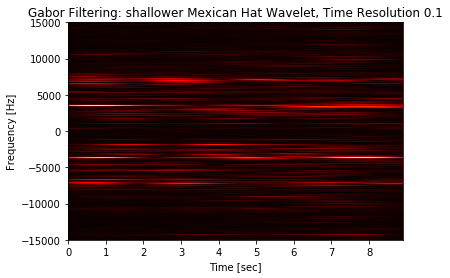

In [47]:
#Try smaller Mexican Hat wavelet, time sampling 0.1

tres = 0.1
plot_count = 6
w = 0.1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='mexicanHat')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: shallower Mexican Hat Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

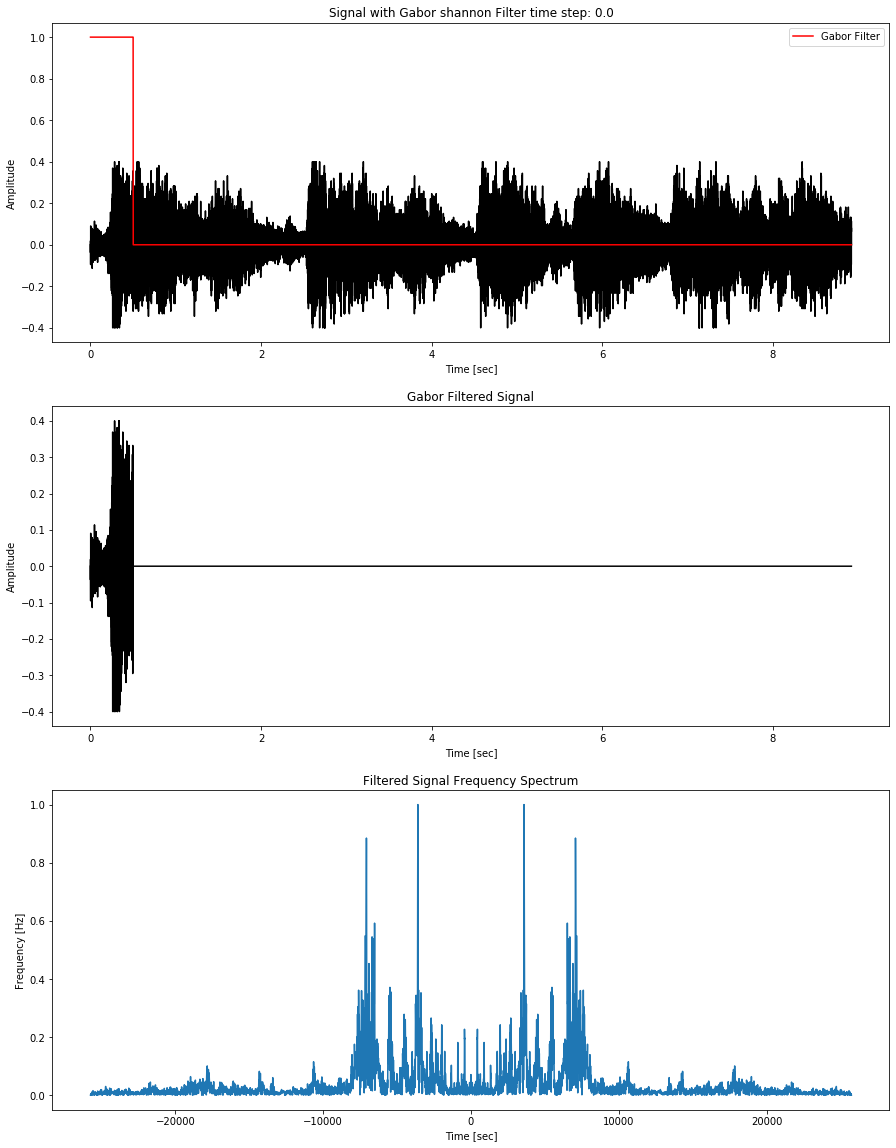

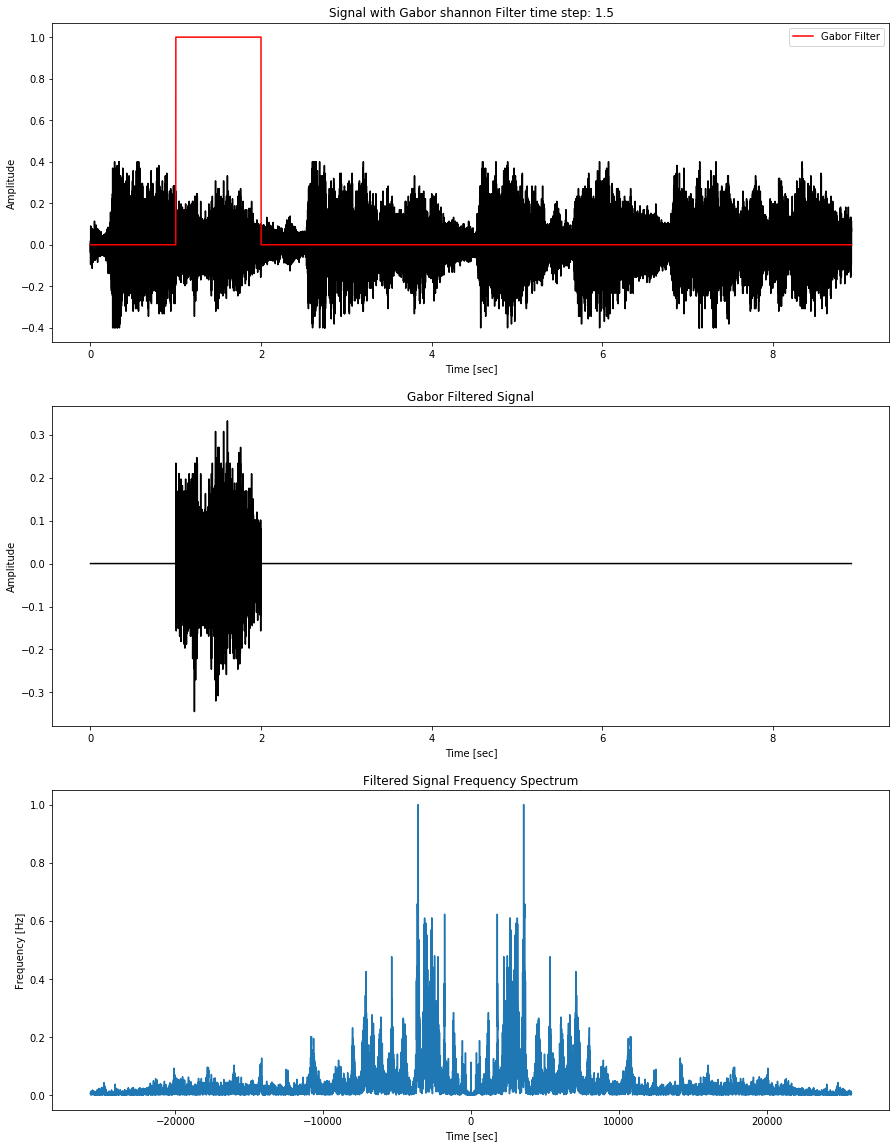

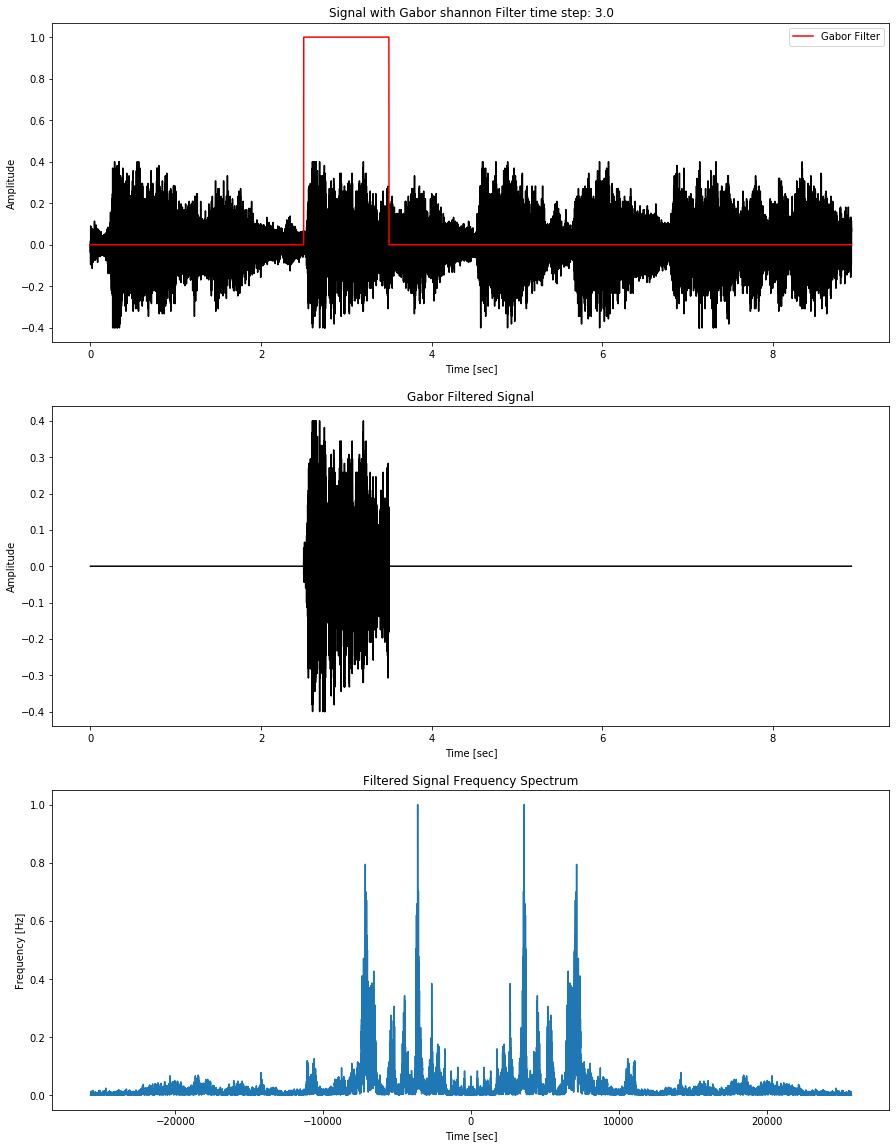

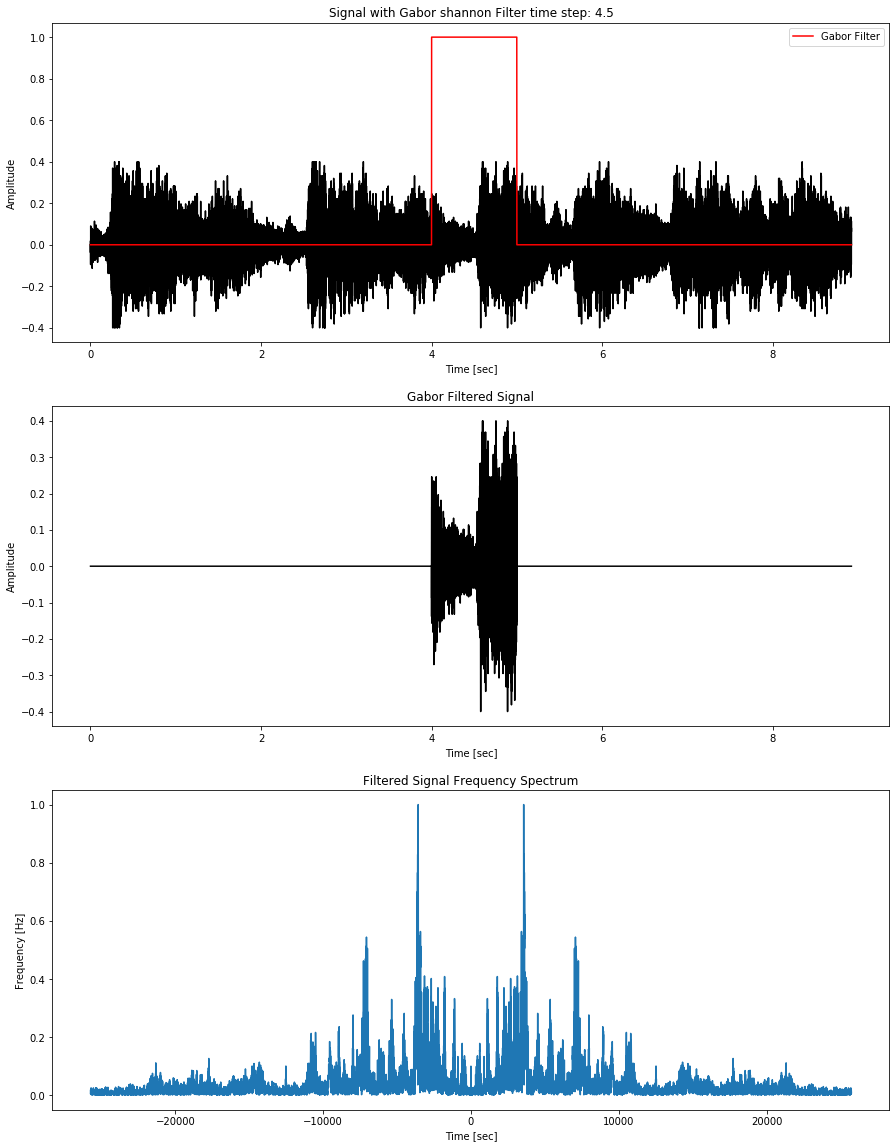

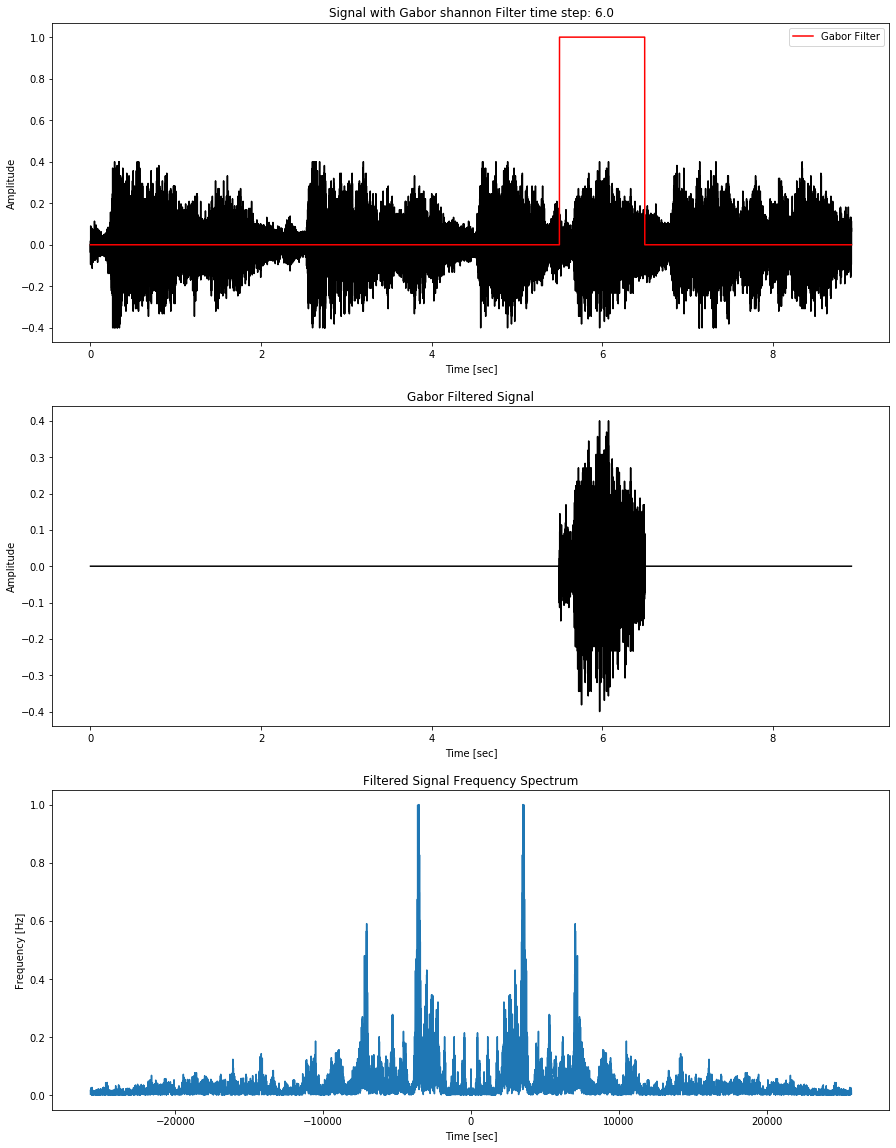

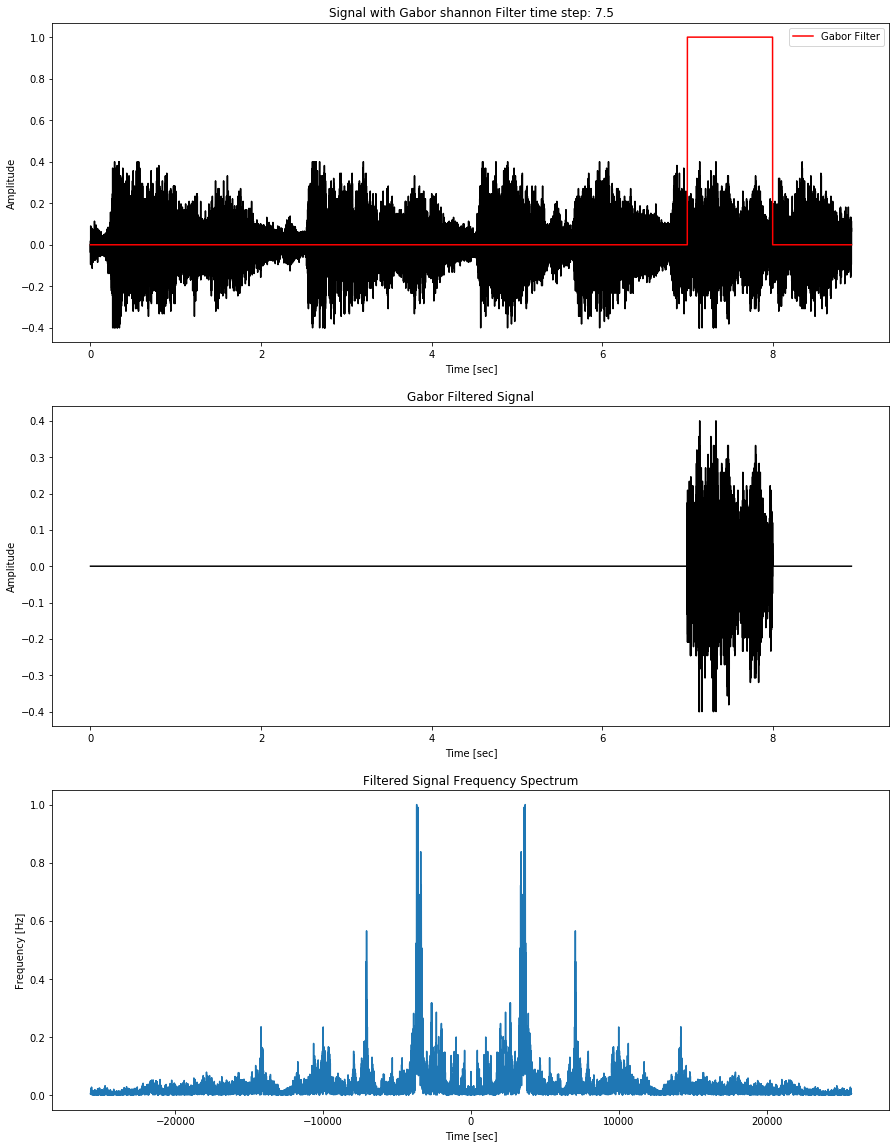

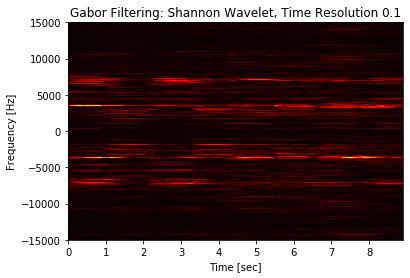

In [48]:
#Try Shannon wavelet, time sampling 0.1

tres = 0.1
plot_count = 6
w = 1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='shannon')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: Shannon Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

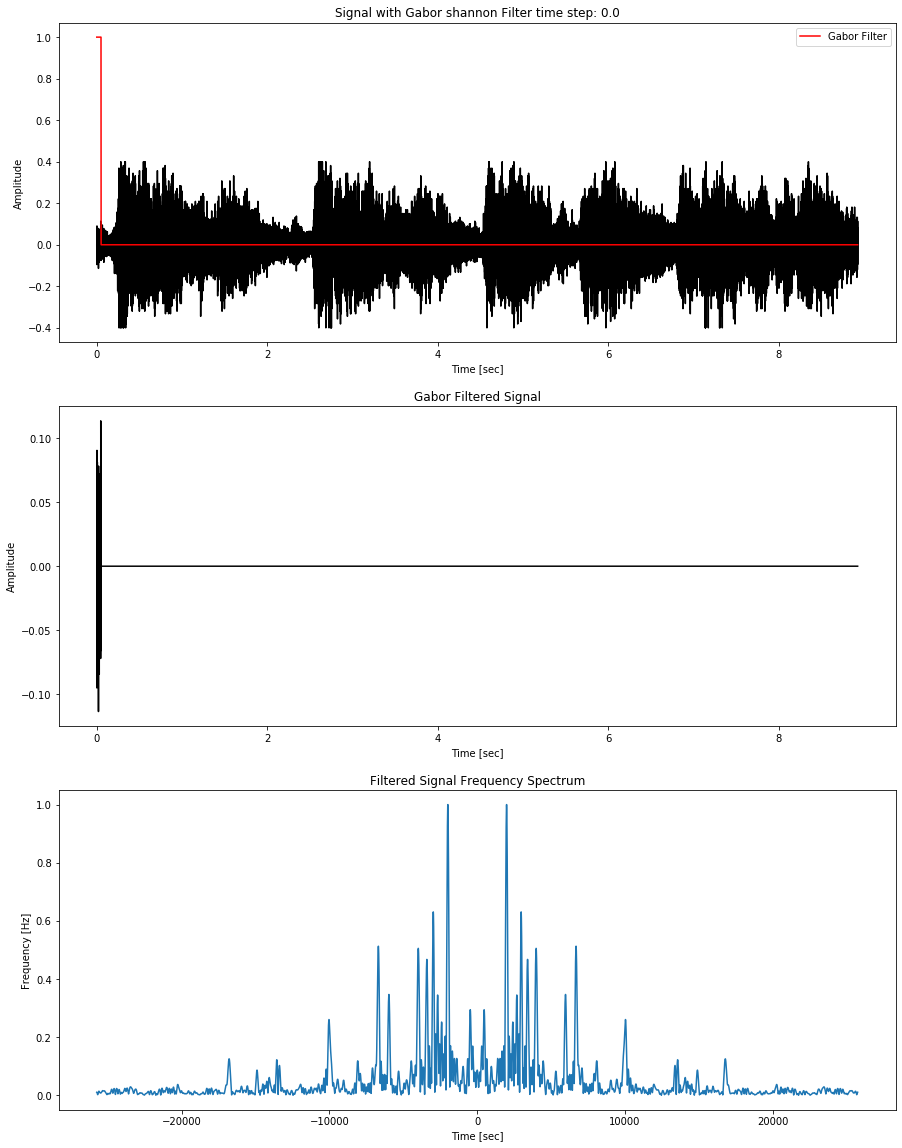

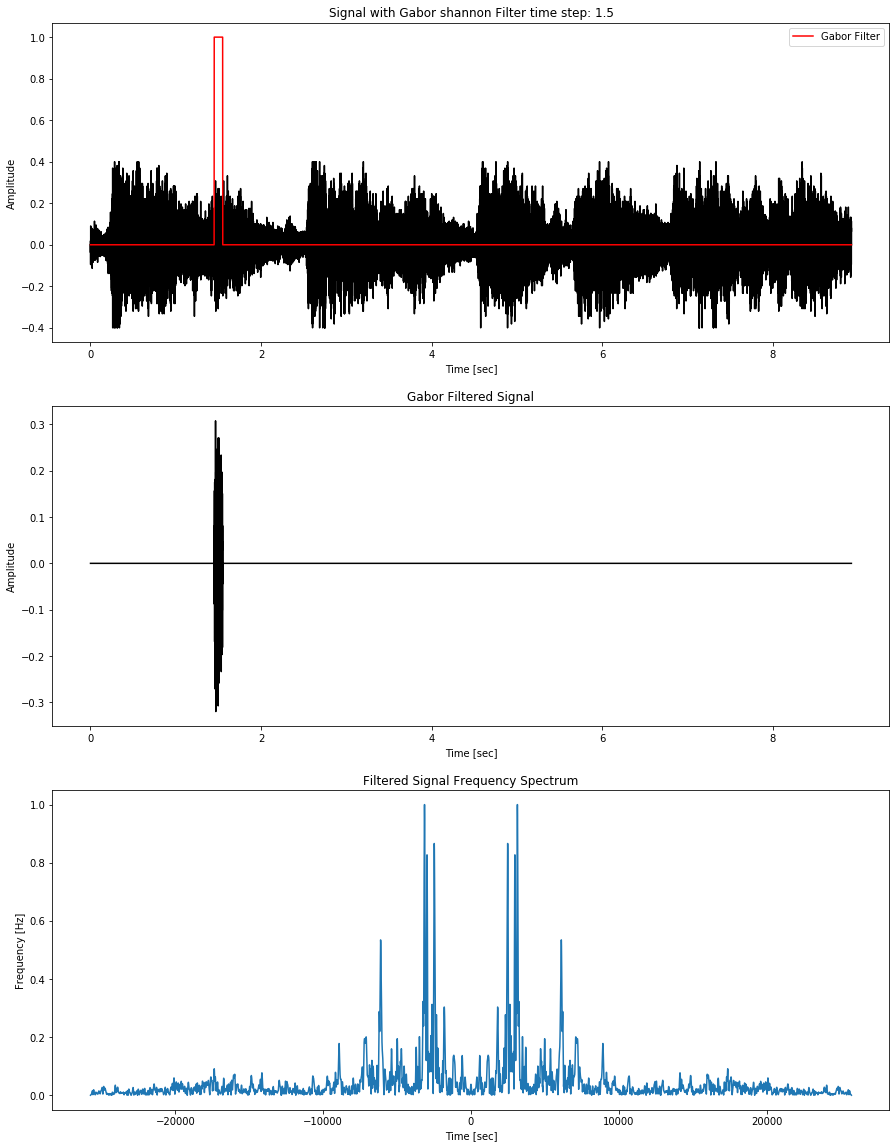

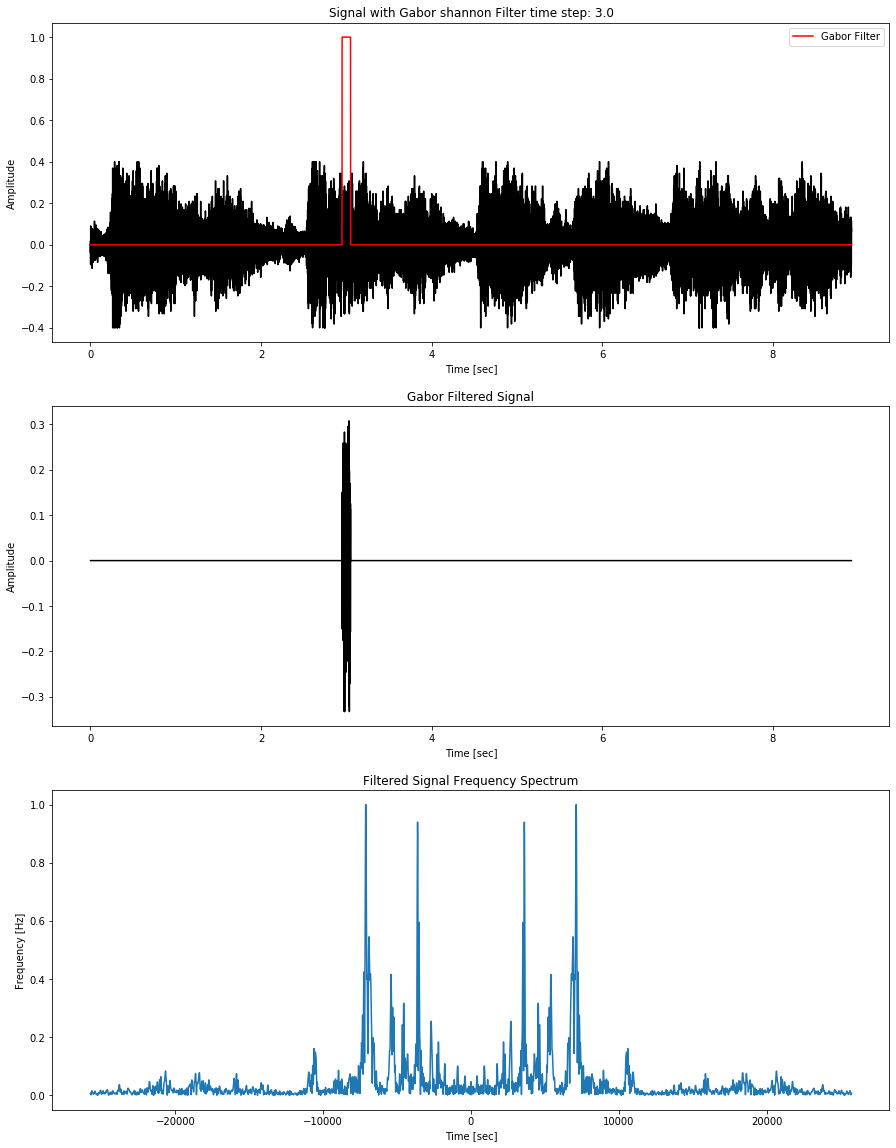

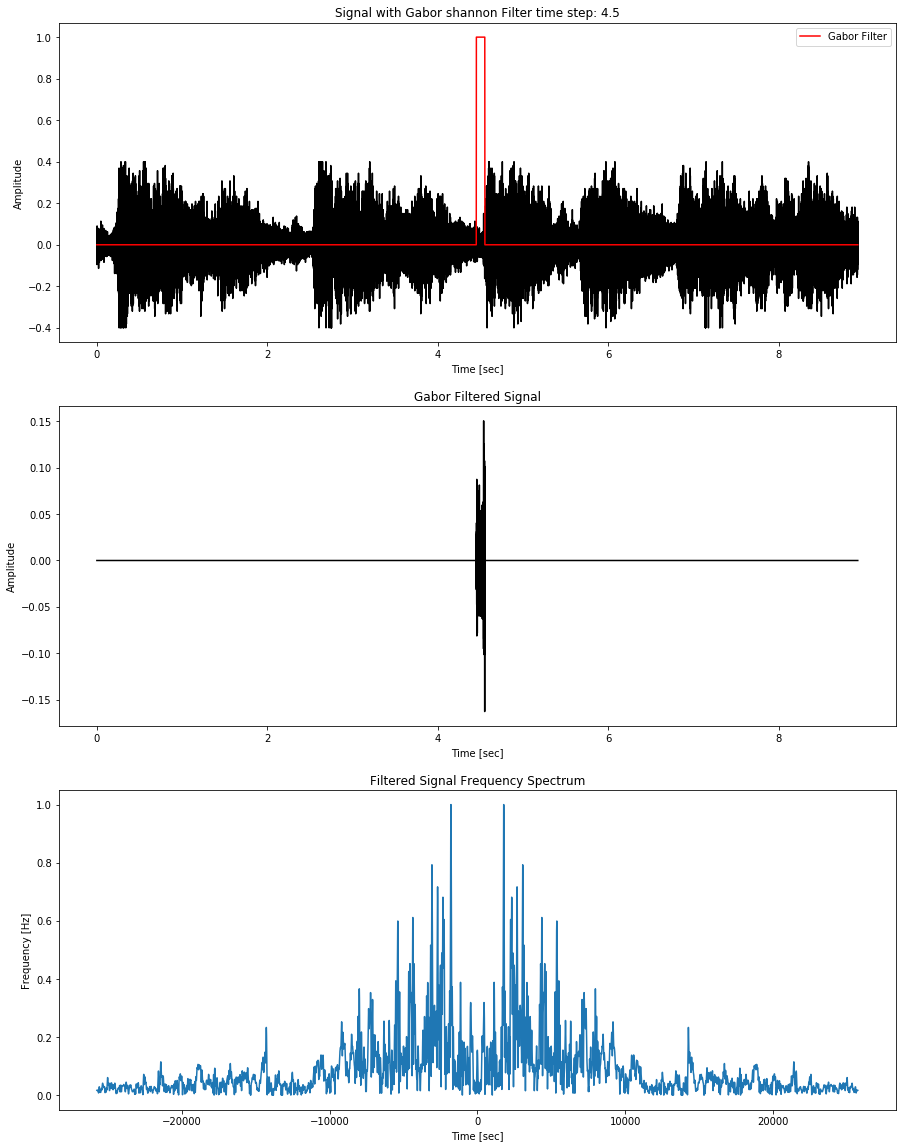

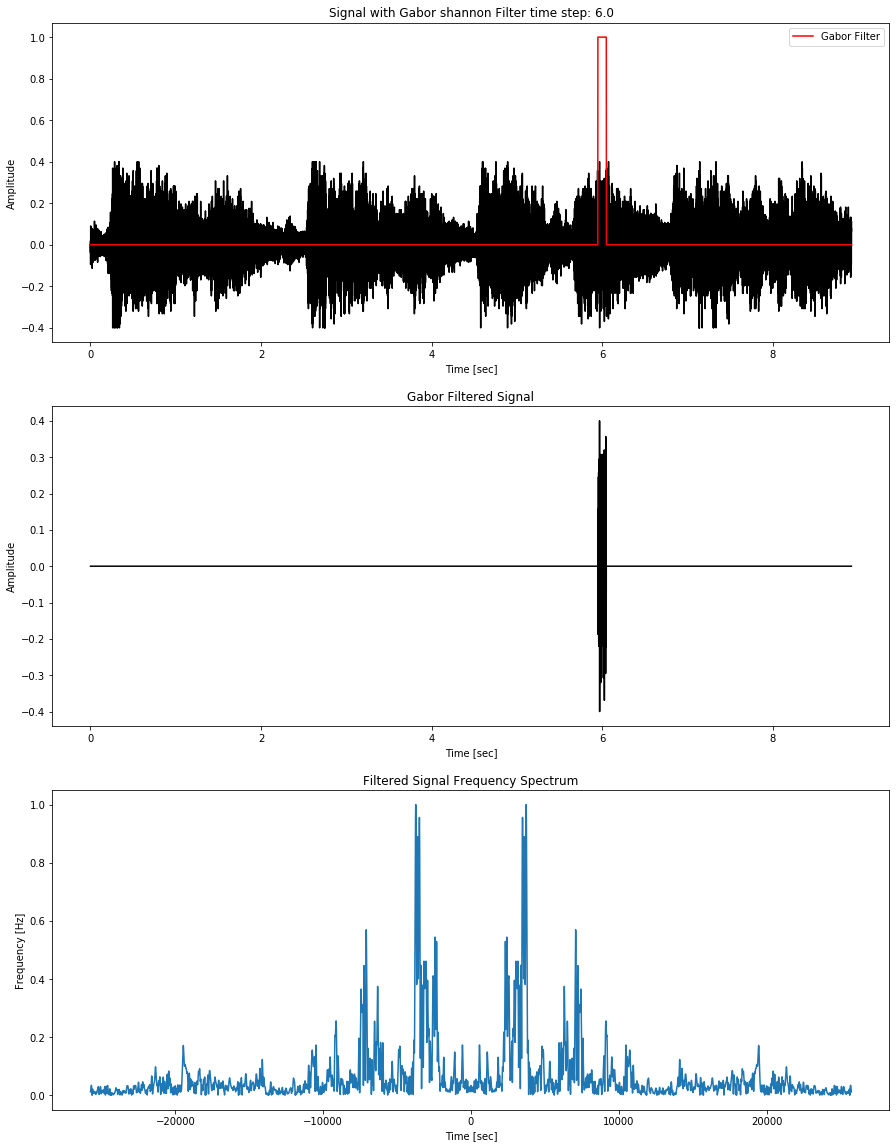

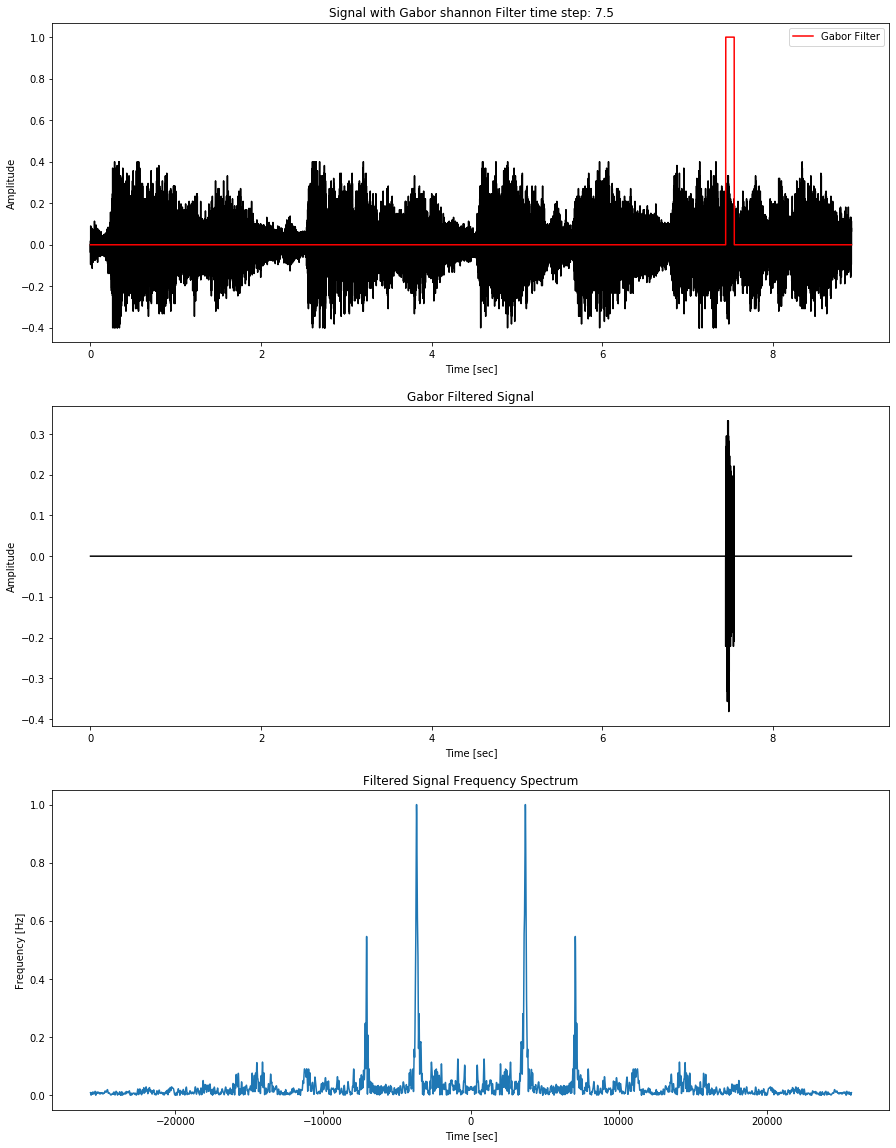

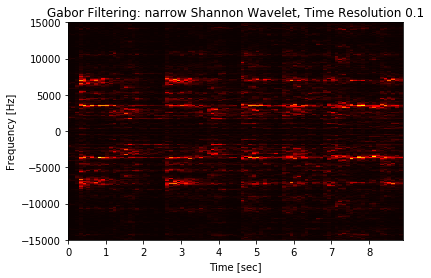

In [49]:
#Try narrower Shannon wavelet, time sampling 0.1

tres = 0.1
plot_count = 6
w = 10
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='shannon')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: narrow Shannon Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

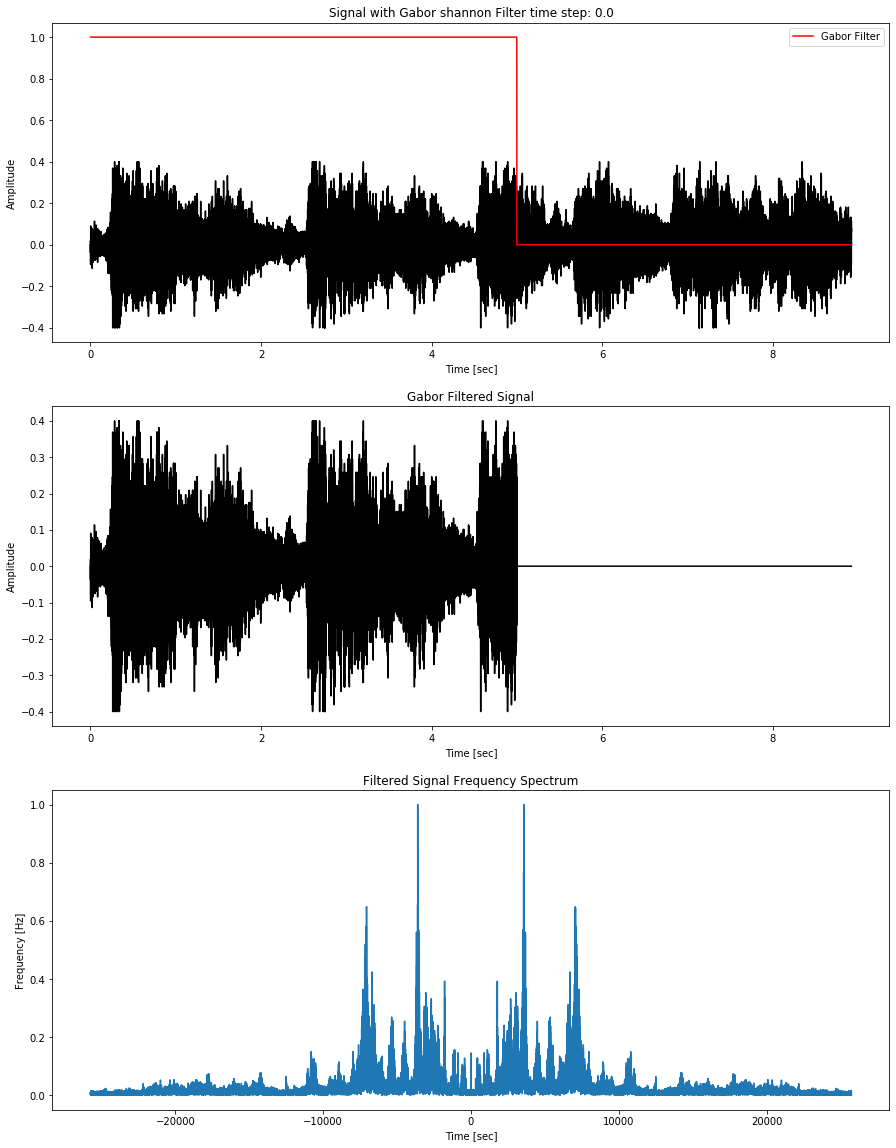

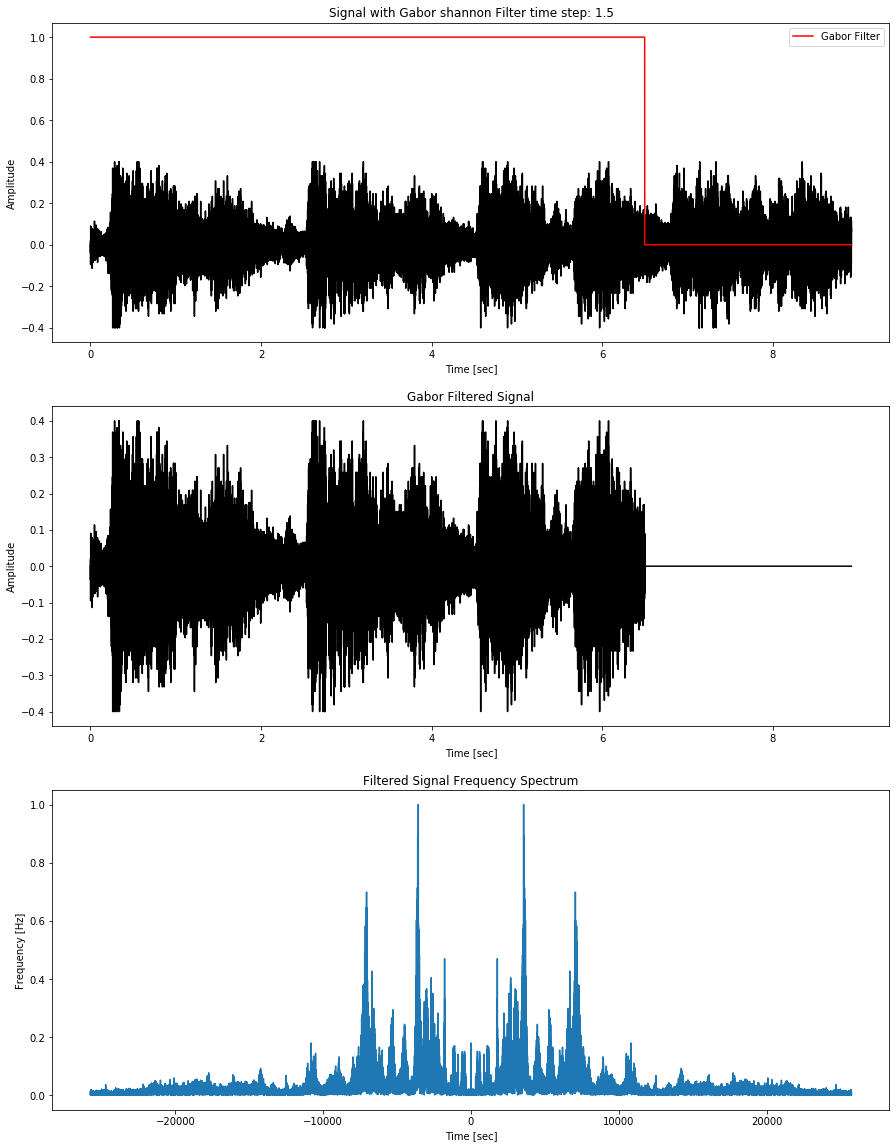

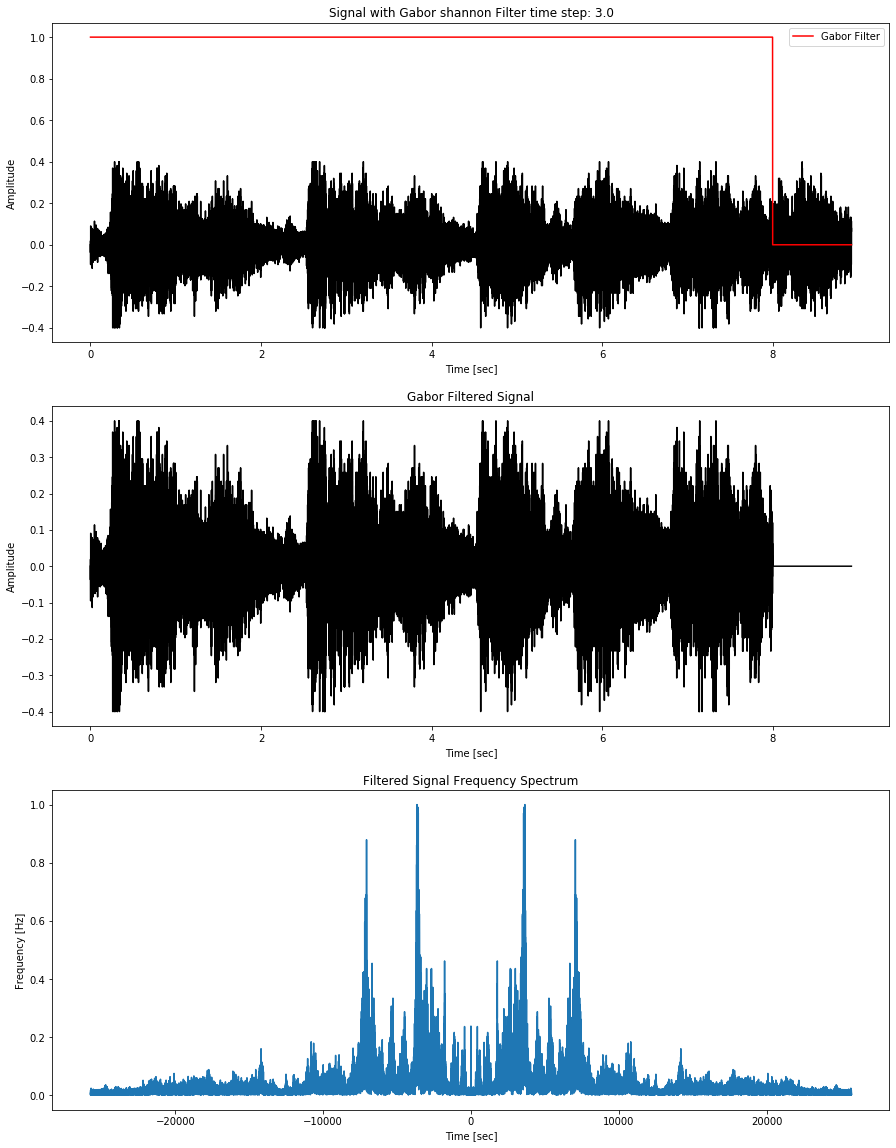

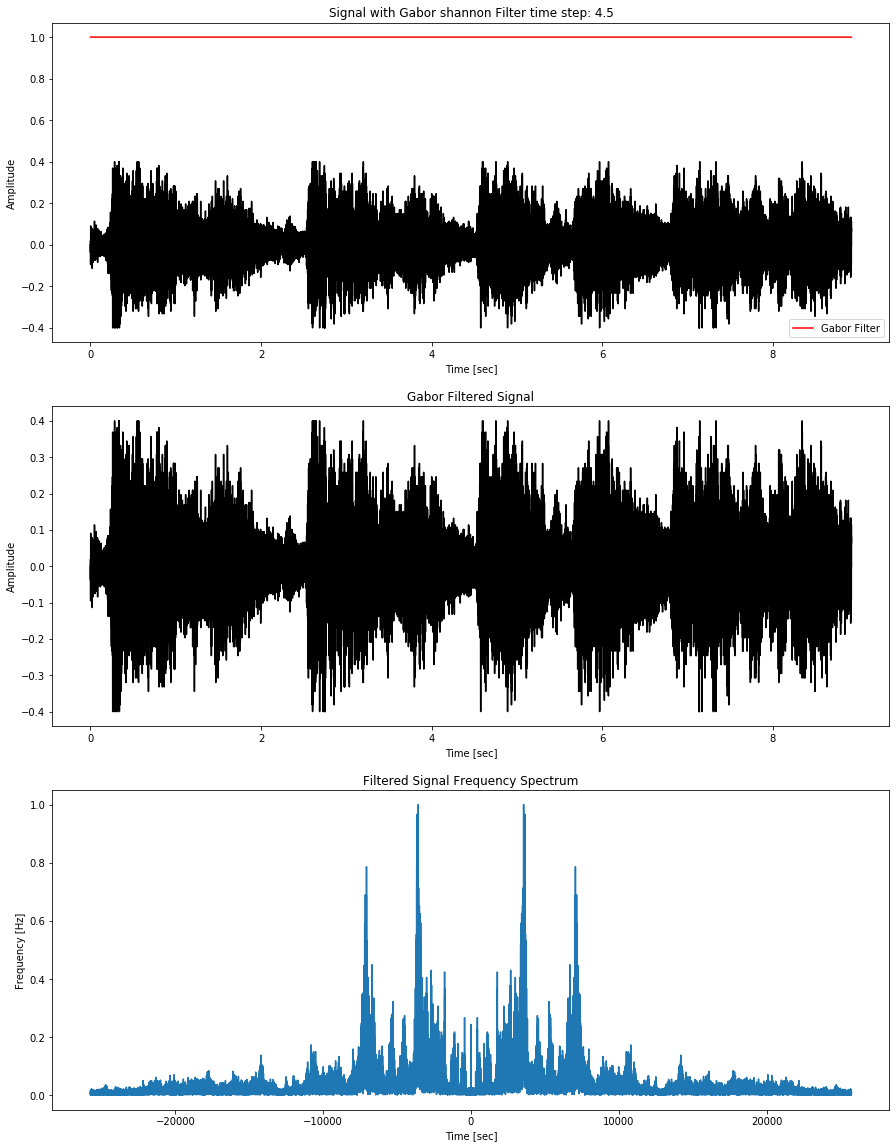

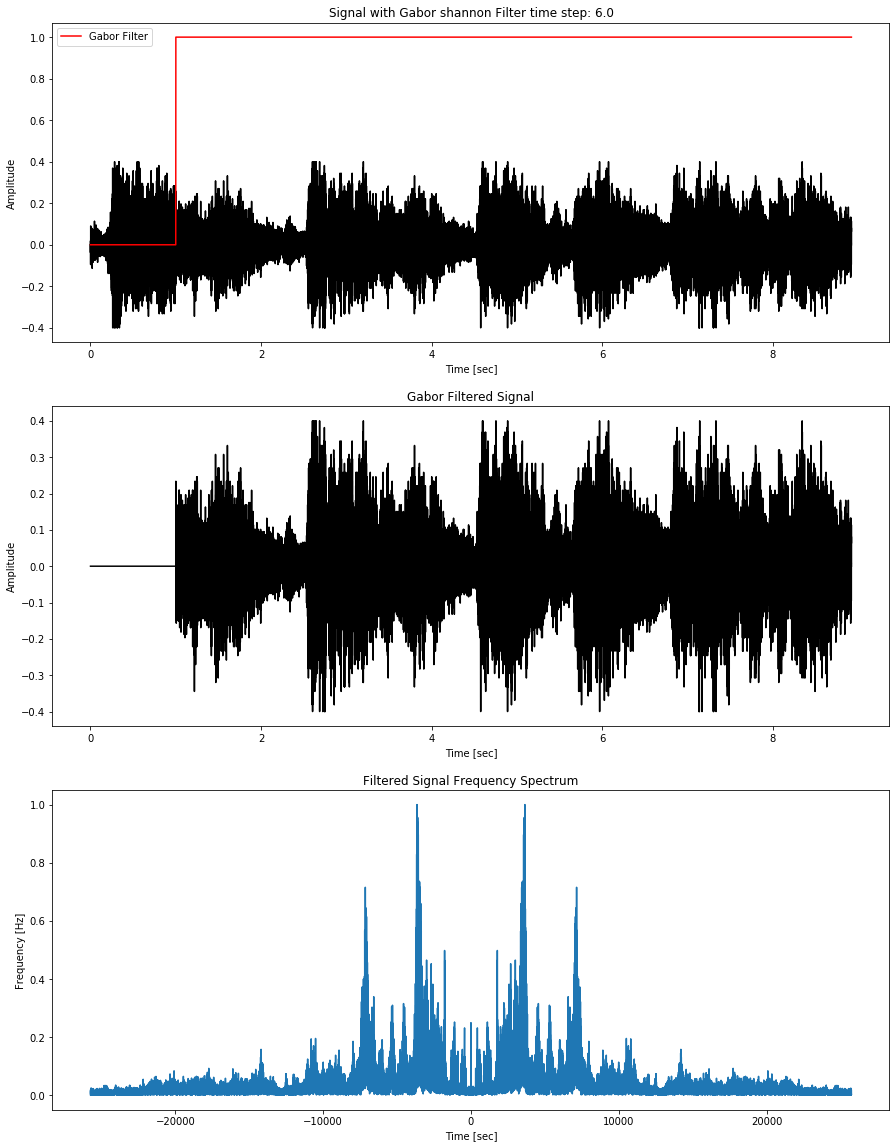

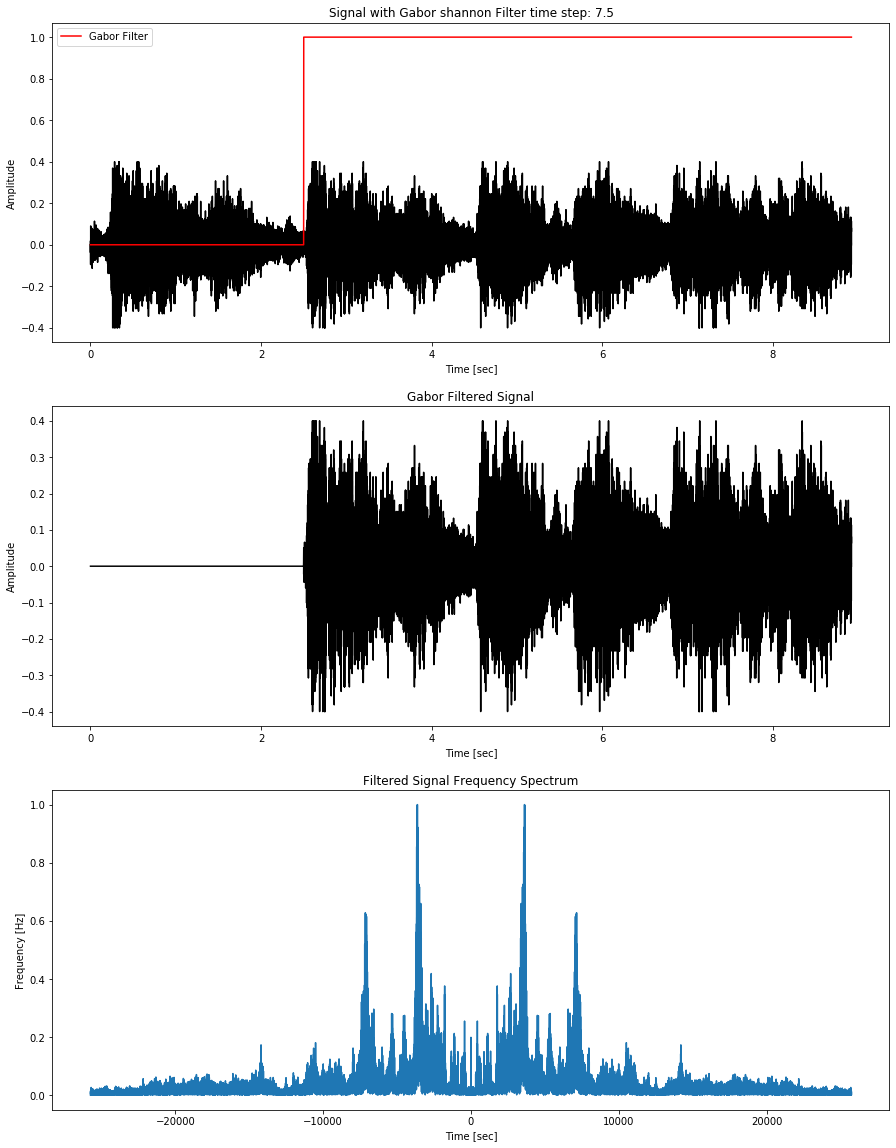

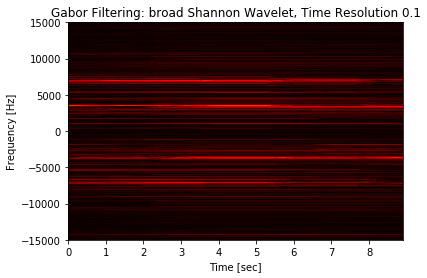

In [50]:
#Try wider Shannon wavelet, time sampling 0.1

tres = 0.1
plot_count = 6
w = 0.1
[Sgt_spec, tslide, ks] = gaborFilter(v, Fs[0], tres, plot_count, w, ftype='shannon')

xlim = (None, None)
ylim = (-15000, 15000)
title = 'Gabor Filtering: broad Shannon Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title)

Text(0.5, 1.0, 'Mary had a little lamb (recorder)')

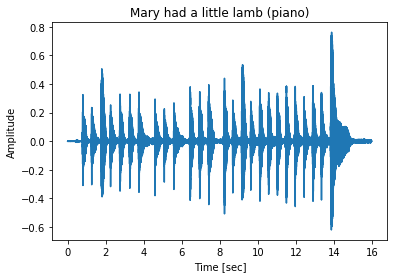

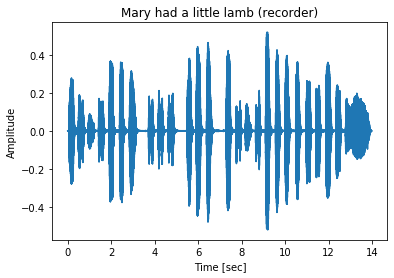

In [4]:
##PART TWO
tr_piano = 16 # record time in seconds
y_ = loadmat('music1.mat')#load MATLAB .mat file into python as a dictionary
yp = y_['y']#raw piano music data matrix
Fsp = len(yp) / tr_piano
tp = np.arange(0, len(yp)) / Fsp

#plot of Mary had a little lamb piano wav file
fig, ax = plt.subplots()
ax.plot(tp, yp)
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Amplitude')
ax.set_title('Mary had a little lamb (piano)')

tr_rec = 14 # record time in seconds
y_ = loadmat('music2.mat')#load MATLAB .mat file into python as a dictionary
yr = y_['y']#raw recorder music data matrix
Fsr = len(yr) / tr_rec
tr = np.arange(0, len(yr)) / Fsr

#plot of Mary had a little lamb recorder wav file
fig, ax = plt.subplots()
ax.plot(tr, yr)
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Amplitude')
ax.set_title('Mary had a little lamb (recorder)')

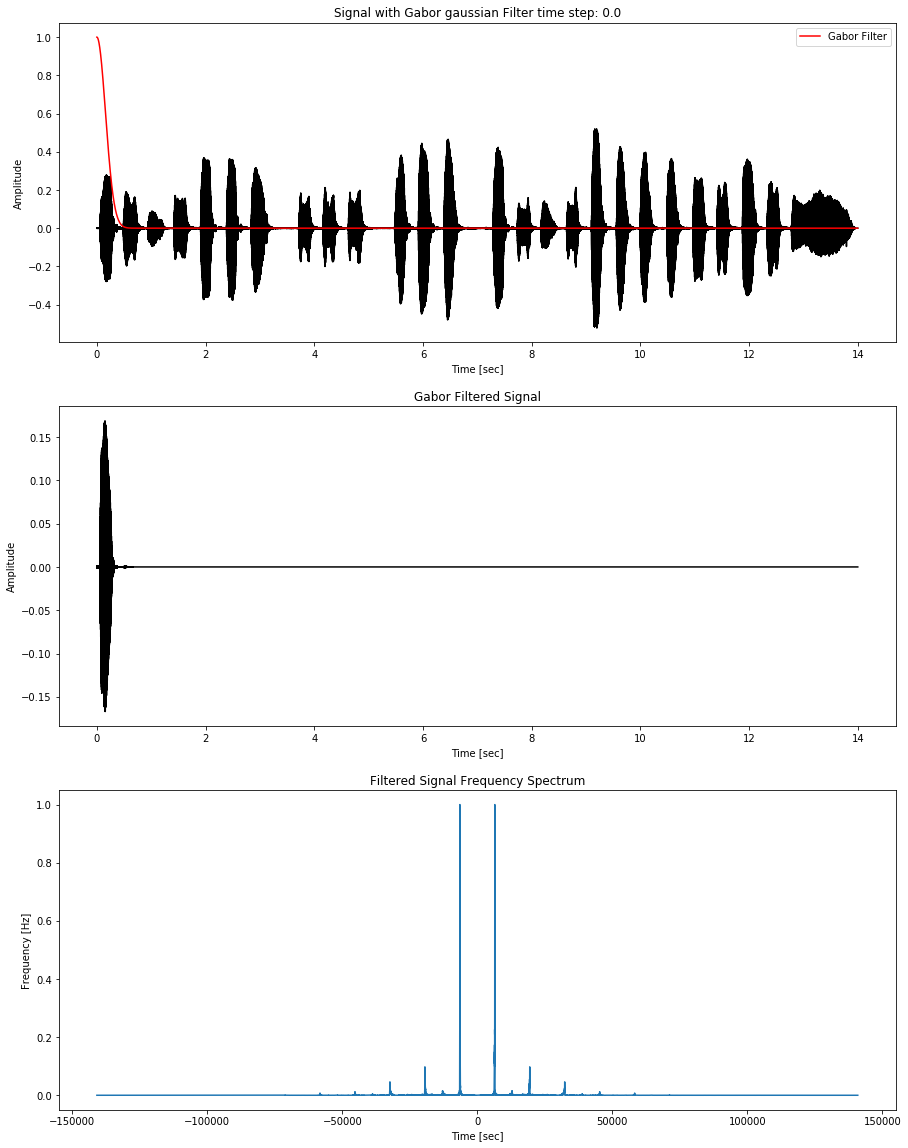

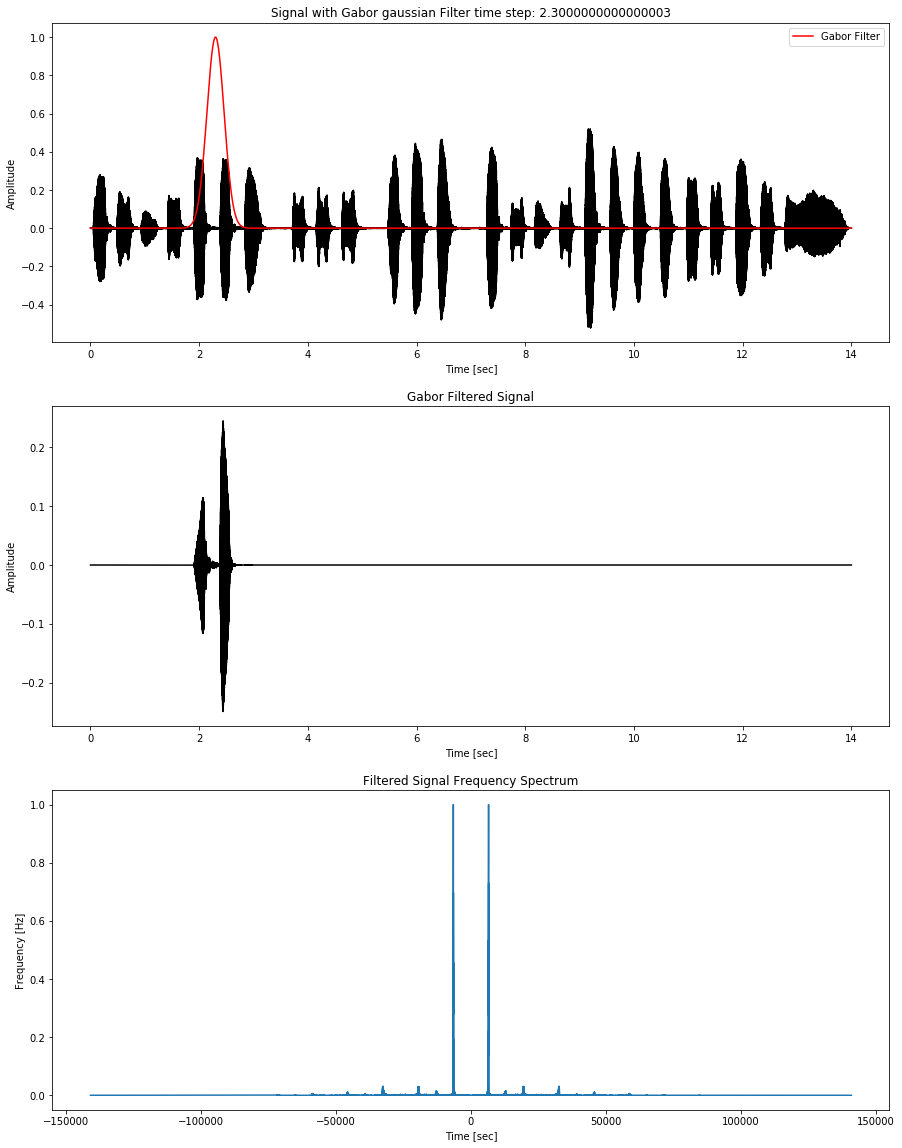

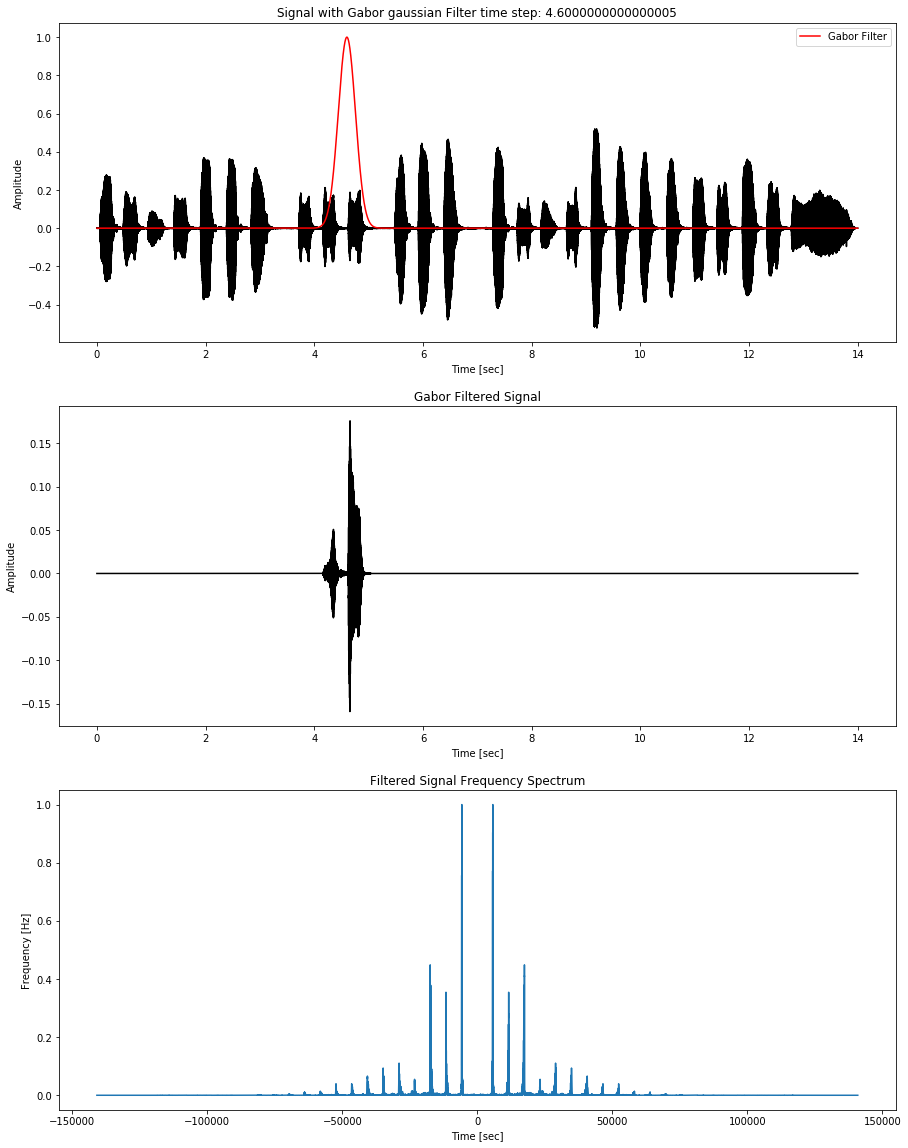

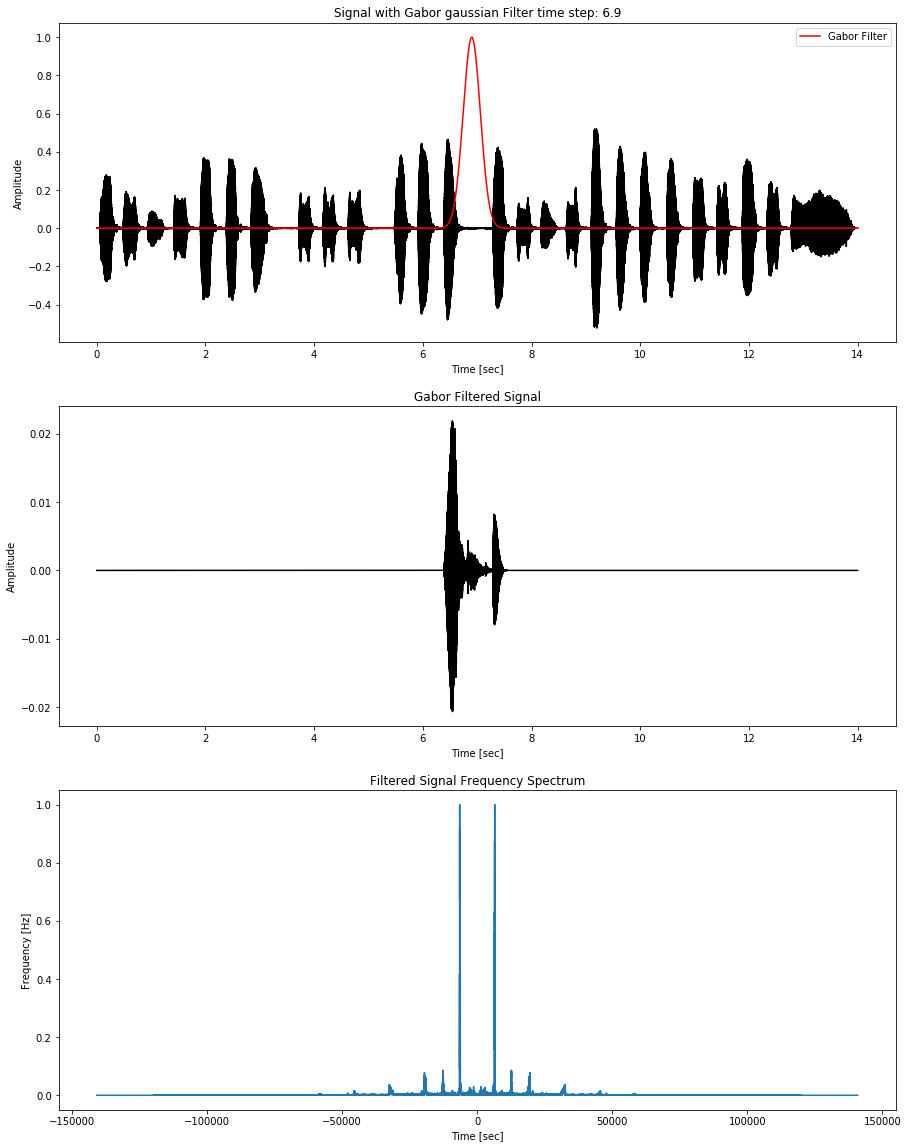

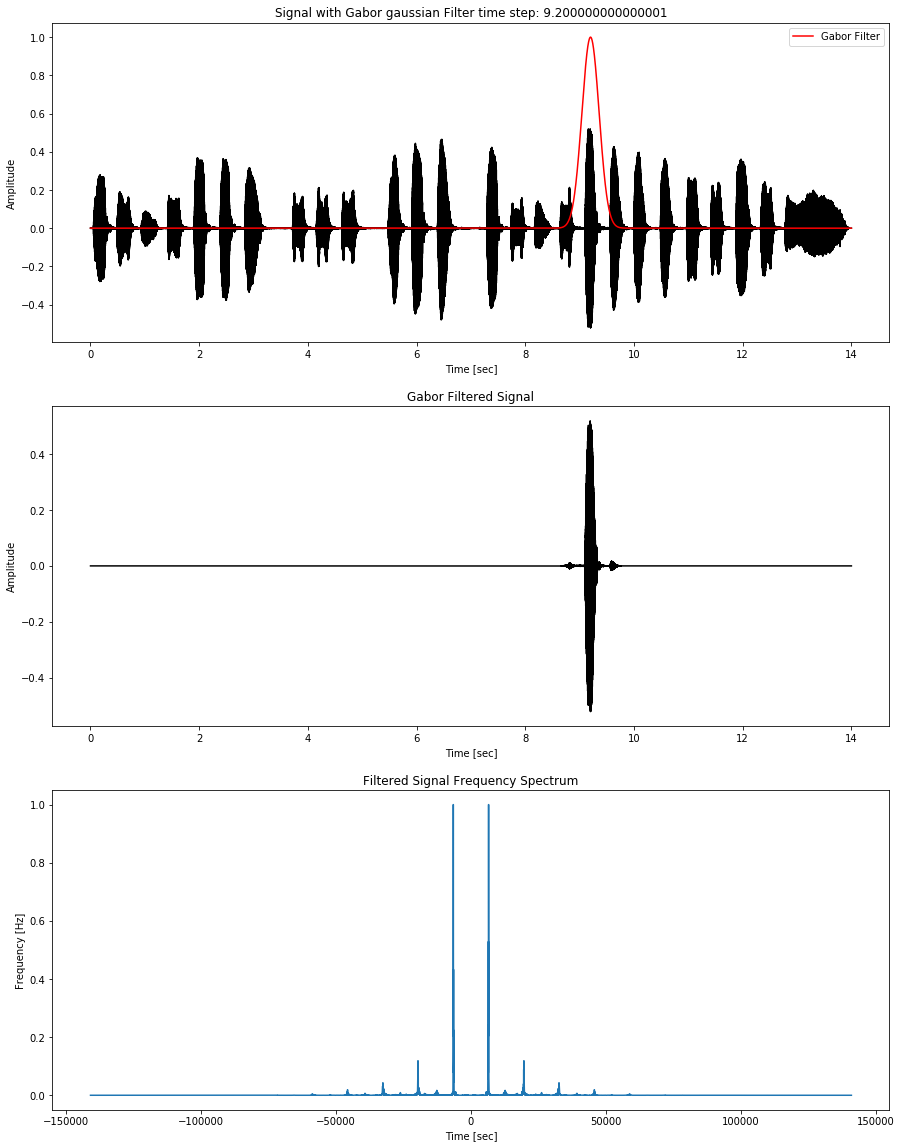

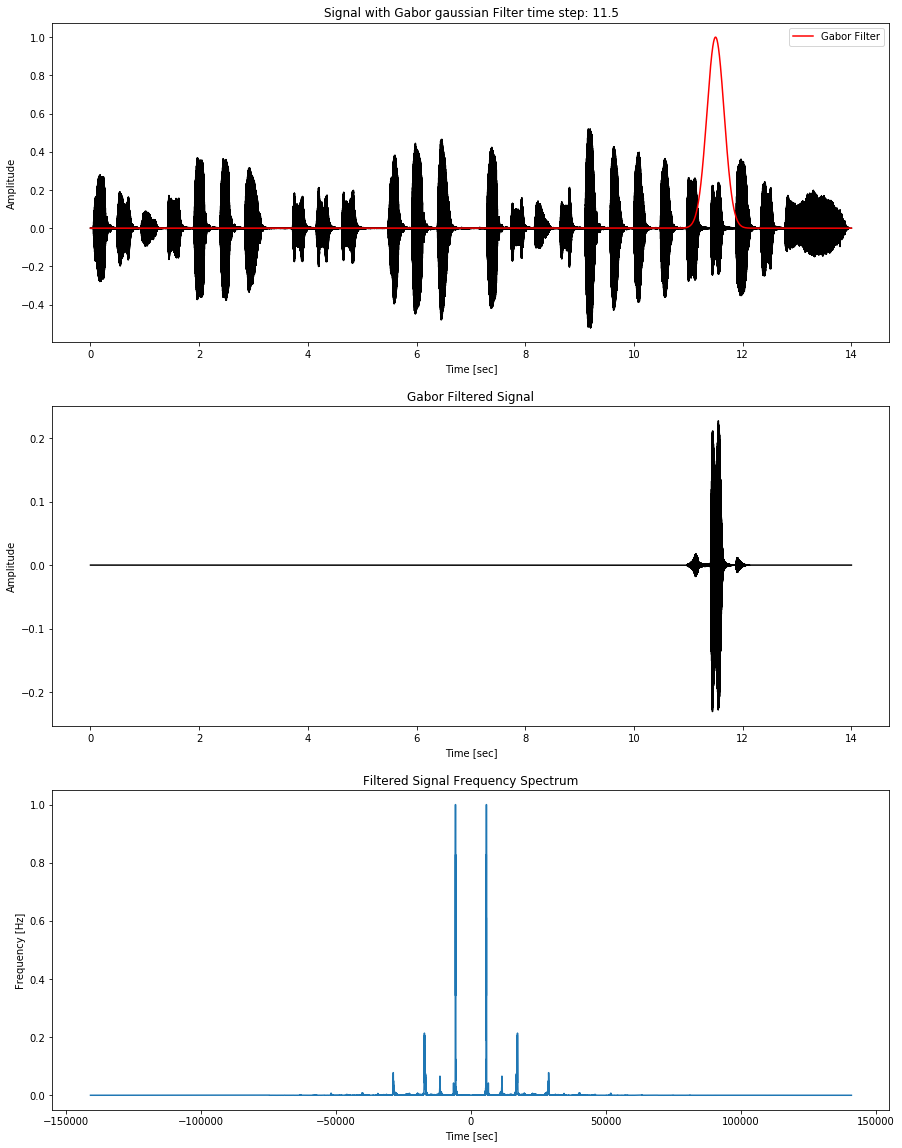

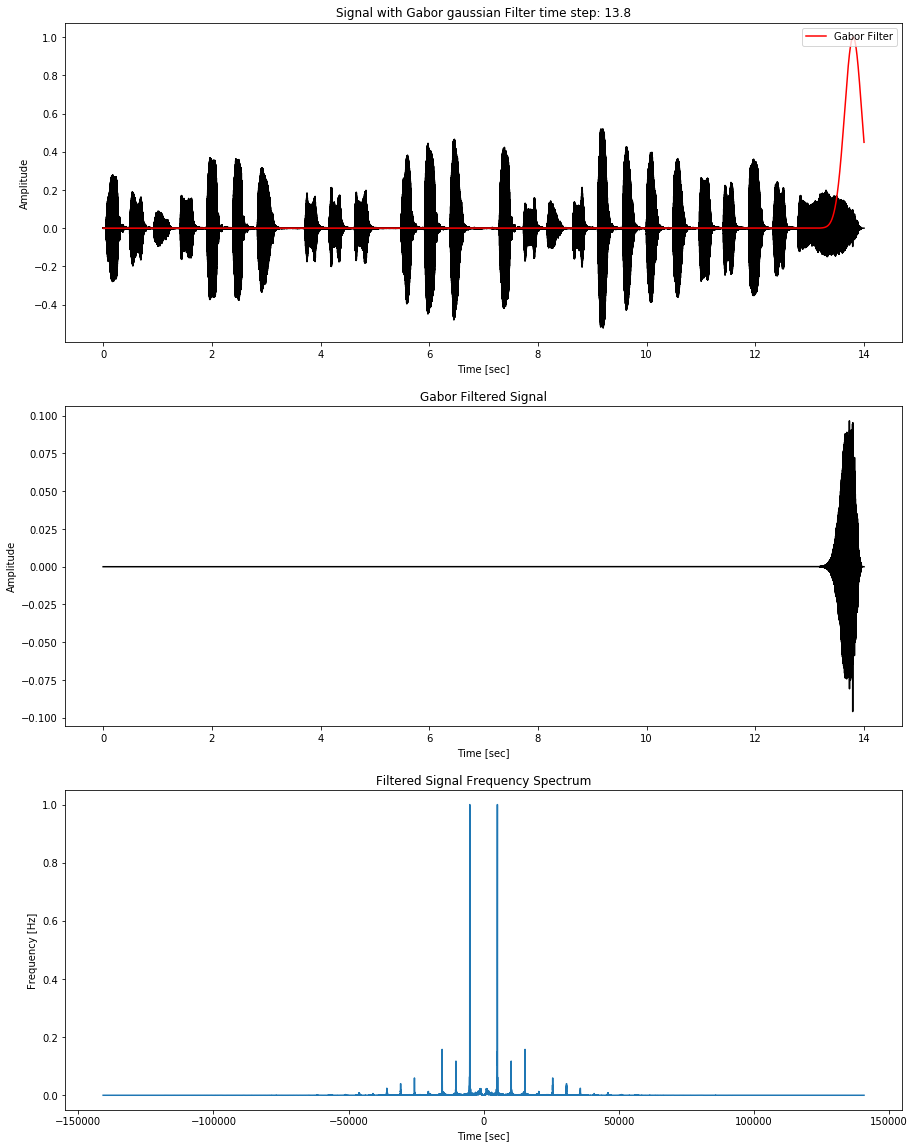

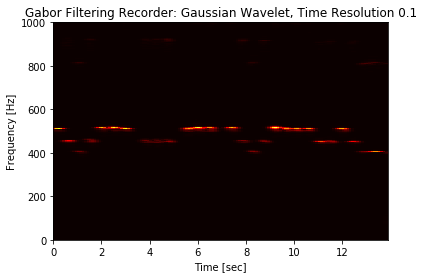

In [57]:
#Try smaller gaussian wavelet, time sampling 0.5, on recorder music
tres = 0.1
plot_count = 6
w = 20

[Sgt_spec_r, tslide_r, ks_r] = gaborFilter(yr, Fsr, tres, plot_count, w, ftype='gaussian')

xlim = (None, None)
ylim = (0, 1000)
title = 'Gabor Filtering Recorder: Gaussian Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec_r, tslide_r, ks_r / (4*np.pi), xlim, ylim, title)

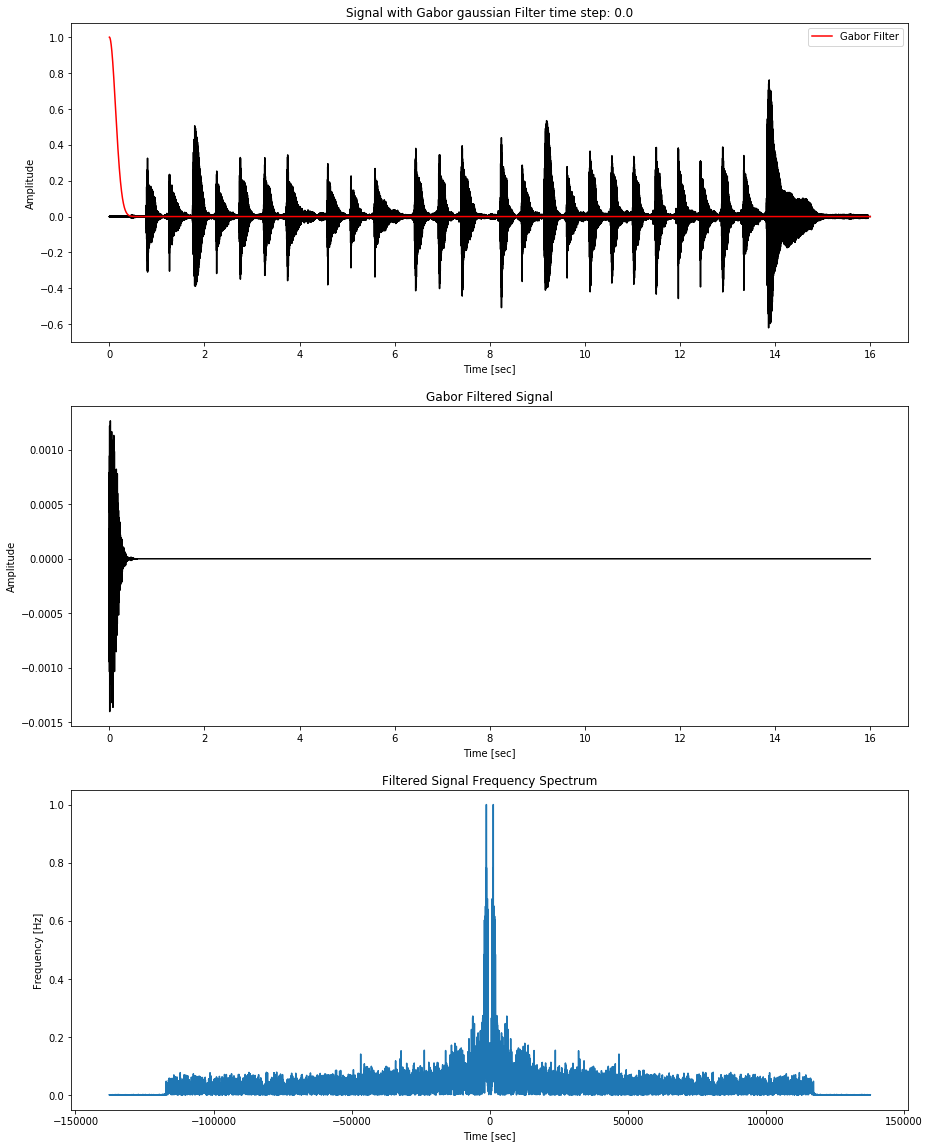

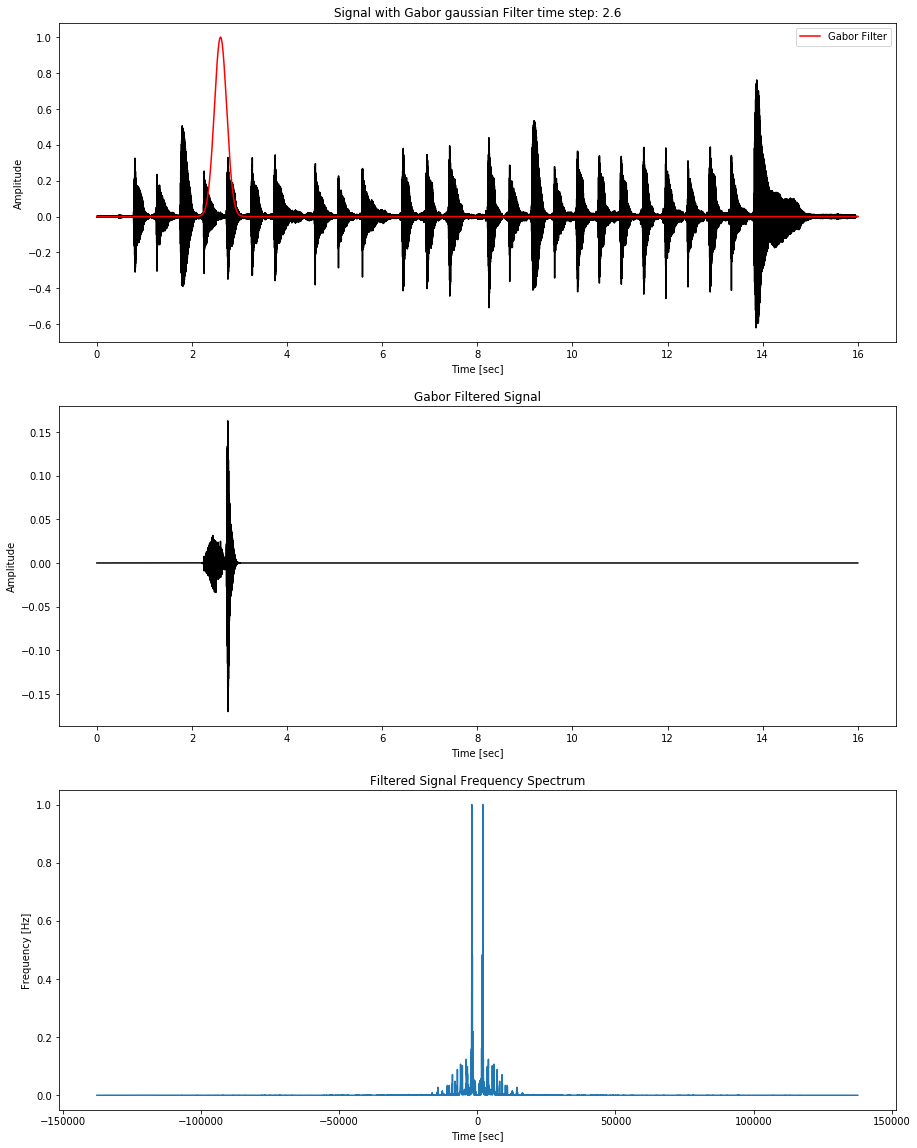

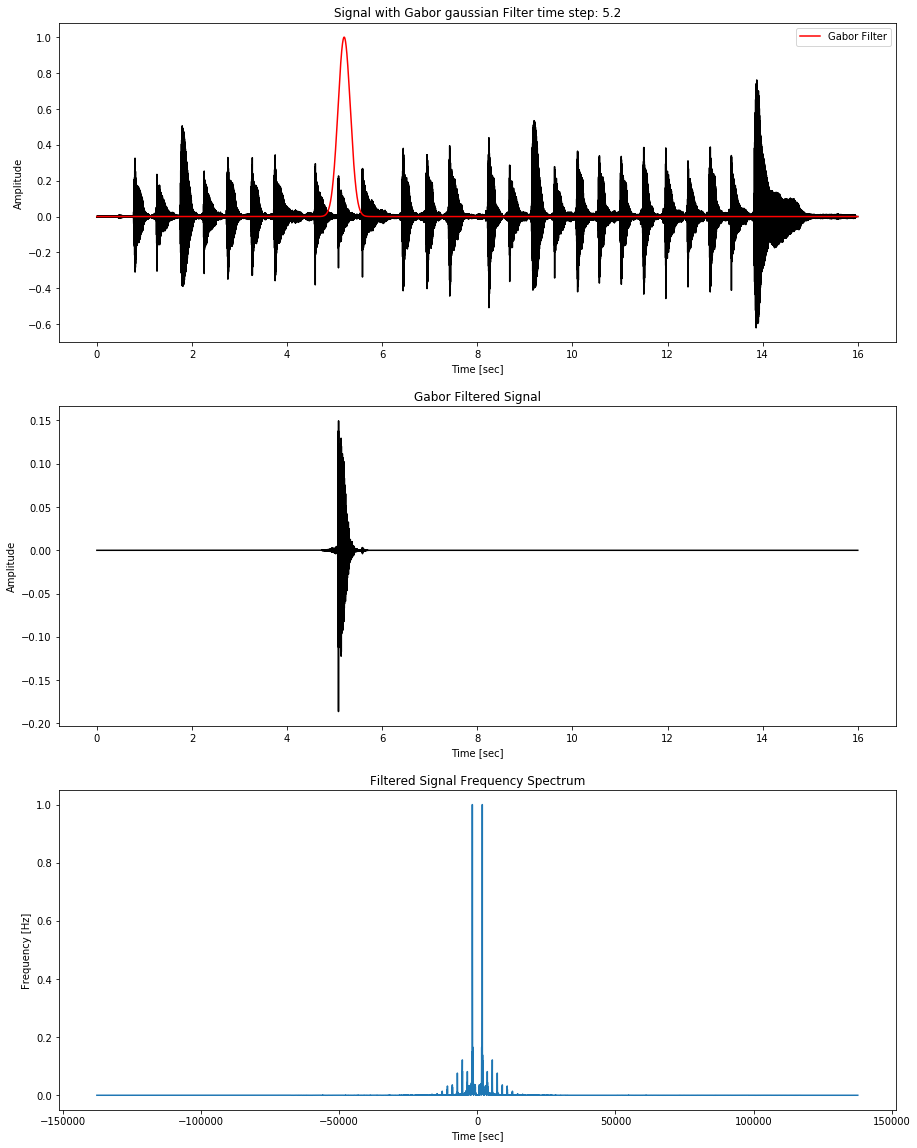

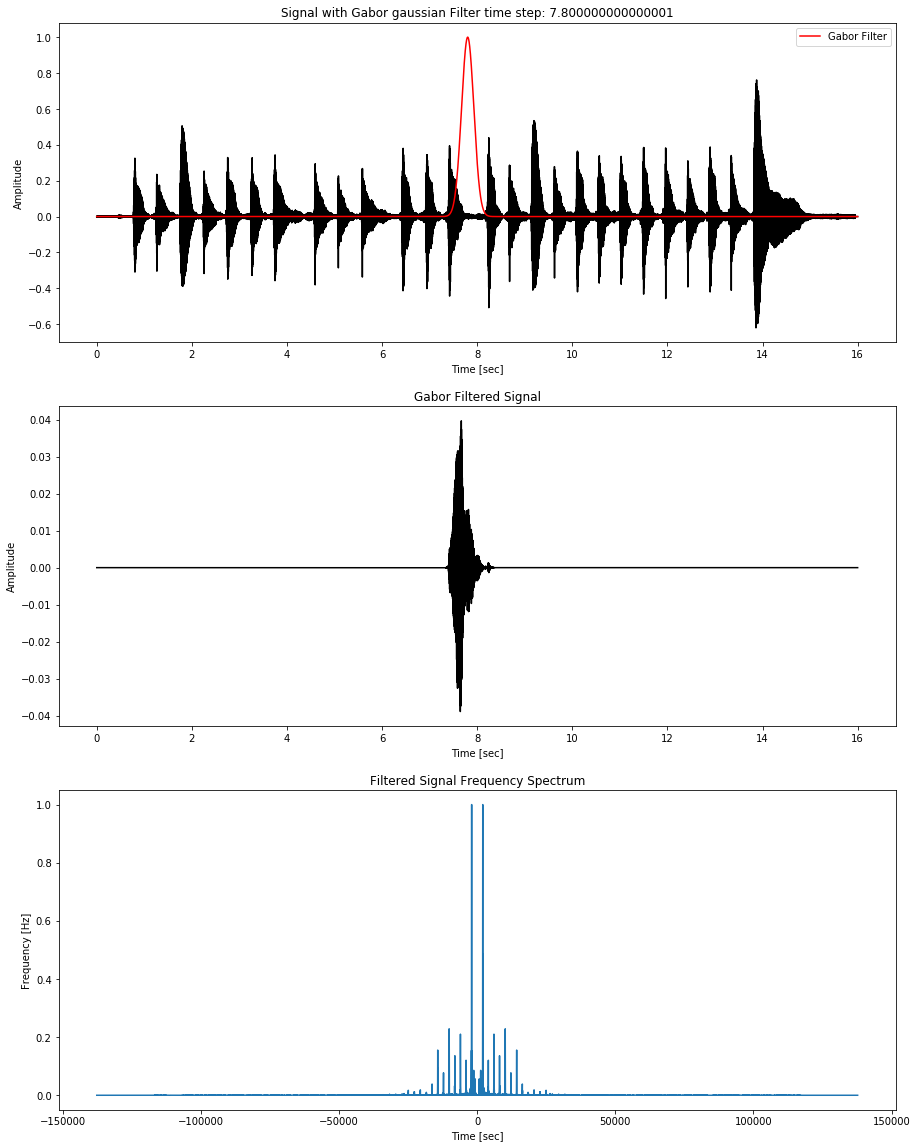

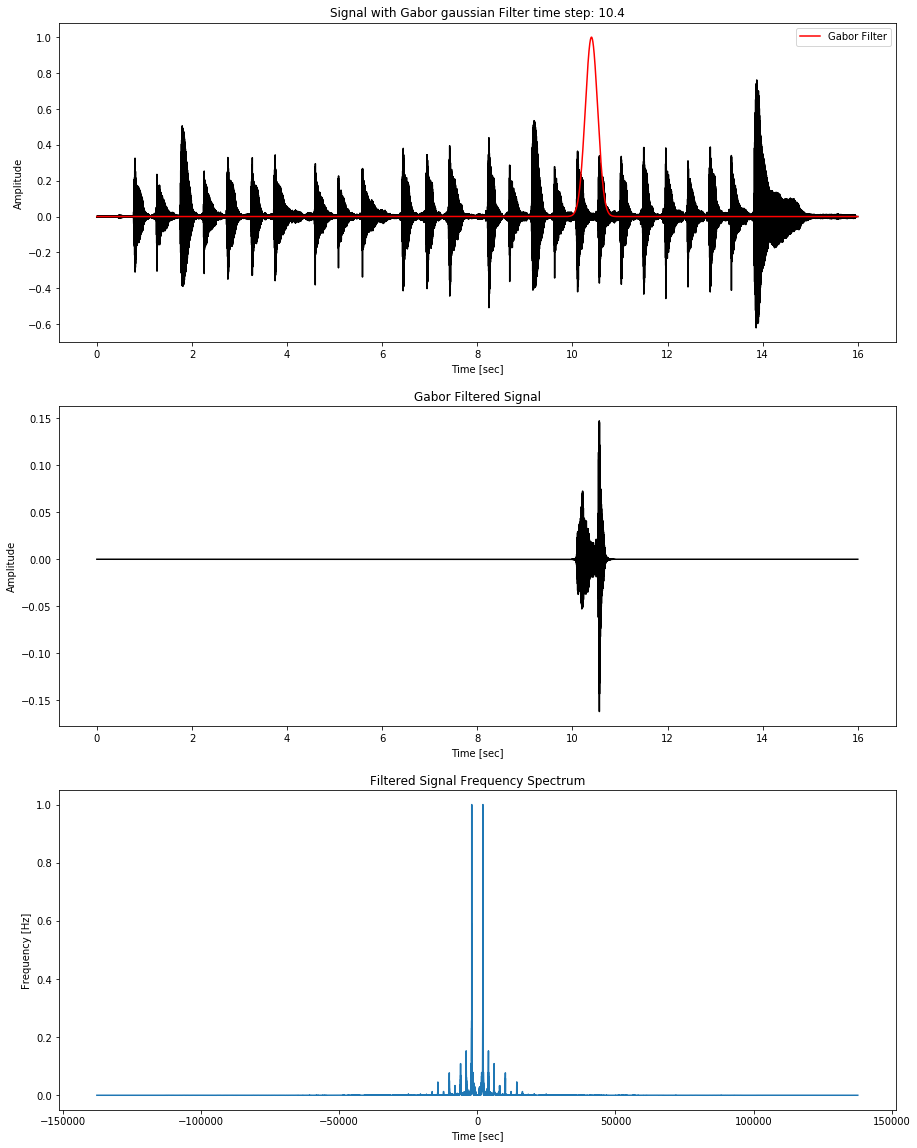

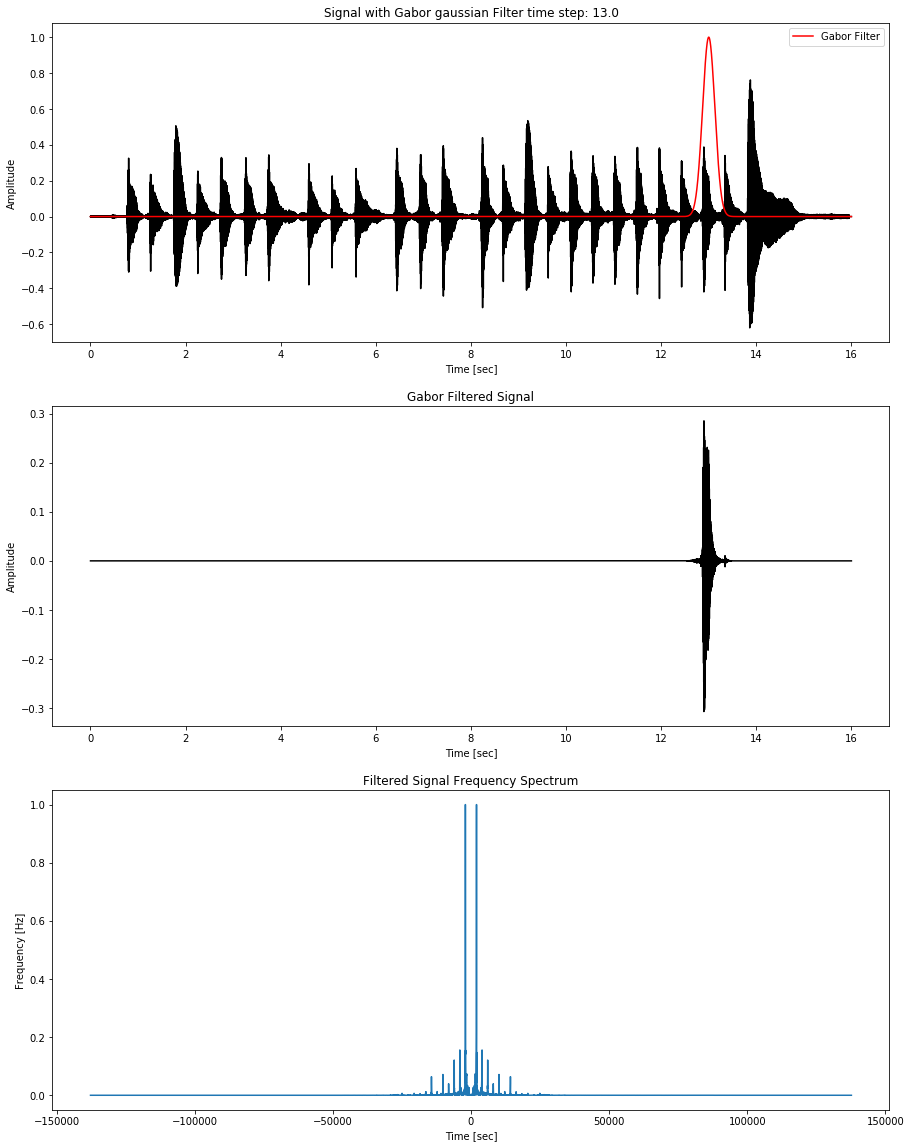

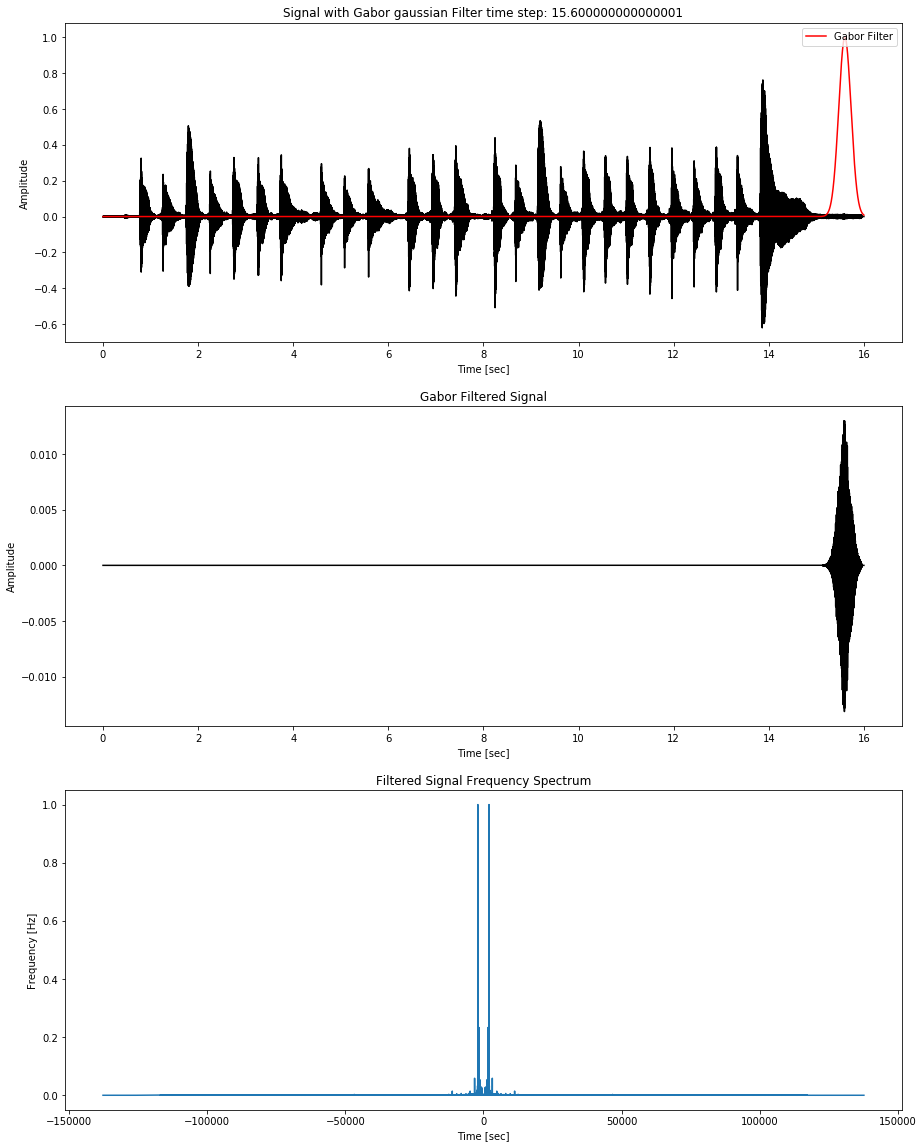

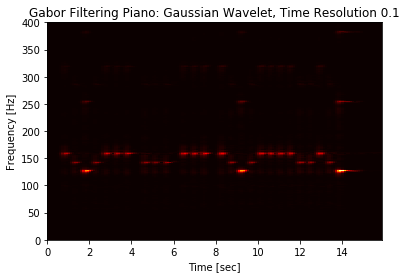

In [5]:
#Try smaller gaussian wavelet, time sampling 0.1 on piano music
tres = 0.1
plot_count = 6
w = 30

[Sgt_spec_p, tslide_p, ks_p] = gaborFilter(yp, Fsp, tres, plot_count, w, ftype='gaussian')

xlim = (None, None)
ylim = (0, 400)
title = 'Gabor Filtering Piano: Gaussian Wavelet, Time Resolution 0.1'
spectroPlot(Sgt_spec_p, tslide_p, ks_p / (4*np.pi), xlim, ylim, title)

[(350, 600), (-0.6950000000000001, 14.595)]

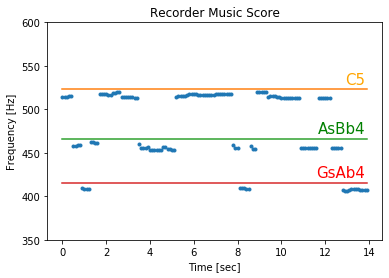

In [54]:
#Determine score of recorder music
names = ['note', 'frequency', 'wavelength']#names for the columns of the dataframe defined as "notes"
#notes dataframe to hold information on the frequencies and names of musical notes
notes = pd.read_excel('musicNotes.xlsx', index_col=None, header=None, names=names)


score = []#array to hold the names of the detected notes or the musical score
freqs = []#array to hold the frequencies in Hz of the detected notes

#iterate over each time bin and determine the frequency in Hz of the note played
for i in range(0, len(tslide_r)):
    
    max_ind = np.argmax(Sgt_spec_r[i, :])#find max entry of the frequency spectrum for the time bin
    wave_num = ks_r[max_ind]#find the associated wave number

    freq = abs(wave_num) / (4*np.pi)#calculate the frequency in Hz of the wave number 
    note_ind = find_nearest(notes['frequency'], freq)#find the index of the that frequency in the notes dataframe

    note = notes.loc[note_ind, 'note']#find the note associated with the frequency of interest
    score.append(note)#add note to score
    freqs.append(freq)#add frequency to list of frequencies (for score plotting)

#plot the musical score
f, ax = plt.subplots()
ax.plot(tslide_r, freqs, ls='', marker='.')#plot the max frequency detected in each time bin 
ax.plot(tslide_r, notes.loc[notes['note'] == 'C5', 'frequency'].values*np.ones(len(tslide_r))) #plot line of dominant note
ax.plot(tslide_r, notes.loc[notes['note'] == 'AsBb4', 'frequency'].values*np.ones(len(tslide_r)))#plot line of dominant note
ax.plot(tslide_r, notes.loc[notes['note'] == 'GsAb4', 'frequency'].values*np.ones(len(tslide_r)))#plot line of dominant note
#annotate line of dominant note
ax.text(0.95, 0.7, 'C5',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='orange', fontsize=15)
#annotate line of dominant note
ax.text(0.95, 0.475, 'AsBb4',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)
#annotate line of dominant note
ax.text(0.95, 0.275, 'GsAb4',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='red', fontsize=15)
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
title = 'Recorder Music Score'
ax.set_title(title)
xlim = (None, None)
ylim = (350, 600)
ax.set(xlim = xlim, ylim = ylim)

[(110, 180), (-0.795, 16.695)]

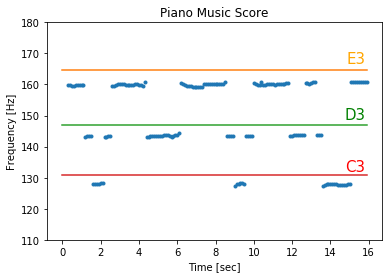

In [55]:
#Determine score of piano music
score = []#array to hold the names of the detected notes or the musical score
freqs = []#array to hold the frequencies in Hz of the detected notes

#iterate over each time bin and determine the frequency in Hz of the note played
for i in range(0, len(tslide_p)):
    
    max_ind = np.argmax(Sgt_spec_p[i, :])#find max entry of the frequency spectrum for the time bin
    wave_num = ks_p[max_ind]#find the associated wave number

    freq = abs(wave_num) / (4*np.pi)#calculate the frequency in Hz of the wave number 
    note_ind = find_nearest(notes['frequency'], freq)#find the index of the that frequency in the notes dataframe

    note = notes.loc[note_ind, 'note']#find the note associated with the frequency of interest
    score.append(note)#add note to score
    freqs.append(freq)#add frequency to list of frequencies (for score plotting)

#plot the musical score
f, ax = plt.subplots()
ax.plot(tslide_p, freqs, ls='', marker='.')#plot the max frequency detected in each time bin 
ax.plot(tslide_p, notes.loc[notes['note'] == 'E3', 'frequency'].values*np.ones(len(tslide_p))) #plot line of dominant note
ax.plot(tslide_p, notes.loc[notes['note'] == 'D3', 'frequency'].values*np.ones(len(tslide_p)))#plot line of dominant note
ax.plot(tslide_p, notes.loc[notes['note'] == 'C3', 'frequency'].values*np.ones(len(tslide_p)))#plot line of dominant note
#annotate line of dominant note
ax.text(0.95, 0.8, 'E3',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='orange', fontsize=15)
#annotate line of dominant note
ax.text(0.95, 0.54, 'D3',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)
#annotate line of dominant note
ax.text(0.95, 0.3, 'C3',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='red', fontsize=15)
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
title = 'Piano Music Score'
ax.set_title(title)
xlim = (None, None)
ylim = (110, 180)
ax.set(xlim = xlim, ylim = ylim)